# Trabajo Práctico: Predicción de lluvia en Australia.

**Materia:** Aprendizaje Automático I (IA41)

**Comisión:** C-31527

**Año académico:** 2024

**Período lectivo:** 1° cuatrimestre

**Integrantes:**
- Britos Julián Francisco
- Moresco Brisa

# Terminado

A continuación, se enlistarán las correcciones que fueron sugeridas hacer y fueron hechas, listas para ser revisadas nuevamente:
- El ploteo de la matriz de correlación luego de haber generado las variables dummies, no es muy recomendado ya que confunde su interpretación innecesariamente.
- Resta completar el análisis estadístico descriptivo con gráficos, comentarios y conclusiones.
- Realizar la imputación de nulos previo a dividir el set de datos en train y test, ¿creen que es la mejor opción? Podría generarse data leakage.
- En cuanto a la forma de hacer el split del set de datos, ¿creen que es la correcta para evitar data leakage? Se trata de un conjunto con fuerte dependencia cronológica.
- ¿Está el set de datos balanceado o no?
- Es importante agregar una gráfica de pérdida vs. iteraciones del gradiente descendente para observar que el modelo converja.
- En cuanto al cálculo de métricas, restan las correspondientes al set de entrenamiento. ¿Por qué ambas son necesarias?
- ¿Consiguió un buen fitting?

# Librerías

In [1]:
#%%capture
#!pip install pandas
#!pip install seaborn
#!pip install -U scikit-learn
#!pip install numpy
#!pip install shap
#!pip install --quiet optuna
#!pip install tensorflow

In [2]:
import time

import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import shap

import optuna


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_classification, load_iris, load_digits
from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, LeaveOneOut, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, SGDRegressor, ElasticNet, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, precision_score
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, log_loss
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time
import joblib
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import streamlit as st

# Carga de datos

### Contexto:

Este conjunto de datos contiene alrededor de 10 años de observaciones meteorológicas diarias de numerosas estaciones meteorológicas australianas.

### Contenido:

Date, Location, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustDir, WindGustSpeed, WindDir9am, WindDir3pm, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Cloud9am, Cloud3pm, Temp9am, Temp3pm, RainToday, RainTomorrow, RainfallTomorrow

### Objetivo:

Tras observar los datos del día de hoy, el objetivo es predecir las variables target:
- RainFallTomorrow: cantidad de lluvia del día posterior a la observación. (Problema de **Regresión**).
- RainTomorrow: si el día siguiente llueve o no llueve. (Problema de **Clasificación**).


In [3]:
file_path= 'weatherAUS.csv'
weather_data = pd.read_csv(file_path, sep=',',engine='python')

# Análisis estadístico descriptivo

## Visualización de datos

Examinaremos los datos para un primer vistazo.

In [4]:
weather_data.head()

Unnamed: 0        Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0           0  2008-12-01   Albury     13.4     22.9       0.6          NaN   
1           1  2008-12-02   Albury      7.4     25.1       0.0          NaN   
2           2  2008-12-03   Albury     12.9     25.7       0.0          NaN   
3           3  2008-12-04   Albury      9.2     28.0       0.0          NaN   
4           4  2008-12-05   Albury     17.5     32.3       1.0          NaN   

   Sunshine WindGustDir  WindGustSpeed  ... Humidity3pm Pressure9am  \
0       NaN           W           44.0  ...        22.0      1007.7   
1       NaN         WNW           44.0  ...        25.0      1010.6   
2       NaN         WSW           46.0  ...        30.0      1007.6   
3       NaN          NE           24.0  ...        16.0      1017.6   
4       NaN           W           41.0  ...        33.0      1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  \
0       1007.1       8.0       NaN     16.9     21.8         No            No   
1       1007.8       NaN       NaN     17.2     24.3         No            No   
2       1008.7       NaN       2.0     21.0     23.2         No            No   
3       1012.8       NaN       NaN     18.1     26.5         No            No   
4       1006.0       7.0       8.0     17.8     29.7         No            No   

   RainfallTomorrow  
0               0.0  
1               0.0  
2               0.0  
3               1.0  
4               0.2  

[5 rows x 25 columns]

Como podemos ver, al haber 25 columnas no nos muestra todas, por lo que deberemos realizar un paso más para verlas.

In [5]:
weather_data.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

A continuación, examinaremos qué tipos de variables son estas columnas.

In [6]:
weather_data.dtypes

Unnamed: 0            int64
Date                 object
Location             object
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir          object
WindGustSpeed       float64
WindDir9am           object
WindDir3pm           object
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainToday            object
RainTomorrow         object
RainfallTomorrow    float64
dtype: object

Investiguemos la presencia de valores nulos en los datos.

In [7]:
weather_data.isna().sum()

Unnamed: 0              0
Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

Para concluir nuestra primera inspección, veremos las estadísticas descriptivas del conjunto de datos.

In [8]:
weather_data.describe(include='all')

Unnamed: 0        Date  Location        MinTemp        MaxTemp  \
count   145412.000000      145412    145412  143928.000000  144159.000000   
unique            NaN        3435        49            NaN            NaN   
top               NaN  2013-11-11  Canberra            NaN            NaN   
freq              NaN          49      3435            NaN            NaN   
mean     72728.184393         NaN       NaN      12.195873      23.223176   
std      41990.722236         NaN       NaN       6.398018       7.118770   
min          0.000000         NaN       NaN      -8.500000      -4.800000   
25%      36362.750000         NaN       NaN       7.600000      17.900000   
50%      72727.500000         NaN       NaN      12.000000      22.600000   
75%     109093.250000         NaN       NaN      16.900000      28.200000   
max     145458.000000         NaN       NaN      33.900000      48.100000   

             Rainfall   Evaporation      Sunshine WindGustDir  WindGustSpeed  \
count   142152.000000  82658.000000  75616.000000      135096  135159.000000   
unique            NaN           NaN           NaN          16            NaN   
top               NaN           NaN           NaN           W            NaN   
freq              NaN           NaN           NaN        9910            NaN   
mean         2.361516      5.468616      7.611241         NaN      40.036564   
std          8.479338      4.193871      3.785612         NaN      13.607212   
min          0.000000      0.000000      0.000000         NaN       6.000000   
25%          0.000000      2.600000      4.800000         NaN      31.000000   
50%          0.000000      4.800000      8.400000         NaN      39.000000   
75%          0.800000      7.400000     10.600000         NaN      48.000000   
max        371.000000    145.000000     14.500000         NaN     135.000000   

        ...    Humidity3pm    Pressure9am    Pressure3pm      Cloud9am  \
count   ...  140907.000000  130351.000000  130388.000000  89542.000000   
unique  ...            NaN            NaN            NaN           NaN   
top     ...            NaN            NaN            NaN           NaN   
freq    ...            NaN            NaN            NaN           NaN   
mean    ...      51.537432    1017.649277    1015.255184      4.447287   
std     ...      20.796720       7.107132       7.037981      2.887161   
min     ...       0.000000     980.500000     977.100000      0.000000   
25%     ...      37.000000    1012.900000    1010.400000      1.000000   
50%     ...      52.000000    1017.600000    1015.200000      5.000000   
75%     ...      66.000000    1022.400000    1020.000000      7.000000   
max     ...     100.000000    1041.000000    1039.600000      9.000000   

            Cloud3pm        Temp9am        Temp3pm  RainToday  RainTomorrow  \
count   86076.000000  143646.000000  141805.000000     142152        142153   
unique           NaN            NaN            NaN          2             2   
top              NaN            NaN            NaN         No            No   
freq             NaN            NaN            NaN     110276        110281   
mean        4.509770      16.992780      21.685249        NaN           NaN   
std         2.720306       6.488045       6.936358        NaN           NaN   
min         0.000000      -7.200000      -5.400000        NaN           NaN   
25%         2.000000      12.300000      16.600000        NaN           NaN   
50%         5.000000      16.700000      21.100000        NaN           NaN   
75%         7.000000      21.600000      26.400000        NaN           NaN   
max         9.000000      40.200000      46.700000        NaN           NaN   

        RainfallTomorrow  
count      142153.000000  
unique               NaN  
top                  NaN  
freq                 NaN  
mean            2.361242  
std             8.479084  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0

## Gráficos

### Location

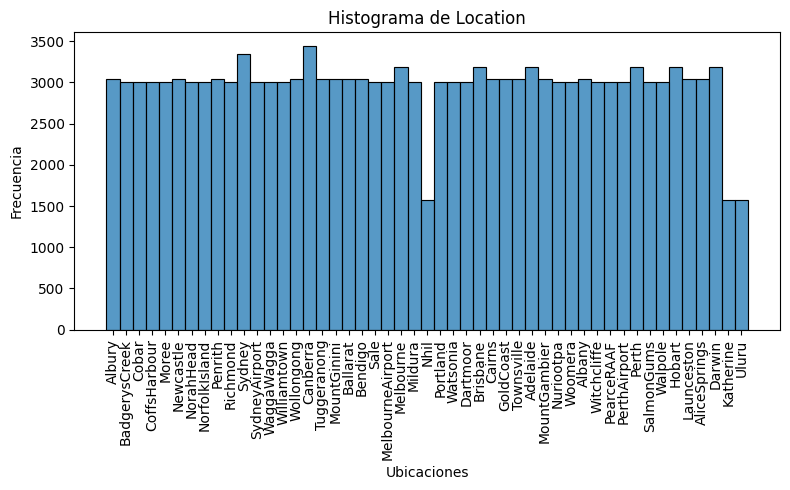

count       145412
unique          49
top       Canberra
freq          3435
Name: Location, dtype: object

In [8]:
fig, axs = plt.subplots(figsize=(8, 5))

# Histograma
sns.histplot(weather_data['Location'])
axs.set_title('Histograma de Location')
axs.set_xlabel('Ubicaciones')
axs.set_ylabel('Frecuencia')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

weather_data['Location'].describe()


**Interpretación:**

Se observa que la frecuencia varía entre las diferentes ubicaciones, lo que indica que algunas ubicaciones tienen más observaciones que otras en el conjunto de datos.

### MinTemp

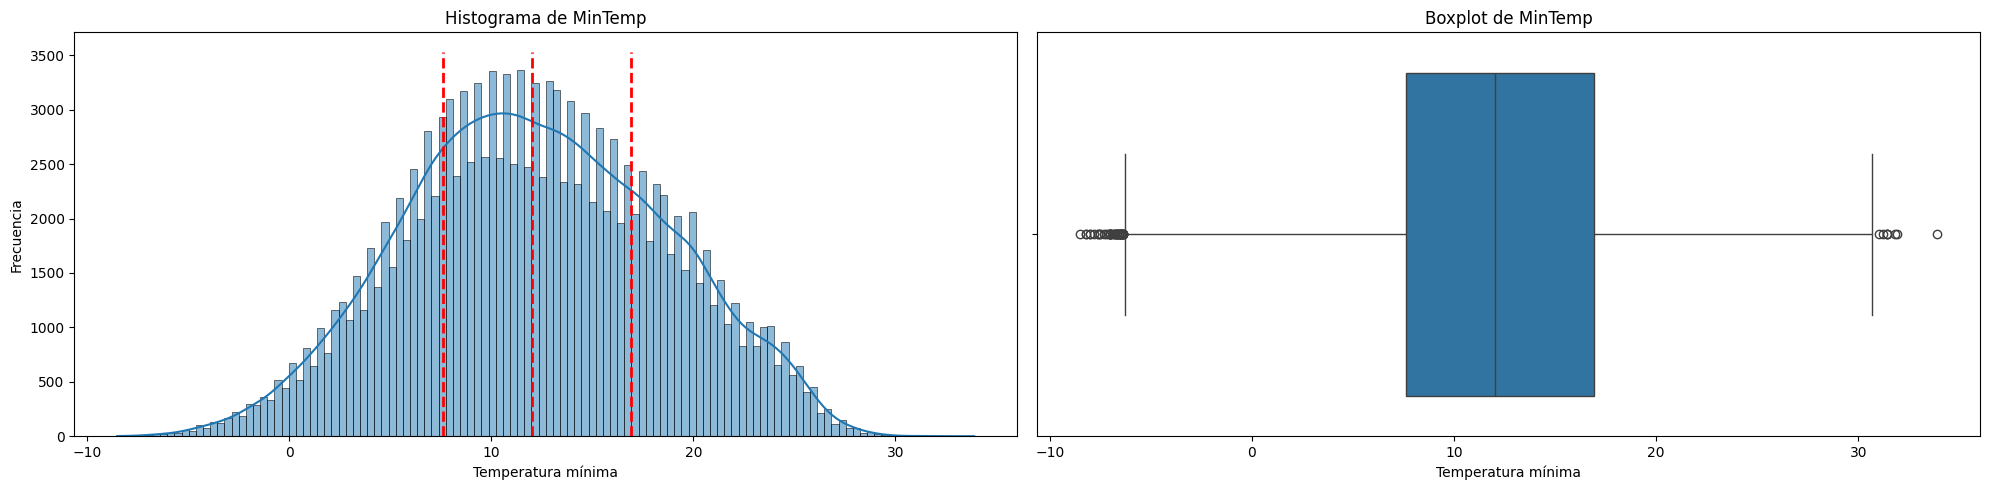

count    143928.000000
mean         12.195873
std           6.398018
min          -8.500000
25%           7.600000
50%          12.000000
75%          16.900000
max          33.900000
Name: MinTemp, dtype: float64

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['MinTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MinTemp')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['MinTemp'].quantile(0.25)
q2 = weather_data['MinTemp'].quantile(0.5)
q3 = weather_data['MinTemp'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['MinTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MinTemp')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()

weather_data['MinTemp'].describe()

### MaxTemp

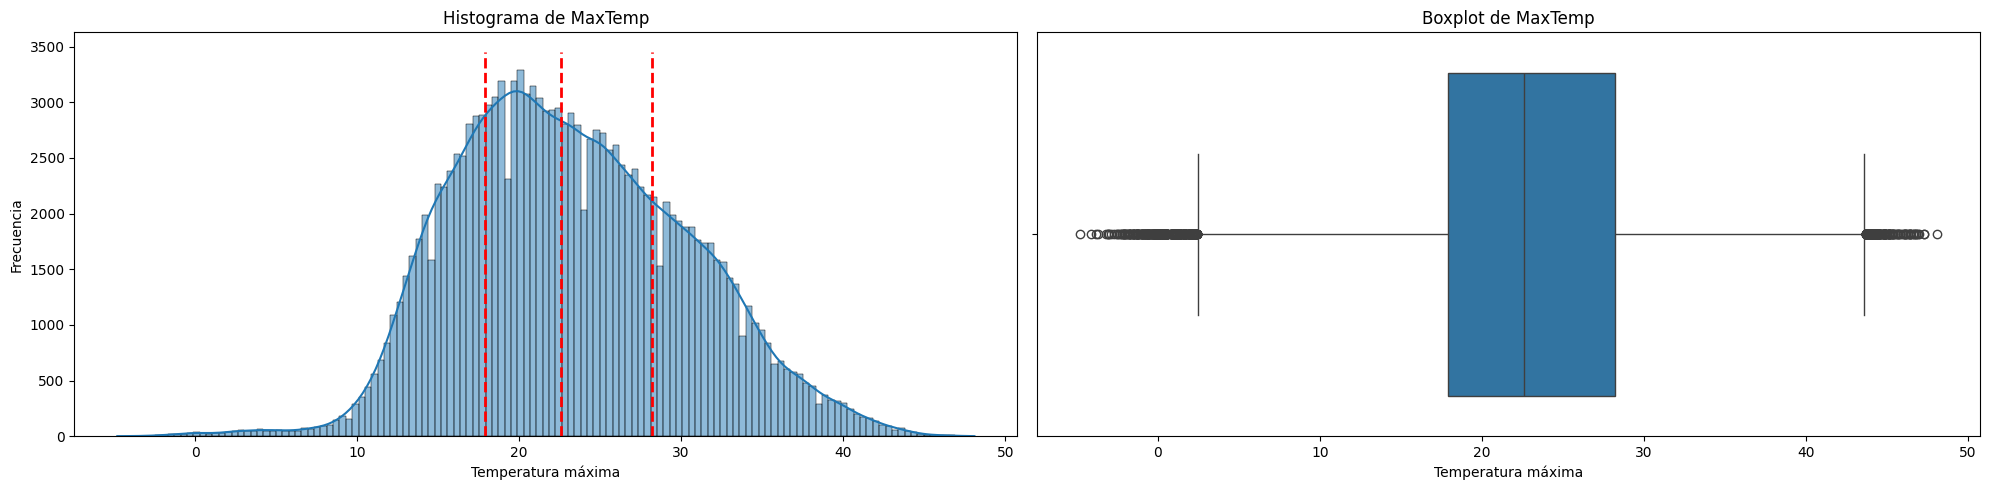

count    144159.000000
mean         23.223176
std           7.118770
min          -4.800000
25%          17.900000
50%          22.600000
75%          28.200000
max          48.100000
Name: MaxTemp, dtype: float64

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['MaxTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MaxTemp')
axs[0].set_xlabel('Temperatura máxima')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['MaxTemp'].quantile(0.25)
q2 = weather_data['MaxTemp'].quantile(0.5)
q3 = weather_data['MaxTemp'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['MaxTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MaxTemp')
axs[1].set_xlabel('Temperatura máxima')

plt.tight_layout()
plt.show()

weather_data['MaxTemp'].describe()


### Rainfall

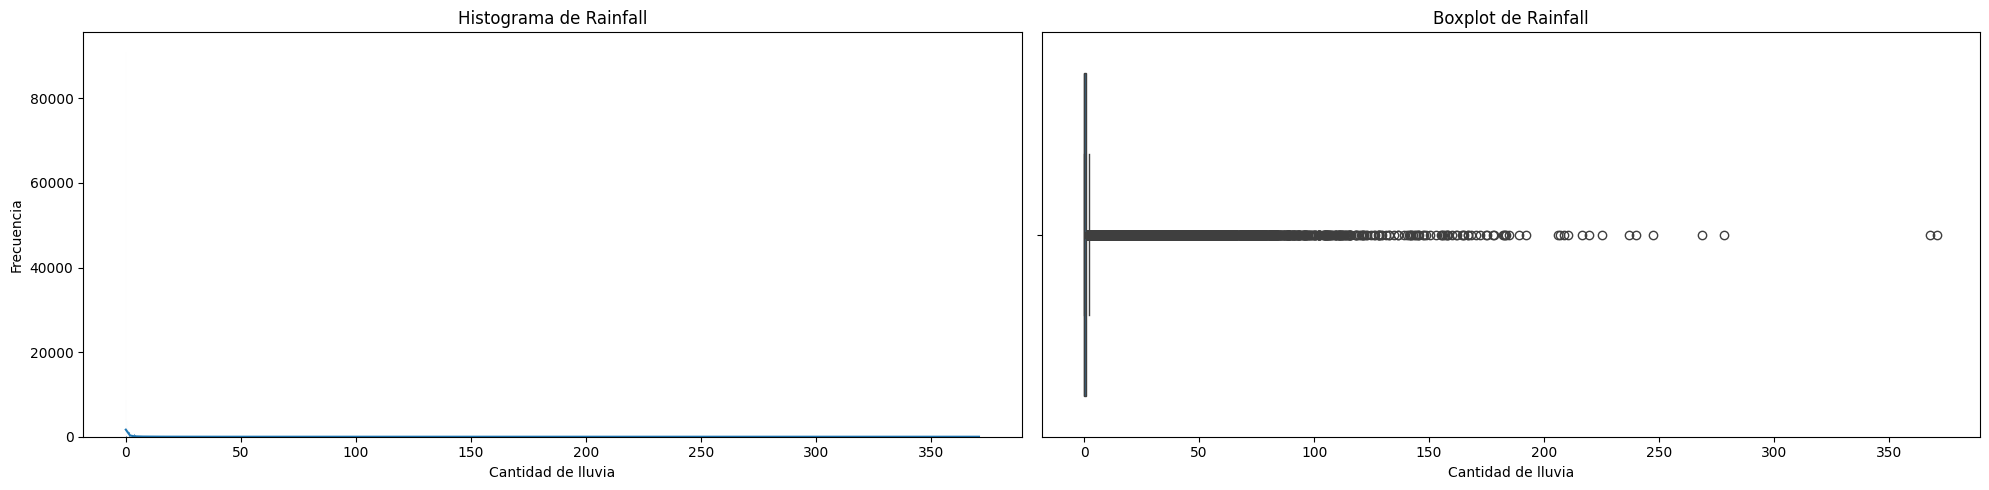

count    142152.000000
mean          2.361516
std           8.479338
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max         371.000000
Name: Rainfall, dtype: float64

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Cantidad de lluvia')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Cantidad de lluvia')

plt.tight_layout()
plt.show()

weather_data['Rainfall'].describe()


### Evaporation

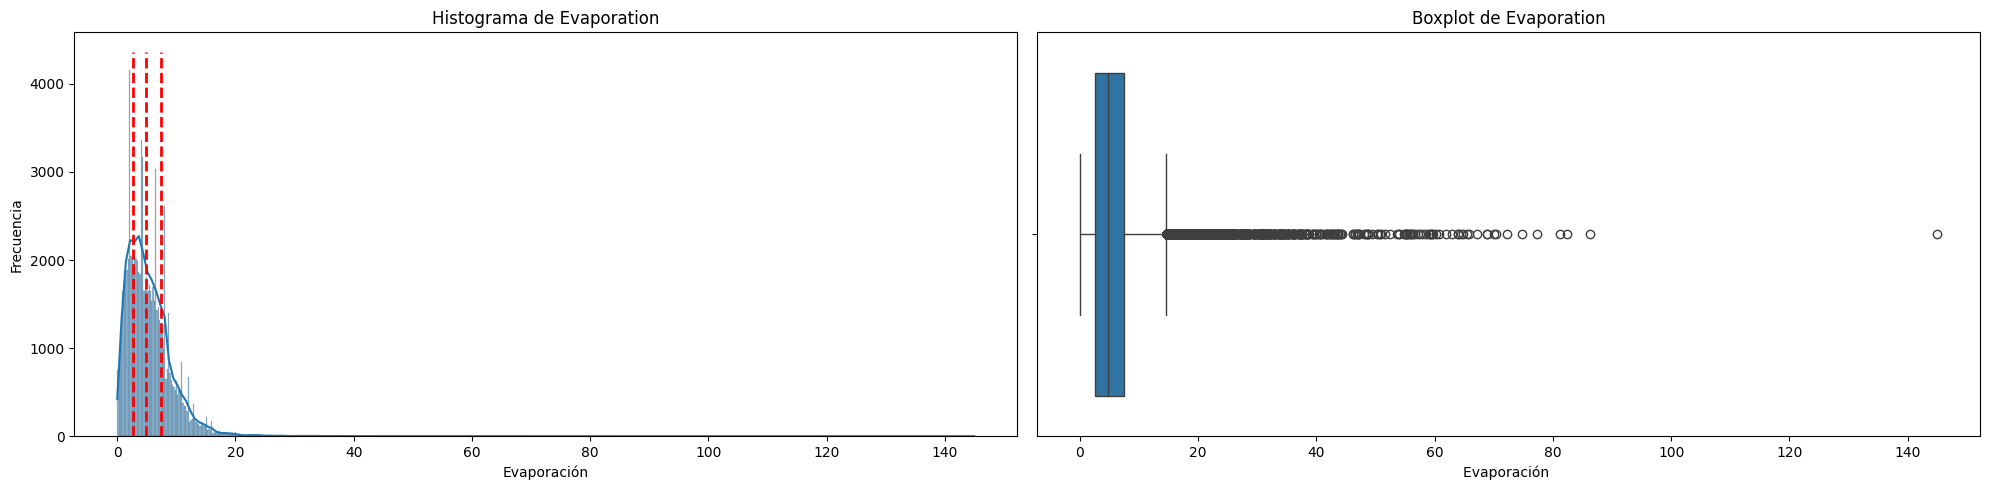

count    82658.000000
mean         5.468616
std          4.193871
min          0.000000
25%          2.600000
50%          4.800000
75%          7.400000
max        145.000000
Name: Evaporation, dtype: float64

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Evaporation'], kde=True, ax=axs[0])

# Calcular cuartiles
q1 = weather_data['Evaporation'].quantile(0.25)
q2 = weather_data['Evaporation'].quantile(0.5)
q3 = weather_data['Evaporation'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

axs[0].set_title('Histograma de Evaporation')
axs[0].set_xlabel('Evaporación')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Evaporation'], ax=axs[1])
axs[1].set_title('Boxplot de Evaporation')
axs[1].set_xlabel('Evaporación ')

plt.tight_layout()
plt.show()

weather_data['Evaporation'].describe()



### Sunshine

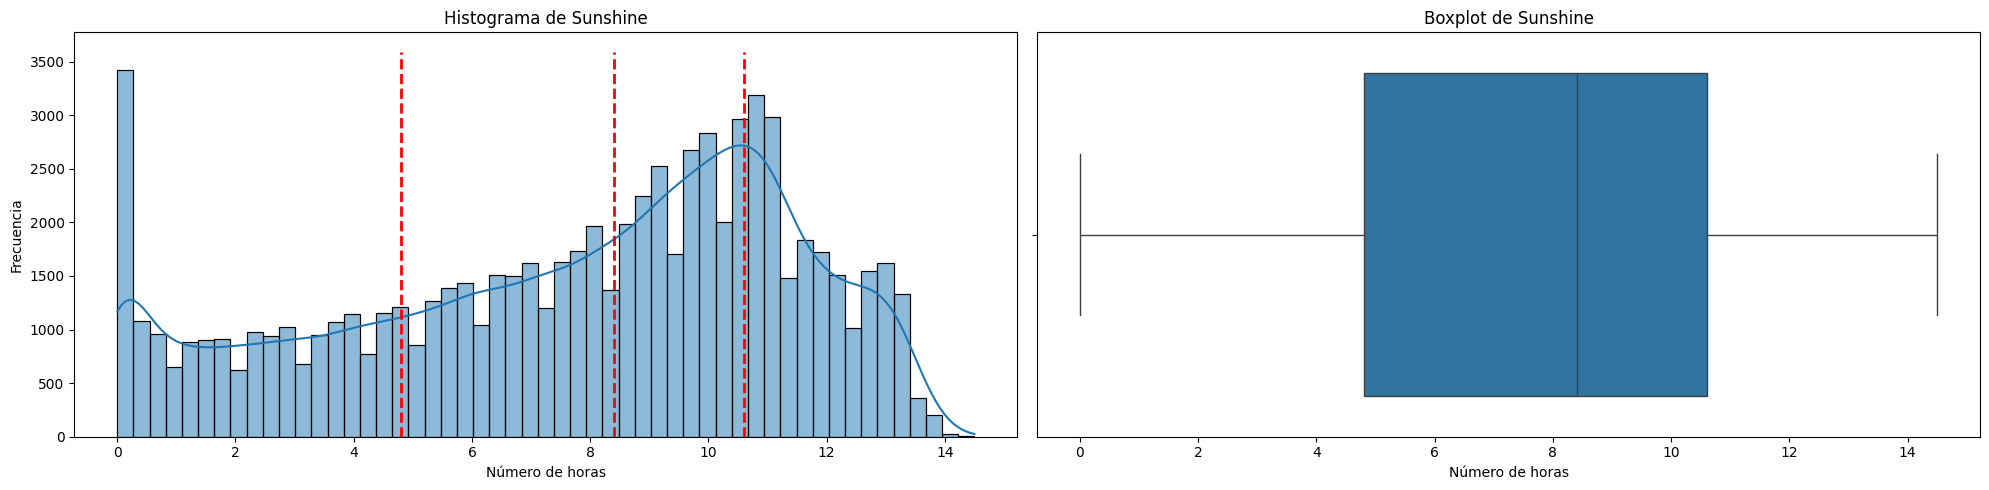

count    75616.000000
mean         7.611241
std          3.785612
min          0.000000
25%          4.800000
50%          8.400000
75%         10.600000
max         14.500000
Name: Sunshine, dtype: float64

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Sunshine'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Sunshine')
axs[0].set_xlabel('Número de horas')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Sunshine'].quantile(0.25)
q2 = weather_data['Sunshine'].quantile(0.5)
q3 = weather_data['Sunshine'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Sunshine'], ax=axs[1])
axs[1].set_title('Boxplot de Sunshine')
axs[1].set_xlabel('Número de horas')

plt.tight_layout()
plt.show()

weather_data['Sunshine'].describe()

### WindGustDir

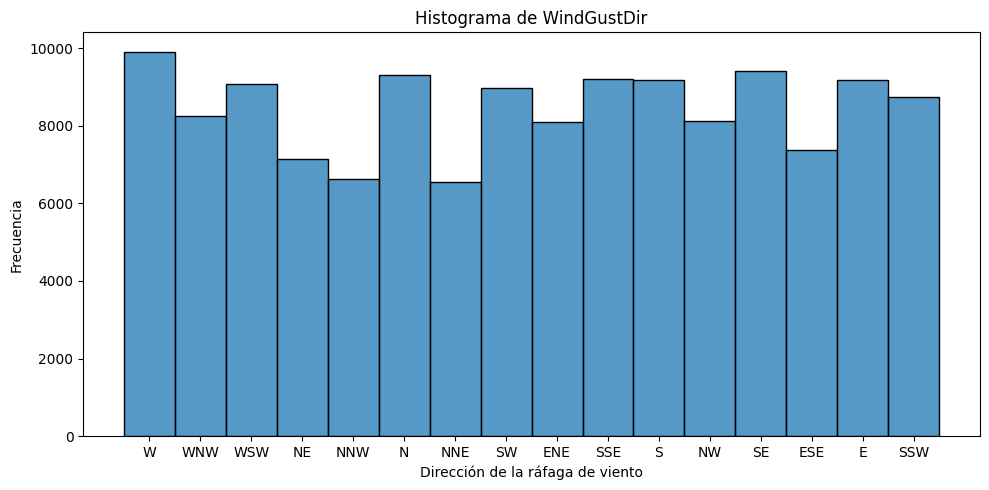

count     135096
unique        16
top            W
freq        9910
Name: WindGustDir, dtype: object

In [14]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(weather_data['WindGustDir'])
axs.set_title('Histograma de WindGustDir')
axs.set_xlabel('Dirección de la ráfaga de viento')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

weather_data['WindGustDir'].describe()

### WindGustSpeed

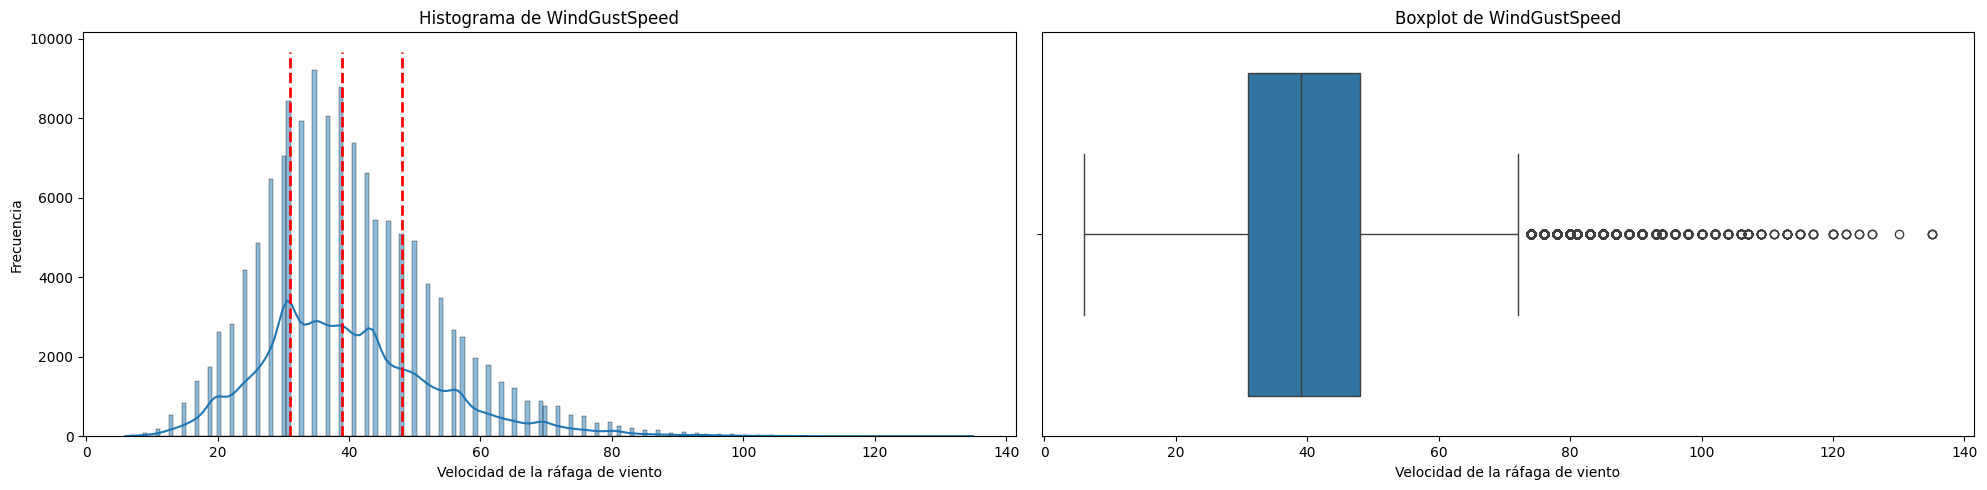

count    135159.000000
mean         40.036564
std          13.607212
min           6.000000
25%          31.000000
50%          39.000000
75%          48.000000
max         135.000000
Name: WindGustSpeed, dtype: float64

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['WindGustSpeed'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindGustSpeed')
axs[0].set_xlabel('Velocidad de la ráfaga de viento')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['WindGustSpeed'].quantile(0.25)
q2 = weather_data['WindGustSpeed'].quantile(0.5)
q3 = weather_data['WindGustSpeed'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['WindGustSpeed'], ax=axs[1])
axs[1].set_title('Boxplot de WindGustSpeed')
axs[1].set_xlabel('Velocidad de la ráfaga de viento')

plt.tight_layout()
plt.show()

weather_data['WindGustSpeed'].describe()

### WindDir9am

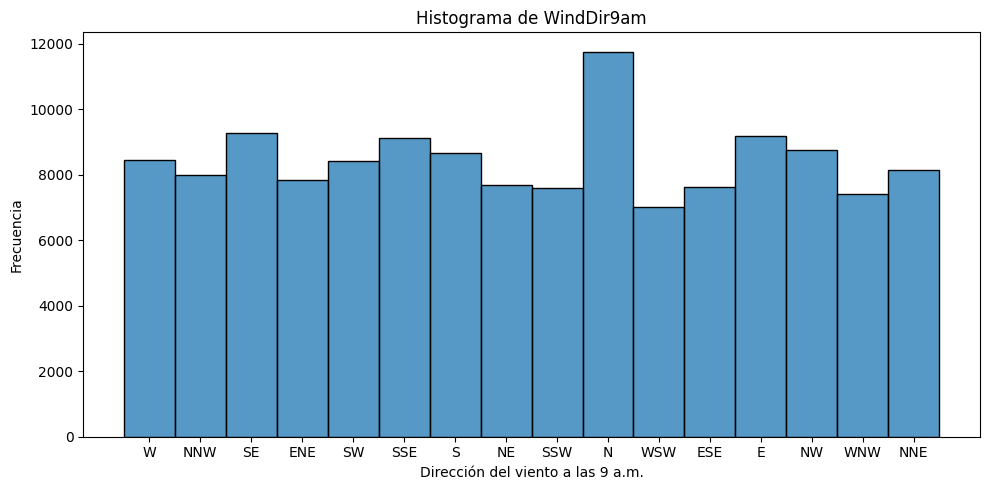

count     134850
unique        16
top            N
freq       11754
Name: WindDir9am, dtype: object

In [16]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(weather_data['WindDir9am'])
axs.set_title('Histograma de WindDir9am')
axs.set_xlabel('Dirección del viento a las 9 a.m.')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

weather_data['WindDir9am'].describe()

### WindDir3pm

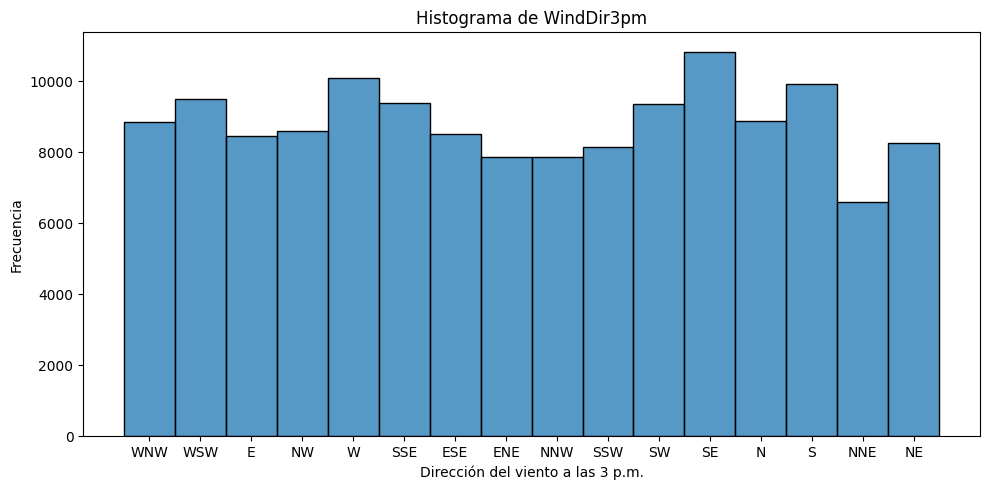

count     141186
unique        16
top           SE
freq       10837
Name: WindDir3pm, dtype: object

In [17]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(weather_data['WindDir3pm'])
axs.set_title('Histograma de WindDir3pm')
axs.set_xlabel('Dirección del viento a las 3 p.m.')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

weather_data['WindDir3pm'].describe()

### WindSpeed9am

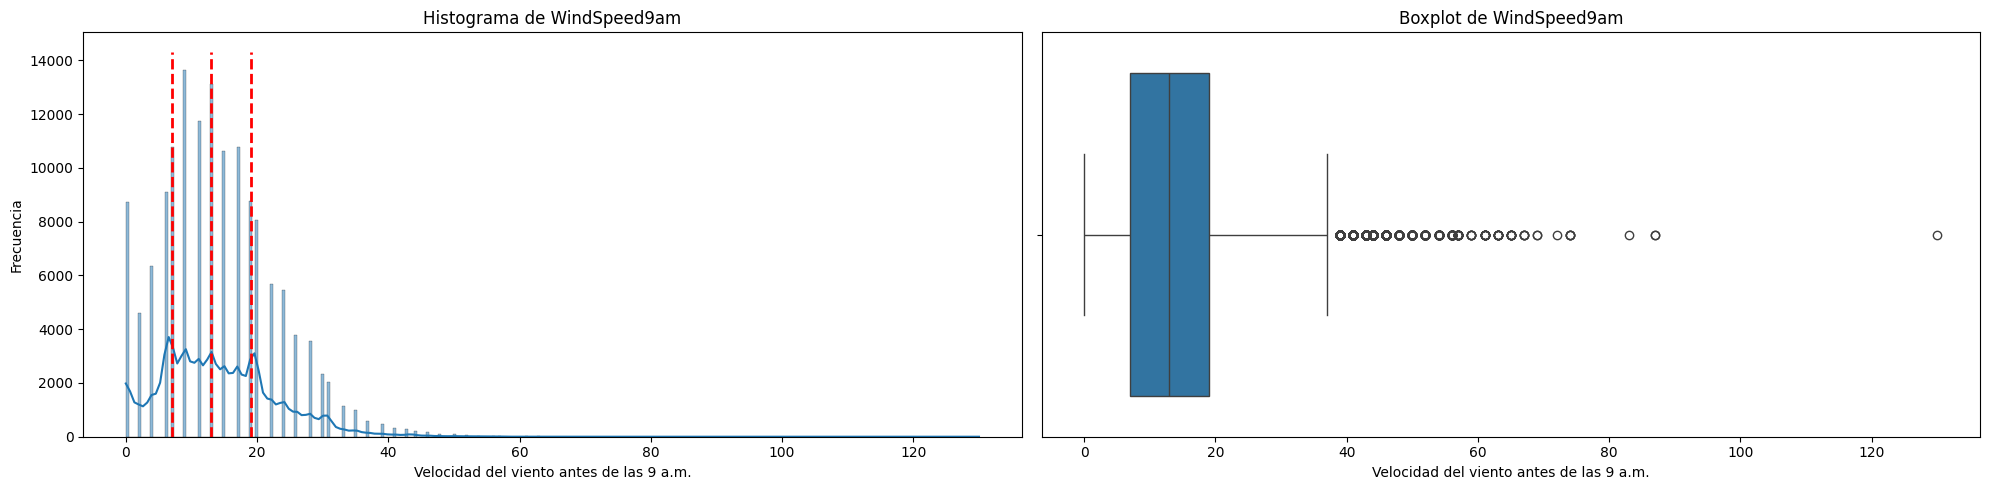

count    143645.000000
mean         14.044742
std           8.915610
min           0.000000
25%           7.000000
50%          13.000000
75%          19.000000
max         130.000000
Name: WindSpeed9am, dtype: float64

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['WindSpeed9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed9am')
axs[0].set_xlabel('Velocidad del viento antes de las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['WindSpeed9am'].quantile(0.25)
q2 = weather_data['WindSpeed9am'].quantile(0.5)
q3 = weather_data['WindSpeed9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['WindSpeed9am'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed9am')
axs[1].set_xlabel('Velocidad del viento antes de las 9 a.m.')

plt.tight_layout()
plt.show()

weather_data['WindSpeed9am'].describe()

### WindSpeed3pm

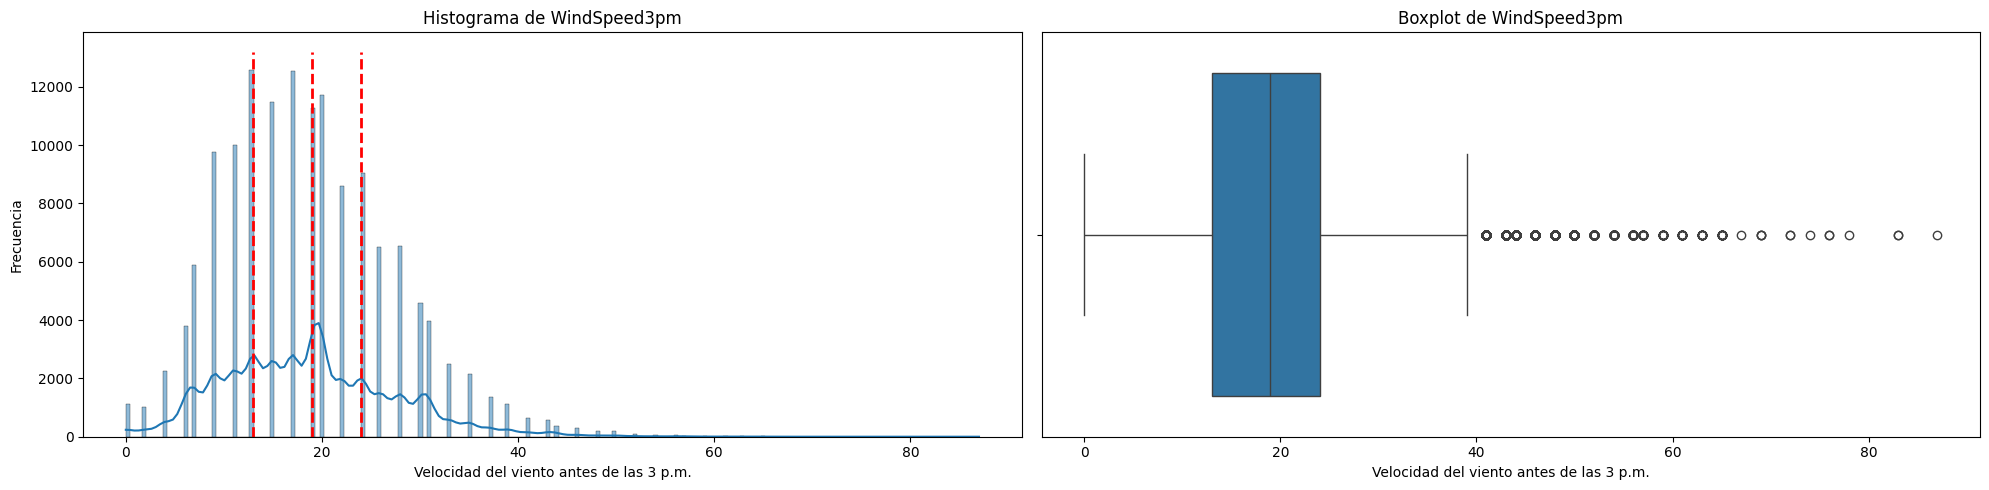

count    142351.000000
mean         18.663164
std           8.810276
min           0.000000
25%          13.000000
50%          19.000000
75%          24.000000
max          87.000000
Name: WindSpeed3pm, dtype: float64

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['WindSpeed3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de WindSpeed3pm')
axs[0].set_xlabel('Velocidad del viento antes de las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['WindSpeed3pm'].quantile(0.25)
q2 = weather_data['WindSpeed3pm'].quantile(0.5)
q3 = weather_data['WindSpeed3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['WindSpeed3pm'], ax=axs[1])
axs[1].set_title('Boxplot de WindSpeed3pm')
axs[1].set_xlabel('Velocidad del viento antes de las 3 p.m.')

plt.tight_layout()
plt.show()

weather_data['WindSpeed3pm'].describe()

### Humidity9am

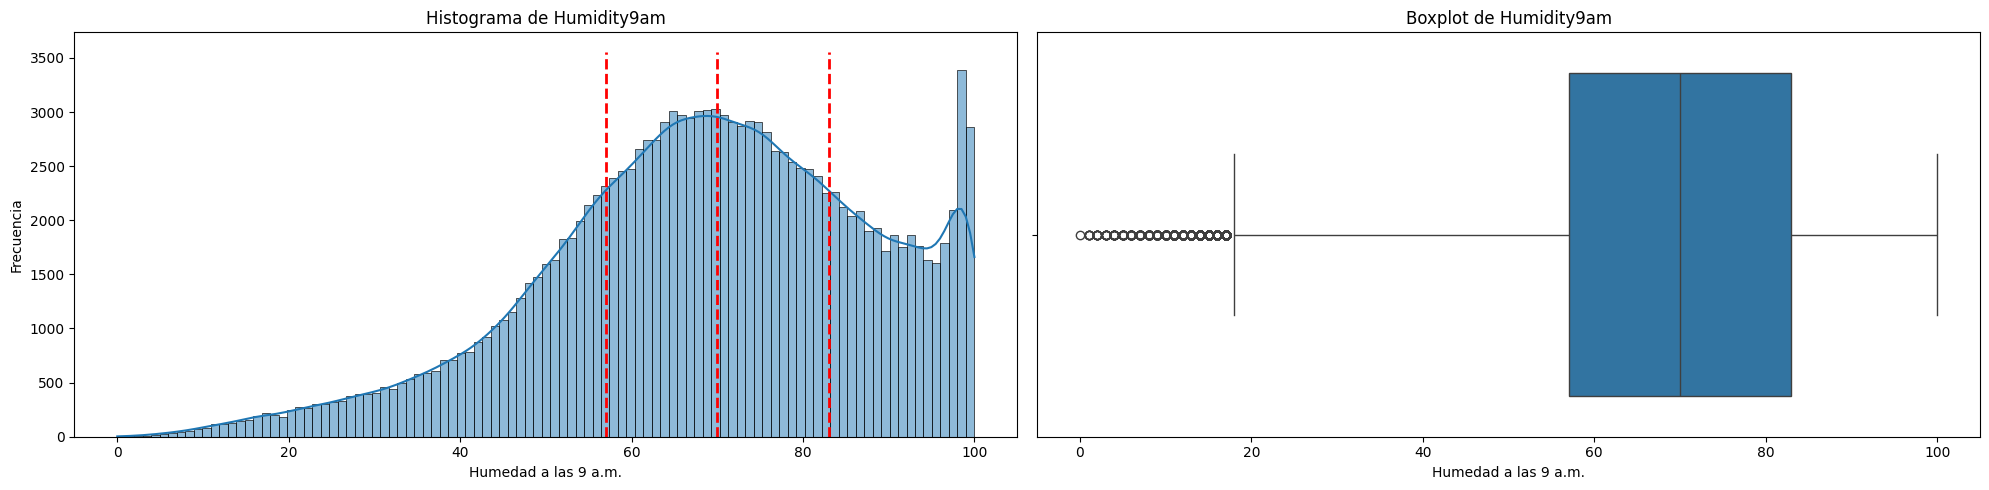

count    142759.000000
mean         68.877290
std          19.029576
min           0.000000
25%          57.000000
50%          70.000000
75%          83.000000
max         100.000000
Name: Humidity9am, dtype: float64

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Humidity9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Humidity9am')
axs[0].set_xlabel('Humedad a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Humidity9am'].quantile(0.25)
q2 = weather_data['Humidity9am'].quantile(0.5)
q3 = weather_data['Humidity9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Humidity9am'], ax=axs[1])
axs[1].set_title('Boxplot de Humidity9am')
axs[1].set_xlabel('Humedad a las 9 a.m.')

plt.tight_layout()
plt.show()

weather_data['Humidity9am'].describe()

### Humidity3pm

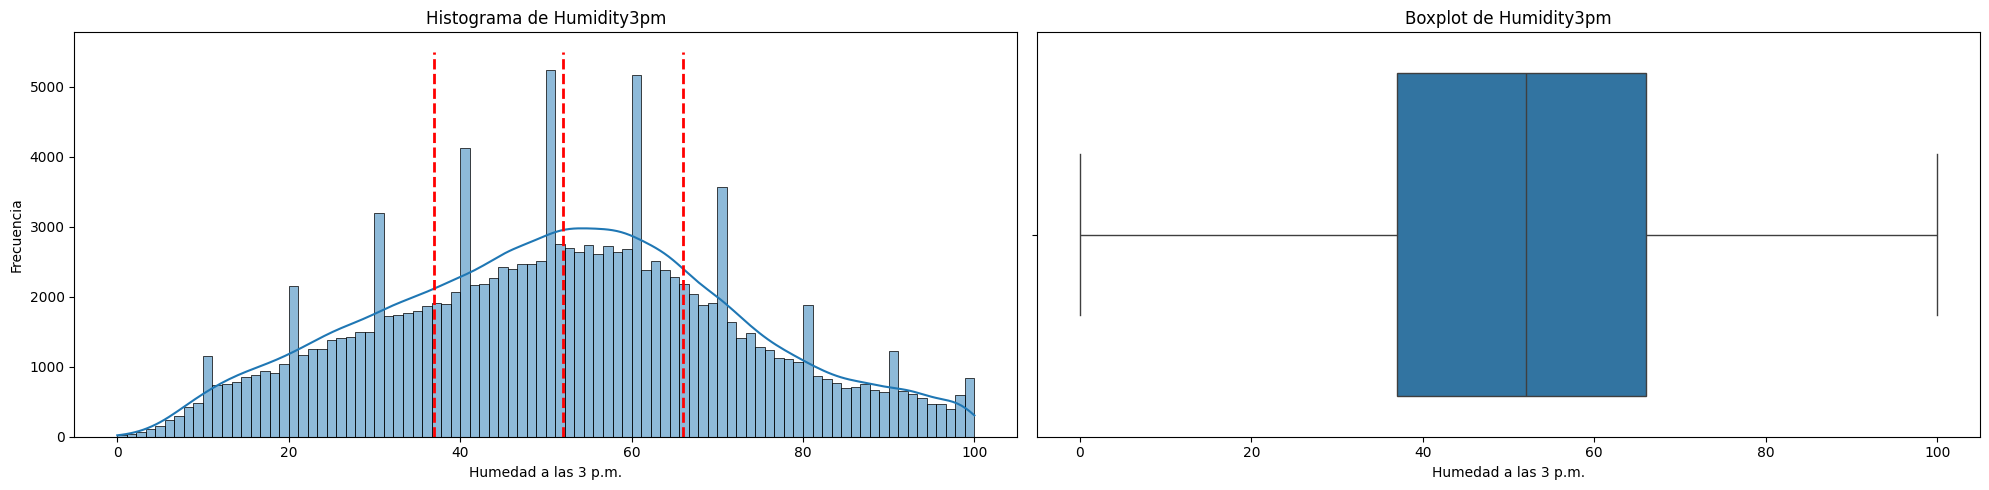

count    140907.000000
mean         51.537432
std          20.796720
min           0.000000
25%          37.000000
50%          52.000000
75%          66.000000
max         100.000000
Name: Humidity3pm, dtype: float64

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Humidity3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Humidity3pm')
axs[0].set_xlabel('Humedad a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Humidity3pm'].quantile(0.25)
q2 = weather_data['Humidity3pm'].quantile(0.5)
q3 = weather_data['Humidity3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Humidity3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Humidity3pm')
axs[1].set_xlabel('Humedad a las 3 p.m.')

plt.tight_layout()
plt.show()

weather_data['Humidity3pm'].describe()

### Pressure9am

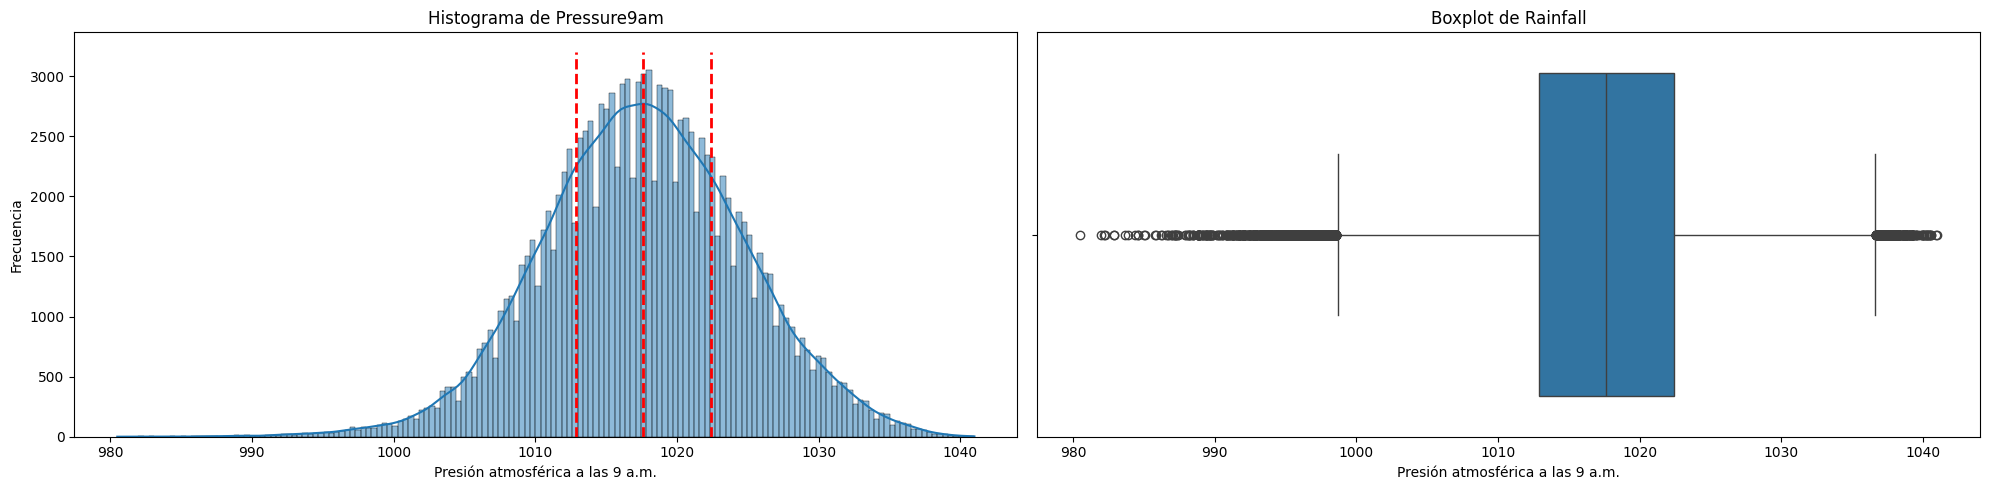

count    130351.000000
mean       1017.649277
std           7.107132
min         980.500000
25%        1012.900000
50%        1017.600000
75%        1022.400000
max        1041.000000
Name: Pressure9am, dtype: float64

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Pressure9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Pressure9am')
axs[0].set_xlabel('Presión atmosférica a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Pressure9am'].quantile(0.25)
q2 = weather_data['Pressure9am'].quantile(0.5)
q3 = weather_data['Pressure9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Pressure9am'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Presión atmosférica a las 9 a.m.')

plt.tight_layout()
plt.show()

weather_data['Pressure9am'].describe()

### Pressure3pm

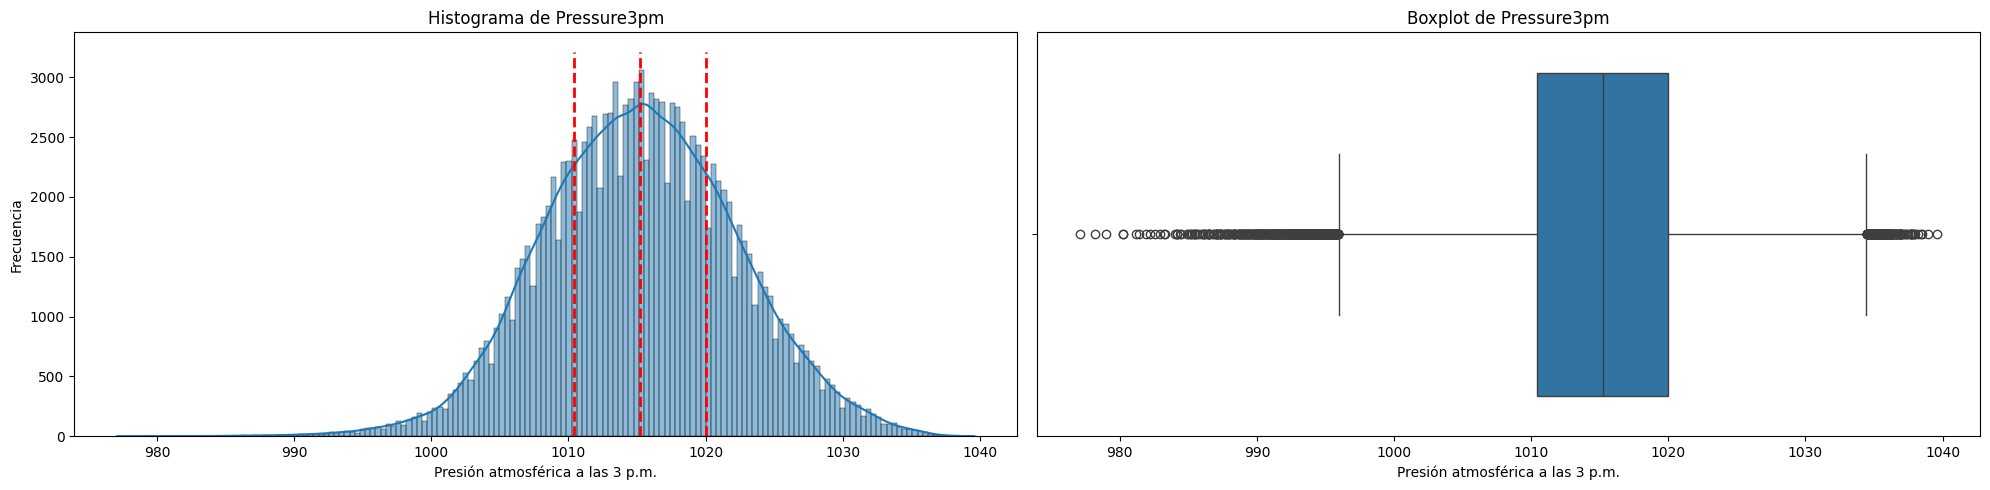

count    130388.000000
mean       1015.255184
std           7.037981
min         977.100000
25%        1010.400000
50%        1015.200000
75%        1020.000000
max        1039.600000
Name: Pressure3pm, dtype: float64

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Pressure3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Pressure3pm')
axs[0].set_xlabel('Presión atmosférica a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Pressure3pm'].quantile(0.25)
q2 = weather_data['Pressure3pm'].quantile(0.5)
q3 = weather_data['Pressure3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Pressure3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Pressure3pm')
axs[1].set_xlabel('Presión atmosférica a las 3 p.m.')

plt.tight_layout()
plt.show()

weather_data['Pressure3pm'].describe()

### Cloud9am

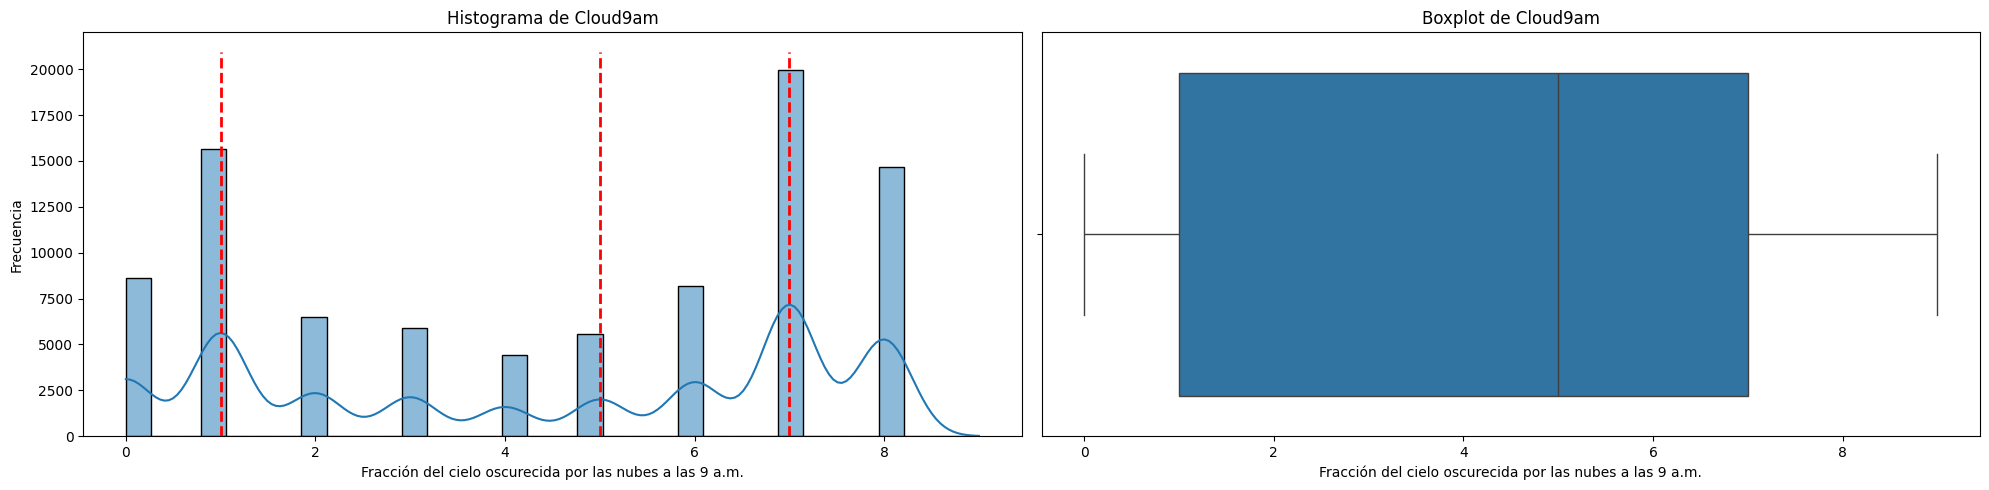

count    89542.000000
mean         4.447287
std          2.887161
min          0.000000
25%          1.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: Cloud9am, dtype: float64

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Cloud9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Cloud9am')
axs[0].set_xlabel('Fracción del cielo oscurecida por las nubes a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Cloud9am'].quantile(0.25)
q2 = weather_data['Cloud9am'].quantile(0.5)
q3 = weather_data['Cloud9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Cloud9am'], ax=axs[1])
axs[1].set_title('Boxplot de Cloud9am')
axs[1].set_xlabel('Fracción del cielo oscurecida por las nubes a las 9 a.m.')

plt.tight_layout()
plt.show()

weather_data['Cloud9am'].describe()

### Cloud3pm

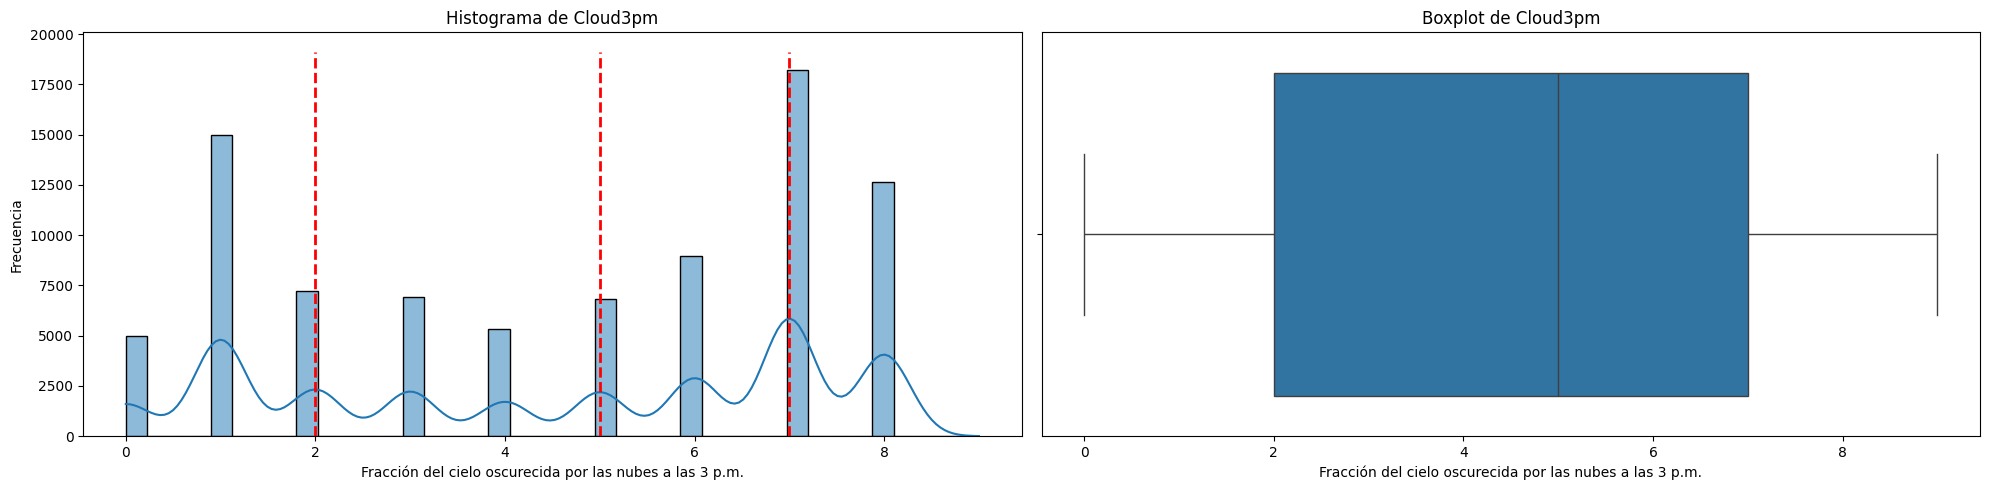

count    86076.000000
mean         4.509770
std          2.720306
min          0.000000
25%          2.000000
50%          5.000000
75%          7.000000
max          9.000000
Name: Cloud3pm, dtype: float64

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Cloud3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Cloud3pm')
axs[0].set_xlabel('Fracción del cielo oscurecida por las nubes a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Cloud3pm'].quantile(0.25)
q2 = weather_data['Cloud3pm'].quantile(0.5)
q3 = weather_data['Cloud3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Cloud3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Cloud3pm')
axs[1].set_xlabel('Fracción del cielo oscurecida por las nubes a las 3 p.m.')

plt.tight_layout()
plt.show()

weather_data['Cloud3pm'].describe()

### Temp9am

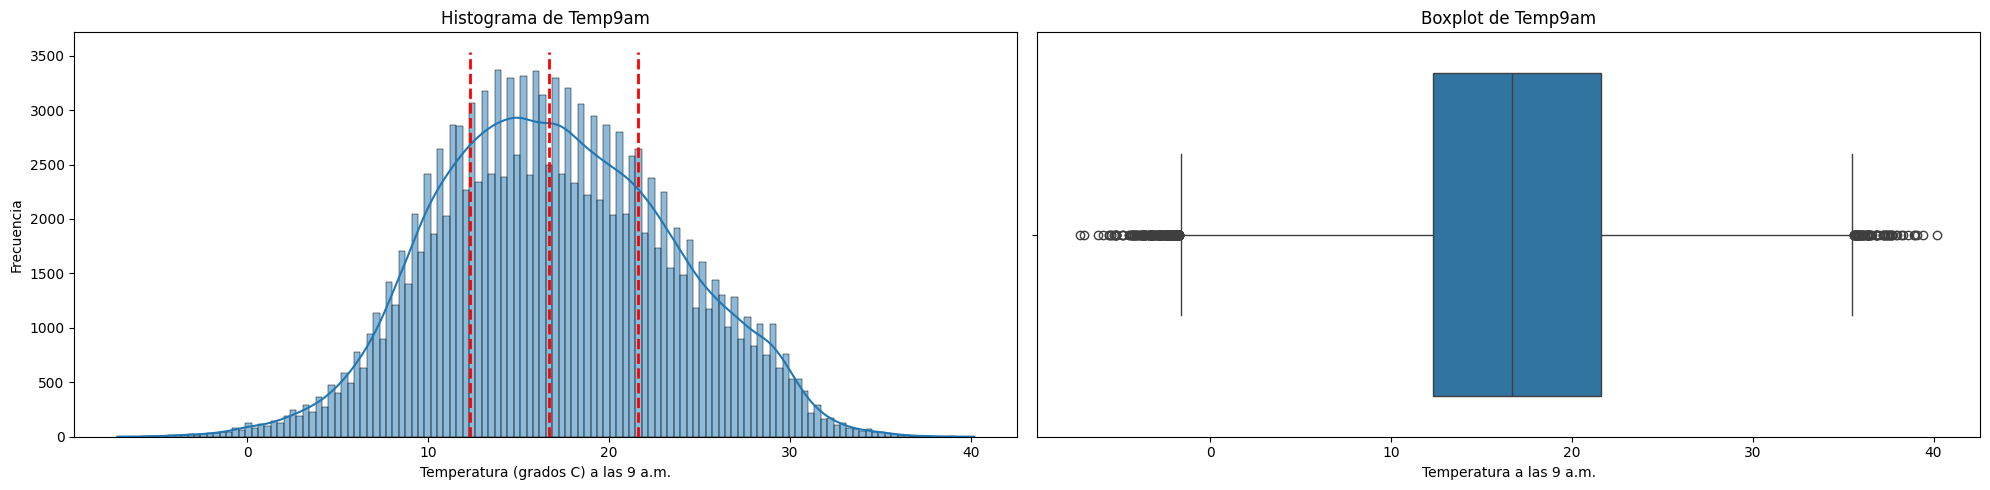

count    143646.000000
mean         16.992780
std           6.488045
min          -7.200000
25%          12.300000
50%          16.700000
75%          21.600000
max          40.200000
Name: Temp9am, dtype: float64

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Temp9am'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Temp9am')
axs[0].set_xlabel('Temperatura (grados C) a las 9 a.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Temp9am'].quantile(0.25)
q2 = weather_data['Temp9am'].quantile(0.5)
q3 = weather_data['Temp9am'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Temp9am'], ax=axs[1])
axs[1].set_title('Boxplot de Temp9am')
axs[1].set_xlabel('Temperatura a las 9 a.m.')

plt.tight_layout()
plt.show()

weather_data['Temp9am'].describe()

### Temp3pm

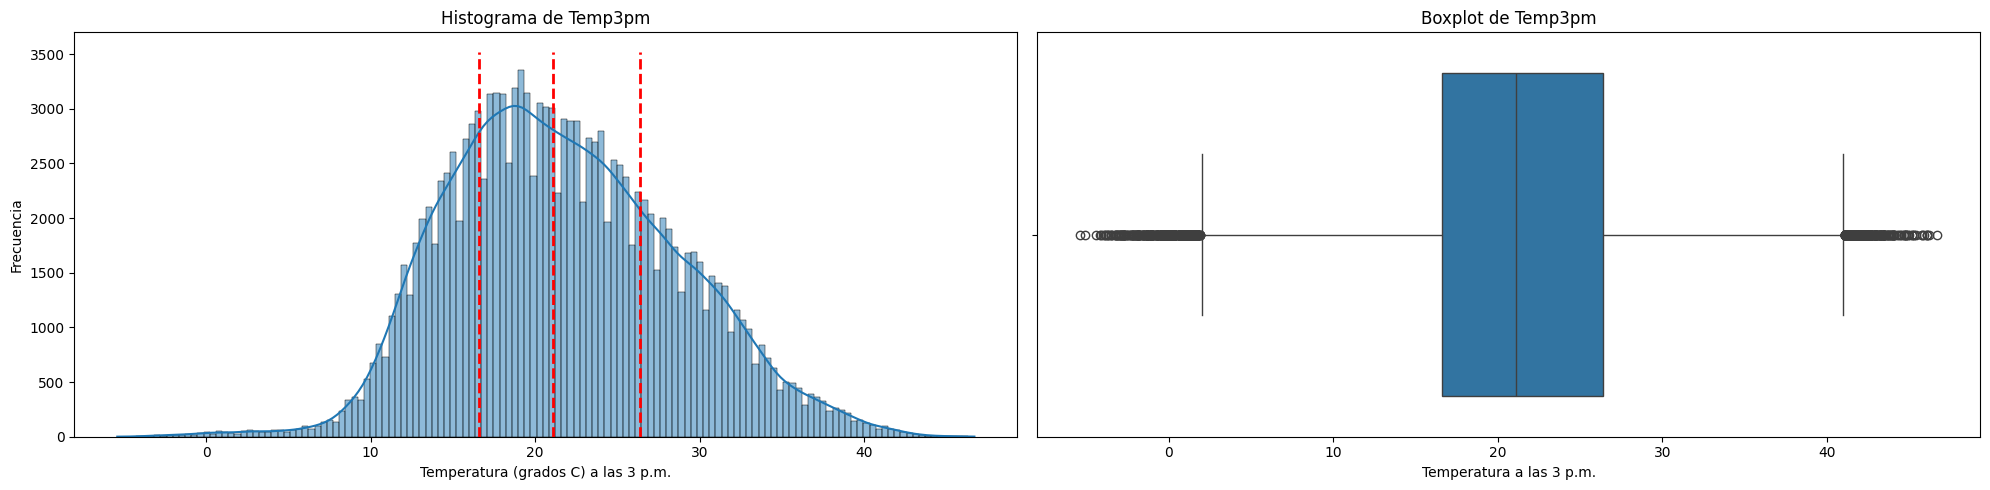

count    141805.000000
mean         21.685249
std           6.936358
min          -5.400000
25%          16.600000
50%          21.100000
75%          26.400000
max          46.700000
Name: Temp3pm, dtype: float64

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))


# Histograma
sns.histplot(weather_data['Temp3pm'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Temp3pm')
axs[0].set_xlabel('Temperatura (grados C) a las 3 p.m.')
axs[0].set_ylabel('Frecuencia')

# Calcular cuartiles
q1 = weather_data['Temp3pm'].quantile(0.25)
q2 = weather_data['Temp3pm'].quantile(0.5)
q3 = weather_data['Temp3pm'].quantile(0.75)

# Agregue líneas de cuartil con ymin e ymax establecidos en todo el rango y del gráfico
axs[0].vlines([q1, q2, q3], color='red', linestyles='dashed', linewidths=2,
              ymin=axs[0].get_ylim()[0], ymax=axs[0].get_ylim()[1])

# Boxplot
sns.boxplot(x=weather_data['Temp3pm'], ax=axs[1])
axs[1].set_title('Boxplot de Temp3pm')
axs[1].set_xlabel('Temperatura a las 3 p.m.')

plt.tight_layout()
plt.show()

weather_data['Temp3pm'].describe()

### RainToday

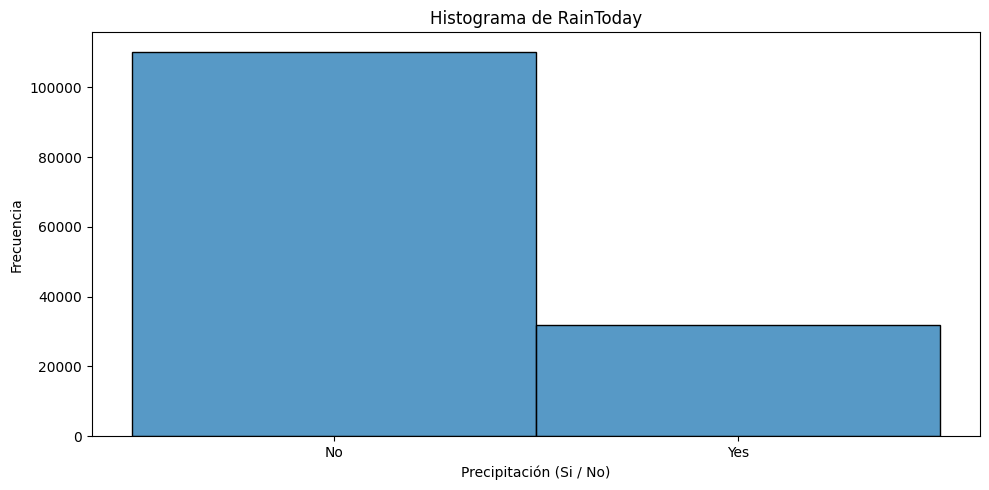

count     142152
unique         2
top           No
freq      110276
Name: RainToday, dtype: object

In [28]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(weather_data['RainToday'])
axs.set_title('Histograma de RainToday')
axs.set_xlabel('Precipitación (Si / No)')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

weather_data['RainToday'].describe()

### RainTomorrow

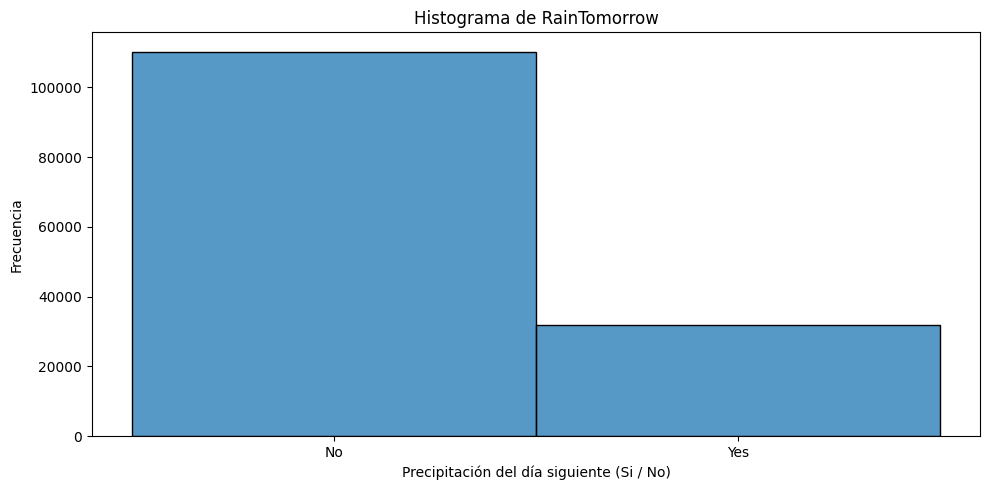

count     142153
unique         2
top           No
freq      110281
Name: RainTomorrow, dtype: object

In [29]:
fig, axs = plt.subplots(figsize=(10, 5))

# Histograma
sns.histplot(weather_data['RainTomorrow'])
axs.set_title('Histograma de RainTomorrow')
axs.set_xlabel('Precipitación del día siguiente (Si / No)')
axs.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

weather_data['RainTomorrow'].describe()

### RainfallTomorrow

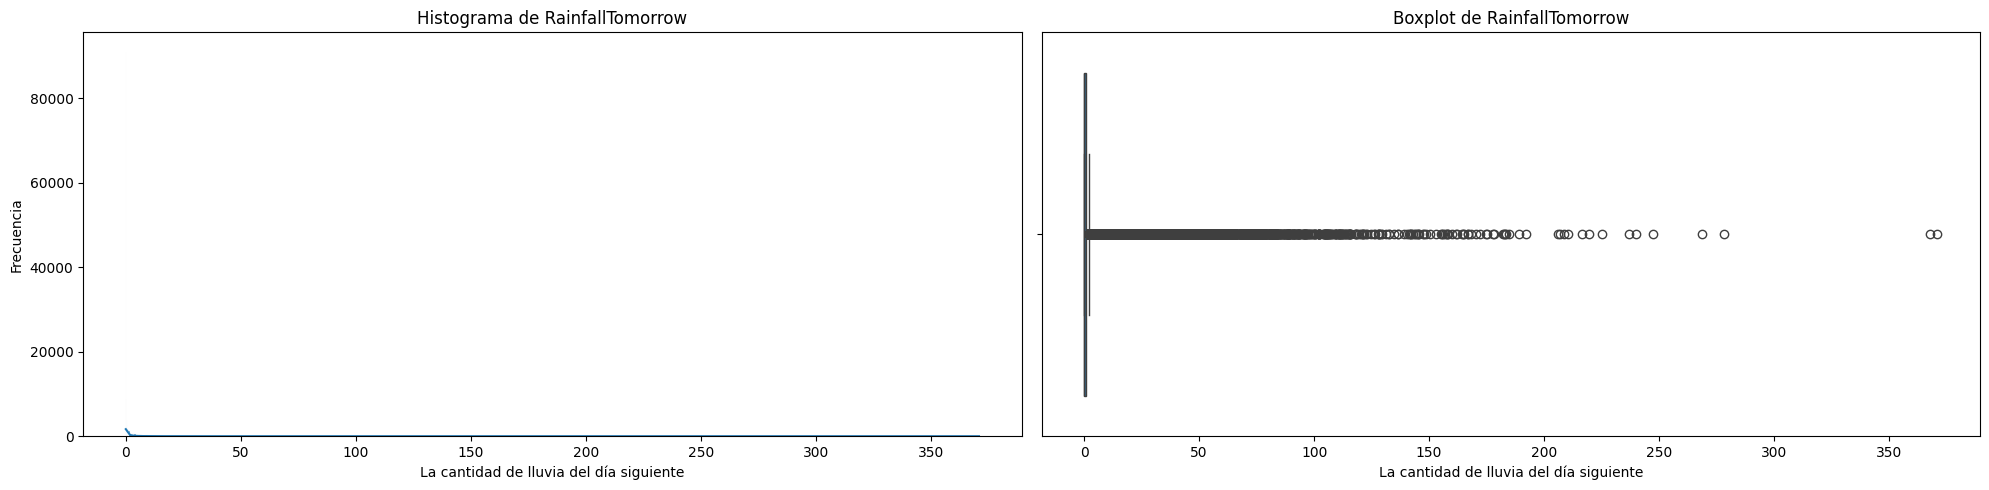

count    142153.000000
mean          2.361242
std           8.479084
min           0.000000
25%           0.000000
50%           0.000000
75%           0.800000
max         371.000000
Name: RainfallTomorrow, dtype: float64

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['RainfallTomorrow'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de RainfallTomorrow')
axs[0].set_xlabel('La cantidad de lluvia del día siguiente')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['RainfallTomorrow'], ax=axs[1])
axs[1].set_title('Boxplot de RainfallTomorrow')
axs[1].set_xlabel('La cantidad de lluvia del día siguiente')

plt.tight_layout()
plt.show()

weather_data['RainfallTomorrow'].describe()

### Otros

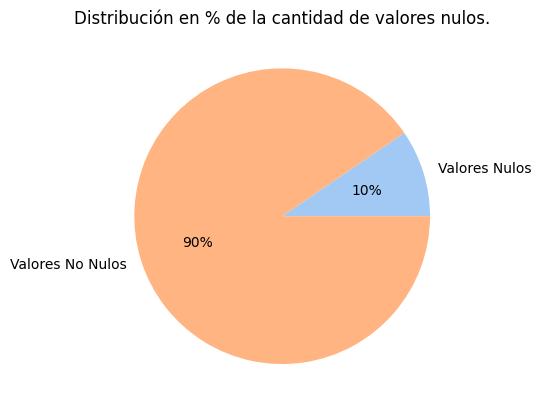

In [31]:
# Calcula el número total de valores (nulos y no nulos)
total_valores = np.product(weather_data.shape)

# Calcula el número de valores nulos
valores_nulos = weather_data.isnull().sum().sum()

# Calcula el número de valores no nulos
valores_no_nulos = total_valores - valores_nulos

# Crea una lista con los valores para el gráfico
datos = [valores_nulos, valores_no_nulos]

# Crea una lista con las etiquetas para el gráfico
etiquetas = ['Valores Nulos', 'Valores No Nulos']

colors = sns.color_palette("pastel")

plt.title('Distribución en % de la cantidad de valores nulos.')
plt.pie(datos, labels=etiquetas, colors=colors, autopct='%.0f%%')
plt.show()

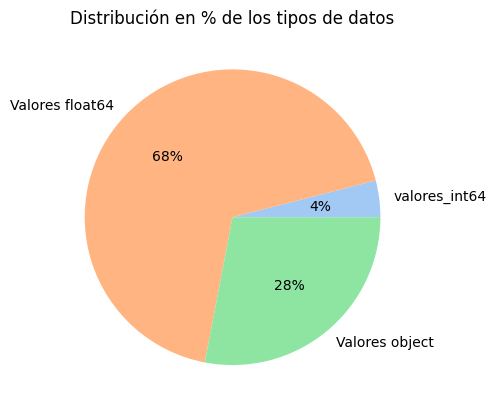

In [32]:
# Calcula el número de valores que son de tipo int64
valores_int64 = (weather_data.dtypes == 'int64').sum()

# Calcula el número de valores que son de tipo float64
valores_float64 = (weather_data.dtypes == 'float64').sum()

# Calcula el número de valores que son de tipo object
valores_object = (weather_data.dtypes == 'object').sum()

# Crea una lista con los valores para el gráfico
datos = [valores_int64, valores_float64, valores_object]

# Crea una lista con las etiquetas para el gráfico
etiquetas = ['valores_int64', 'Valores float64', 'Valores object']

colors = sns.color_palette("pastel")

plt.title('Distribución en % de los tipos de datos')
plt.pie(datos, labels=etiquetas, colors=colors, autopct='%.0f%%')
plt.show()

## Conclusiones

### Columnas
- Date: Fecha de observación.

        Debemos eliminarla porque no contiene información relevante.
        
- Location: El nombre de la ubicación de la estación meteorológica.

        Debemos descartar todas las ubicaciones que no nos interesen y luego las restantes asumirlas como una misma y única, para poder posteriormente eliminar Location y reducir la dimensionalidad para un modelo más simple.

- MinTemp: La temperatura mínima (°C).
- MaxTemp: La temperatura máxima (°C).

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la temperatura promedio durante el día (PromTemp = MaxTemp - MinTemp)

- Rainfall: La cantidad de lluvia registrada durante el día (mm).
- Evaporation: La evaporación del recipiente Clase A (mm) en el período de 24 horas a las 9 a.m.
- Sunshine: El número de horas de sol brillante en el día.
- WindGustDir: La dirección de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindGustSpeed: La velocidad (km/h) de la ráfaga de viento más fuerte en las 24 horas hasta la medianoche.
- WindDir9am: Dirección del viento a las 9 a.m.
- WindDir3pm: Dirección del viento a las 3 p.m.
- WindSpeed9am: Velocidad del viento (km/h) promediada de las 9 a.m.
- WindSpeed3pm: Velocidad del viento (km/h) promediada de las 3 p.m.
- Humidity9am: Humedad (porcentaje) a las 9 a.m.
- Humidity3pm: Humedad (porcentaje) a las 3 p.m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de humedad (ΔHumidity = Humidity3pm - Humidity9am)

- Pressure9am: La presión atmosférica (hPa) a las 9 a. m.
- Pressure3pm: La presión atmosférica (hPa) a las 3 p. m.

        Deberíamos tener en consideración la posibilidad de añadir a nuestro data set una nueva dimensión la cual sea la diferencia de presión atmosférica (ΔPressure = Pressure3pm - Pressure9am)

- Cloud9am: Fracción del cielo oscurecida por las nubes a las 9 a.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Cloud3pm: Fracción del cielo oscurecida por las nubes a las 3 p.m. Esto se mide en "oktas", que son una unidad de octavos. Registra cuantos
- Temp9am: Temperatura (grados C) a las 9 a.m.
- Temp3pm: Temperatura (grados C) a las 3 p.m.
- RainToday: Booleano: 1 si la precipitación (mm) en las 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0
- RainTomorrow: Booleano: 1 si la precipitación (mm) en las siguientes 24 horas hasta las 9 a. m. excede 1 mm; de lo contrario, 0

        Debemos eliminarla porque no contiene información relevante para el modelo de regresión lineal.

- RainfallTomorrow: La cantidad de lluvia del día siguiente en mm. Se utiliza para crear la variable de respuesta RainTomorrow. Una especie de medida del "riesgo".

### Outliers

Según nuestro análisis previo, las siguientes columnas presentan valores atípicos: **Rainfall**, **Evaporation**, **WindSpeed9am**, **WindSpeed3pm** y **RainfallTomorrow**. A excepción de **RainfallTomorrow** deberán tratarse todos los valores atípicos encontrados para así evitar que estos puedan sesgar o influir en la estimación de los parámetros del modelo, ya que un solo valor atípico podría arrastrar la línea de regresión hacia sí mismo, lo que resulta en una pendiente y una intersección que no representa correctamente la relación general entre las variables.

Para lograr esto deberemos tener en cuenta que los datos eliminados nunca deberán ser superiores al 10% de los datos totales, ya que si no, podríamos perder información valiosa que podría ser crucial para nuestro análisis. Además, una eliminación excesiva de datos podría llevar a un sesgo en los resultados del modelo. Por lo tanto, es esencial equilibrar la necesidad de limpiar los datos y preservar la integridad de nuestro conjunto de datos.

Sin embargo, cabe aclarar que estos valores atípicos podrían ser un error de Tipo I al rechazar incorrectamente la hipótesis nula de que el punto de datos no es un valor atípico. De igual manera, es necesario llevar a cabo un segundo análisis de valores atípicos posterior a la reducción de dimensionalidad, ya que al solo interesarnos en ciertas ubicaciones, las demás deberán ser descartadas, al igual que las columnas que no proporcionan información relevante para el modelo: Unnamed: 0, Date, Location.

# Reducción de dimensionalidad

In [4]:
weather_data

Unnamed: 0        Date Location  MinTemp  MaxTemp  Rainfall  \
0                0  2008-12-01   Albury     13.4     22.9       0.6   
1                1  2008-12-02   Albury      7.4     25.1       0.0   
2                2  2008-12-03   Albury     12.9     25.7       0.0   
3                3  2008-12-04   Albury      9.2     28.0       0.0   
4                4  2008-12-05   Albury     17.5     32.3       1.0   
...            ...         ...      ...      ...      ...       ...   
145407      145454  2017-06-20    Uluru      3.5     21.8       0.0   
145408      145455  2017-06-21    Uluru      2.8     23.4       0.0   
145409      145456  2017-06-22    Uluru      3.6     25.3       0.0   
145410      145457  2017-06-23    Uluru      5.4     26.9       0.0   
145411      145458  2017-06-24    Uluru      7.8     27.0       0.0   

        Evaporation  Sunshine WindGustDir  WindGustSpeed  ... Humidity3pm  \
0               NaN       NaN           W           44.0  ...        22.0   
1               NaN       NaN         WNW           44.0  ...        25.0   
2               NaN       NaN         WSW           46.0  ...        30.0   
3               NaN       NaN          NE           24.0  ...        16.0   
4               NaN       NaN           W           41.0  ...        33.0   
...             ...       ...         ...            ...  ...         ...   
145407          NaN       NaN           E           31.0  ...        27.0   
145408          NaN       NaN           E           31.0  ...        24.0   
145409          NaN       NaN         NNW           22.0  ...        21.0   
145410          NaN       NaN           N           37.0  ...        24.0   
145411          NaN       NaN          SE           28.0  ...        24.0   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
0           1007.7       1007.1       8.0       NaN     16.9     21.8   
1           1010.6       1007.8       NaN       NaN     17.2     24.3   
2           1007.6       1008.7       NaN       2.0     21.0     23.2   
3           1017.6       1012.8       NaN       NaN     18.1     26.5   
4           1010.8       1006.0       7.0       8.0     17.8     29.7   
...            ...          ...       ...       ...      ...      ...   
145407      1024.7       1021.2       NaN       NaN      9.4     20.9   
145408      1024.6       1020.3       NaN       NaN     10.1     22.4   
145409      1023.5       1019.1       NaN       NaN     10.9     24.5   
145410      1021.0       1016.8       NaN       NaN     12.5     26.1   
145411      1019.4       1016.5       3.0       2.0     15.1     26.0   

        RainToday  RainTomorrow  RainfallTomorrow  
0              No            No               0.0  
1              No            No               0.0  
2              No            No               0.0  
3              No            No               1.0  
4              No            No               0.2  
...           ...           ...               ...  
145407         No            No               0.0  
145408         No            No               0.0  
145409         No            No               0.0  
145410         No            No               0.0  
145411         No            No               0.0  

[145412 rows x 25 columns]

**145.412 filas**

Eliminamos las localidades que no nos interesan predecir

In [5]:
# Lista de ubicaciones deseadas
ubicaciones_deseadas = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

# Filtra el DataFrame para que solo contenga las ubicaciones deseadas
weather_data = weather_data[weather_data['Location'].isin(ubicaciones_deseadas)]

In [6]:
weather_data

Unnamed: 0        Date      Location  MinTemp  MaxTemp  Rainfall  \
6047          6049  2009-01-01         Cobar     17.9     35.2       0.0   
6048          6050  2009-01-02         Cobar     18.4     28.9       0.0   
6049          6051  2009-01-03         Cobar     15.5     34.1       0.0   
6050          6052  2009-01-04         Cobar     19.4     37.6       0.0   
6051          6053  2009-01-05         Cobar     21.9     38.4       0.0   
...            ...         ...           ...      ...      ...       ...   
102515      102547  2017-06-20  MountGambier      6.2     16.3       0.0   
102516      102548  2017-06-21  MountGambier      8.7     13.2       2.0   
102517      102549  2017-06-22  MountGambier      7.0     15.7       0.0   
102518      102550  2017-06-23  MountGambier      5.4     16.2       0.0   
102519      102551  2017-06-24  MountGambier      4.8     12.3       2.2   

        Evaporation  Sunshine WindGustDir  WindGustSpeed  ... Humidity3pm  \
6047           12.0      12.3         SSW           48.0  ...        13.0   
6048           14.8      13.0           S           37.0  ...         8.0   
6049           12.6      13.3          SE           30.0  ...         7.0   
6050           10.8      10.6         NNE           46.0  ...        22.0   
6051           11.4      12.2         WNW           31.0  ...        22.0   
...             ...       ...         ...            ...  ...         ...   
102515          NaN       NaN           N           41.0  ...        70.0   
102516          NaN       NaN           S           20.0  ...        82.0   
102517          NaN       NaN           N           31.0  ...        67.0   
102518          NaN       NaN           N           37.0  ...        70.0   
102519          NaN       NaN           W           28.0  ...        70.0   

       Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
6047        1006.3       1004.4       2.0       5.0     26.6     33.4   
6048        1012.9       1012.1       1.0       1.0     20.3     27.0   
6049           NaN       1011.6       NaN       1.0      NaN     32.7   
6050        1012.3       1009.2       1.0       6.0     28.7     34.9   
6051        1012.7       1009.1       1.0       5.0     29.1     35.6   
...            ...          ...       ...       ...      ...      ...   
102515      1026.3       1024.1       NaN       NaN      8.7     15.5   
102516      1029.2       1028.3       NaN       8.0     11.1     12.0   
102517      1027.0       1022.4       8.0       NaN     10.0     14.9   
102518      1017.0       1014.4       8.0       4.0      6.4     14.9   
102519      1020.0       1018.0       5.0       8.0      8.2     11.5   

        RainToday  RainTomorrow  RainfallTomorrow  
6047           No            No               0.0  
6048           No            No               0.0  
6049           No            No               0.0  
6050           No            No               0.0  
6051           No            No               0.0  
...           ...           ...               ...  
102515         No           Yes               2.0  
102516        Yes            No               0.0  
102517         No            No               0.0  
102518         No           Yes               2.2  
102519        Yes            No               0.6  

[28233 rows x 25 columns]

**28.233 filas**

Dejamos a un lado las siguientes columnas:
- Location:

         Eliminaremos esta columna, ya que vamos a tomar las ubicaciones: 'Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' como la si fueran una misma y así simplificar el modelo.

- Unnamed: 0:

         Eliminaremos esta columna, ya que no aporta nada de información al modelo.
        
- RainTomorrow:

         No la utilizaremos a esta columna, ya que no contiene información relevante para el modelo de regresión lineal.


In [7]:
weather_data = weather_data.drop(['Unnamed: 0', 'Location'], axis=1)

weather_data

Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
6047    2009-01-01     17.9     35.2       0.0         12.0      12.3   
6048    2009-01-02     18.4     28.9       0.0         14.8      13.0   
6049    2009-01-03     15.5     34.1       0.0         12.6      13.3   
6050    2009-01-04     19.4     37.6       0.0         10.8      10.6   
6051    2009-01-05     21.9     38.4       0.0         11.4      12.2   
...            ...      ...      ...       ...          ...       ...   
102515  2017-06-20      6.2     16.3       0.0          NaN       NaN   
102516  2017-06-21      8.7     13.2       2.0          NaN       NaN   
102517  2017-06-22      7.0     15.7       0.0          NaN       NaN   
102518  2017-06-23      5.4     16.2       0.0          NaN       NaN   
102519  2017-06-24      4.8     12.3       2.2          NaN       NaN   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  \
6047           SSW           48.0        ENE         SW  ...         13.0   
6048             S           37.0        SSE        SSE  ...          8.0   
6049            SE           30.0        NaN          N  ...          7.0   
6050           NNE           46.0        NNE        NNW  ...         22.0   
6051           WNW           31.0        WNW        WSW  ...         22.0   
...            ...            ...        ...        ...  ...          ...   
102515           N           41.0          N         NW  ...         70.0   
102516           S           20.0        NaN         SE  ...         82.0   
102517           N           31.0          N        NNW  ...         67.0   
102518           N           37.0        NNW          W  ...         70.0   
102519           W           28.0        NNW          W  ...         70.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
6047         1006.3       1004.4       2.0       5.0     26.6     33.4   
6048         1012.9       1012.1       1.0       1.0     20.3     27.0   
6049            NaN       1011.6       NaN       1.0      NaN     32.7   
6050         1012.3       1009.2       1.0       6.0     28.7     34.9   
6051         1012.7       1009.1       1.0       5.0     29.1     35.6   
...             ...          ...       ...       ...      ...      ...   
102515       1026.3       1024.1       NaN       NaN      8.7     15.5   
102516       1029.2       1028.3       NaN       8.0     11.1     12.0   
102517       1027.0       1022.4       8.0       NaN     10.0     14.9   
102518       1017.0       1014.4       8.0       4.0      6.4     14.9   
102519       1020.0       1018.0       5.0       8.0      8.2     11.5   

        RainToday  RainTomorrow  RainfallTomorrow  
6047           No            No               0.0  
6048           No            No               0.0  
6049           No            No               0.0  
6050           No            No               0.0  
6051           No            No               0.0  
...           ...           ...               ...  
102515         No           Yes               2.0  
102516        Yes            No               0.0  
102517         No            No               0.0  
102518         No           Yes               2.2  
102519        Yes            No               0.6  

[28233 rows x 23 columns]

# Train y Test

Dividimos el set de datos en train y test antes de realizar la imputación de nulos para evitar la generación de un data leakage

Esto lo hacemos a través de la fecha, ya que de este modo podemos mantener la integridad temporal de nuestros datos. Al dividir los datos en conjuntos de entrenamiento y prueba basándonos en una fecha específica, estamos respetando el orden cronológico de los eventos. Esto es especialmente importante en series temporales y en problemas donde la secuencia y la temporalidad importan.

Por otro lado, si utilizáramos train_test_split de manera aleatoria, podríamos terminar con datos de prueba que se filtraron en el conjunto de entrenamiento después de la imputación. Esto podría llevar a un modelo sobreajustado que funciona bien en los datos de entrenamiento, pero falla al generalizar en datos nuevos o futuros.

In [8]:
# Convierto la columna 'Date' a tipo datetime
weather_data["Date"] = pd.to_datetime(weather_data["Date"])

# Mostrar la primera y última fecha
primera_fecha = weather_data['Date'].min()
ultima_fecha = weather_data['Date'].max()

print("Primera fecha:", primera_fecha)
print("Última fecha:", ultima_fecha)

# Calcular la fecha que abarque el 80% de los datos
fecha_80porciento = weather_data['Date'].quantile(0.8)

print("Fecha que abarca el 80% de los datos:", fecha_80porciento)

Primera fecha: 2007-11-01 00:00:00
Última fecha: 2017-06-24 00:00:00
Fecha que abarca el 80% de los datos: 2015-10-06 00:00:00


In [9]:
# Dividir los datos en conjuntos de entrenamiento y prueba basados en la fecha
train = weather_data[weather_data['Date'] <= fecha_80porciento]

test = weather_data[weather_data['Date'] > fecha_80porciento]

Ya que la fecha no aporta nada más de valor, procedemos a eliminarla para reducir un poco más la dimensionalidad y así la complejidad de nuestro modelo.

In [10]:
train = train.drop('Date', axis=1)

test = test.drop('Date', axis=1)

In [11]:
weather_data

Date  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
6047   2009-01-01     17.9     35.2       0.0         12.0      12.3   
6048   2009-01-02     18.4     28.9       0.0         14.8      13.0   
6049   2009-01-03     15.5     34.1       0.0         12.6      13.3   
6050   2009-01-04     19.4     37.6       0.0         10.8      10.6   
6051   2009-01-05     21.9     38.4       0.0         11.4      12.2   
...           ...      ...      ...       ...          ...       ...   
102515 2017-06-20      6.2     16.3       0.0          NaN       NaN   
102516 2017-06-21      8.7     13.2       2.0          NaN       NaN   
102517 2017-06-22      7.0     15.7       0.0          NaN       NaN   
102518 2017-06-23      5.4     16.2       0.0          NaN       NaN   
102519 2017-06-24      4.8     12.3       2.2          NaN       NaN   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  \
6047           SSW           48.0        ENE         SW  ...         13.0   
6048             S           37.0        SSE        SSE  ...          8.0   
6049            SE           30.0        NaN          N  ...          7.0   
6050           NNE           46.0        NNE        NNW  ...         22.0   
6051           WNW           31.0        WNW        WSW  ...         22.0   
...            ...            ...        ...        ...  ...          ...   
102515           N           41.0          N         NW  ...         70.0   
102516           S           20.0        NaN         SE  ...         82.0   
102517           N           31.0          N        NNW  ...         67.0   
102518           N           37.0        NNW          W  ...         70.0   
102519           W           28.0        NNW          W  ...         70.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
6047         1006.3       1004.4       2.0       5.0     26.6     33.4   
6048         1012.9       1012.1       1.0       1.0     20.3     27.0   
6049            NaN       1011.6       NaN       1.0      NaN     32.7   
6050         1012.3       1009.2       1.0       6.0     28.7     34.9   
6051         1012.7       1009.1       1.0       5.0     29.1     35.6   
...             ...          ...       ...       ...      ...      ...   
102515       1026.3       1024.1       NaN       NaN      8.7     15.5   
102516       1029.2       1028.3       NaN       8.0     11.1     12.0   
102517       1027.0       1022.4       8.0       NaN     10.0     14.9   
102518       1017.0       1014.4       8.0       4.0      6.4     14.9   
102519       1020.0       1018.0       5.0       8.0      8.2     11.5   

        RainToday  RainTomorrow  RainfallTomorrow  
6047           No            No               0.0  
6048           No            No               0.0  
6049           No            No               0.0  
6050           No            No               0.0  
6051           No            No               0.0  
...           ...           ...               ...  
102515         No           Yes               2.0  
102516        Yes            No               0.0  
102517         No            No               0.0  
102518         No           Yes               2.2  
102519        Yes            No               0.6  

[28233 rows x 23 columns]

**28233  filas**

In [12]:
train

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
6047       17.9     35.2       0.0         12.0      12.3         SSW   
6048       18.4     28.9       0.0         14.8      13.0           S   
6049       15.5     34.1       0.0         12.6      13.3          SE   
6050       19.4     37.6       0.0         10.8      10.6         NNE   
6051       21.9     38.4       0.0         11.4      12.2         WNW   
...         ...      ...       ...          ...       ...         ...   
101888     10.7     25.3       0.0          3.2       8.0         NNW   
101889     10.7     29.5       0.0          7.2       8.4         NNW   
101890      7.8     25.2       0.0          7.2       7.8           W   
101891      8.7     32.4       0.0          4.0      11.4          NW   
101892     16.6     20.7       0.0         12.0       4.6           W   

        WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity3pm  \
6047             48.0        ENE         SW           6.0  ...         13.0   
6048             37.0        SSE        SSE          19.0  ...          8.0   
6049             30.0        NaN          N           NaN  ...          7.0   
6050             46.0        NNE        NNW          30.0  ...         22.0   
6051             31.0        WNW        WSW           6.0  ...         22.0   
...               ...        ...        ...           ...  ...          ...   
101888           41.0          N        NNW          20.0  ...         37.0   
101889           57.0        NNW        NNW          26.0  ...         18.0   
101890           44.0         NW        WNW           9.0  ...         44.0   
101891           76.0          N        NNW          17.0  ...         15.0   
101892           52.0        WNW        WSW          17.0  ...         65.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
6047         1006.3       1004.4       2.0       5.0     26.6     33.4   
6048         1012.9       1012.1       1.0       1.0     20.3     27.0   
6049            NaN       1011.6       NaN       1.0      NaN     32.7   
6050         1012.3       1009.2       1.0       6.0     28.7     34.9   
6051         1012.7       1009.1       1.0       5.0     29.1     35.6   
...             ...          ...       ...       ...      ...      ...   
101888       1031.8       1027.6       3.0       NaN     13.1     24.7   
101889       1023.6       1019.4       2.0       6.0     22.0     28.2   
101890       1021.9       1020.6       NaN       NaN     13.4     24.6   
101891       1017.3       1013.8       6.0       1.0     18.4     32.0   
101892       1012.3       1019.9       5.0       7.0     18.7     15.1   

        RainToday  RainTomorrow RainfallTomorrow  
6047           No            No              0.0  
6048           No            No              0.0  
6049           No            No              0.0  
6050           No            No              0.0  
6051           No            No              0.0  
...           ...           ...              ...  
101888         No            No              0.0  
101889         No            No              0.0  
101890         No            No              0.0  
101891         No            No              0.0  
101892         No            No              0.0  

[22590 rows x 22 columns]

**28233 * 0.8 = 22590 filas**

In [13]:
test

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
8428       18.4     34.1       0.0          8.2       NaN           S   
8429       15.6     32.0       0.0          7.4       NaN          NE   
8430       17.8     32.7       0.0         10.6       NaN           S   
8431       17.5     32.4       2.6          9.2       NaN         ENE   
8432       17.3     28.5       1.6          6.2       NaN           W   
...         ...      ...       ...          ...       ...         ...   
102515      6.2     16.3       0.0          NaN       NaN           N   
102516      8.7     13.2       2.0          NaN       NaN           S   
102517      7.0     15.7       0.0          NaN       NaN           N   
102518      5.4     16.2       0.0          NaN       NaN           N   
102519      4.8     12.3       2.2          NaN       NaN           W   

        WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity3pm  \
8428             35.0          S          S          15.0  ...         17.0   
8429             43.0        ENE        ENE          28.0  ...         23.0   
8430             46.0        NNE          E          17.0  ...         19.0   
8431             37.0          E        SSE          17.0  ...         20.0   
8432             54.0        NNE        ENE          17.0  ...         42.0   
...               ...        ...        ...           ...  ...          ...   
102515           41.0          N         NW          24.0  ...         70.0   
102516           20.0        NaN         SE           0.0  ...         82.0   
102517           31.0          N        NNW          13.0  ...         67.0   
102518           37.0        NNW          W          24.0  ...         70.0   
102519           28.0        NNW          W           7.0  ...         70.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
8428         1026.0       1023.9       1.0       4.0     21.6     33.1   
8429         1030.3       1027.0       1.0       1.0     18.7     31.0   
8430         1030.5       1026.5       1.0       1.0     22.2     31.9   
8431         1026.9       1022.8       3.0       7.0     23.5     30.5   
8432         1022.2       1019.5       5.0       3.0     20.3     25.4   
...             ...          ...       ...       ...      ...      ...   
102515       1026.3       1024.1       NaN       NaN      8.7     15.5   
102516       1029.2       1028.3       NaN       8.0     11.1     12.0   
102517       1027.0       1022.4       8.0       NaN     10.0     14.9   
102518       1017.0       1014.4       8.0       4.0      6.4     14.9   
102519       1020.0       1018.0       5.0       8.0      8.2     11.5   

        RainToday  RainTomorrow RainfallTomorrow  
8428           No            No              0.0  
8429           No            No              0.0  
8430           No           Yes              2.6  
8431          Yes           Yes              1.6  
8432          Yes           Yes              1.2  
...           ...           ...              ...  
102515         No           Yes              2.0  
102516        Yes            No              0.0  
102517         No            No              0.0  
102518         No           Yes              2.2  
102519        Yes            No              0.6  

[5643 rows x 22 columns]

**28233 * 0.2 = 5643  filas**

# Balanceo del dataset

## Regresión

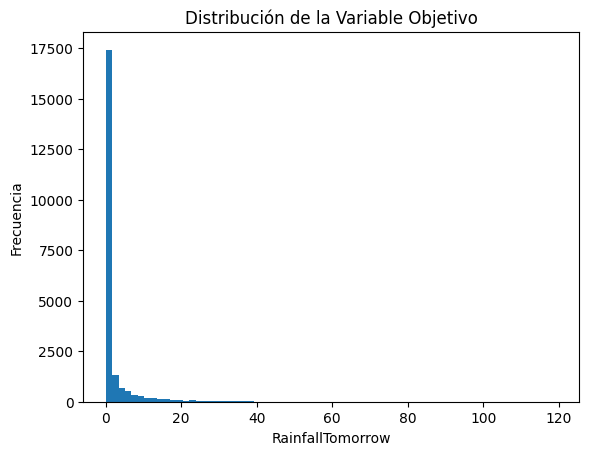

In [14]:
plt.hist(train['RainfallTomorrow'], bins=70)
plt.xlabel('RainfallTomorrow')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Variable Objetivo')
plt.show()

Se observa que el histograma tiene un sesgo positivo, ya que la mayoría de los valores están cerca de 0, lo que indica que hay muchos días con poca o ninguna lluvia.

## Clasificación

In [15]:
# Contar las instancias de cada clase en la variable objetivo 'RainTomorrow'
conteo_clases = train['RainTomorrow'].value_counts()

# Mostrar el conteo de clases
print(conteo_clases)

RainTomorrow
No     16656
Yes     5192
Name: count, dtype: int64


In [16]:
# Contar las instancias de cada clase en la variable objetivo 'RainTomorrow'
conteo_clases = test['RainTomorrow'].value_counts()

# Mostrar el conteo de clases
print(conteo_clases)

RainTomorrow
No     4121
Yes    1279
Name: count, dtype: int64


Vemos que si existe un desbalanceo en los datos. Esto lo corregiremos mas adelante en el preprocesamiento de los datos. 

# Datos faltantes

## Eliminación de datos faltantes de Train

Verificamos si existen filas que contengan solo valores nulos.

In [17]:
# Contamos el número total de filas que tengan todos sus valores como nulos en train
train_nulas = train.isnull().all(axis=1).sum()

train_nulas

0

Vemos que no tiene una fila donde todos sus valores son nulos, así que hace falta realizar ninguna acción.

## Eliminación de datos faltantes de Test

Verificamos si existen filas que contengan solo valores nulos.

In [18]:
# Contamos el número total de filas que tengan todos sus valores como nulos en test
test_nulas = test.isnull().all(axis=1).sum()

test_nulas

1

Vemos que si tiene una fila donde todos sus valores son nulos, así que la eliminamos.

In [19]:
test = test.dropna(how='all')

Verificamos que se haya borrado correctamente y que no queden filas que contengan todos sus valores nulos.

In [20]:
# Contamos el número total de filas que tengan todos sus valores como nulos en test
test_nulas = test.isnull().all(axis=1).sum()

test_nulas

0

## Completado de datos

**Datos categoricos:** Usaremos la mediana para rellenar los datos faltantes, ya que la mediana es una medida de tendencia central que no se ve afectada por los valores extremos o atípicos que podrían sesgar y distorsionar mis resultados.

**Datos continuos:**  Usaremos la moda para rellenar los datos faltantes, ya que, dado que las variables categóricas no son numéricas, medidas como la media y la mediana no tienen sentido en este contexto.  Al rellenar los datos faltantes con la moda, estoy esencialmente asumiendo que la categoría más común es la más probable de ocurrir en los datos faltantes. Esto puede no ser siempre el caso, pero es una suposición razonable en ausencia de información adicional.

### Completado de datos de Train

Verificamos si existen valores faltantes

In [21]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']].isnull().sum()

WindGustDir     1571
WindDir9am      1415
WindDir3pm       414
RainToday        742
RainTomorrow     742
dtype: int64

Vemos que si hay datos faltantes, por lo tanto, rellenamos los datos faltantes con la moda.

In [22]:
train['WindGustDir'].fillna(train['WindGustDir'].mode()[0], inplace=True)
train['WindDir9am'].fillna(train['WindDir9am'].mode()[0], inplace=True)
train['WindDir3pm'].fillna(train['WindDir3pm'].mode()[0], inplace=True)
train['RainToday'].fillna(train['RainToday'].mode()[0], inplace=True)
train['RainTomorrow'].fillna(train['RainTomorrow'].mode()[0], inplace=True)

C:\Users\src4\AppData\Local\Temp\ipykernel_24520\2343193607.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['WindGustDir'].fillna(train['WindGustDir'].mode()[0], inplace=True)
C:\Users\src4\AppData\Local\Temp\ipykernel_24520\2343193607.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

Verificamos que se hayan rellenado los valores faltantes con la moda correctamente y que no queden valores nulos.

In [23]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']].isnull().sum()

WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

Verificamos si existen valores numéricos faltantes.

In [24]:
columns_to_check = [col for col in train.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
train[columns_to_check].isnull().sum()

MinTemp              357
MaxTemp              344
Rainfall             742
Evaporation         2016
Sunshine            3962
WindGustSpeed       1568
WindSpeed9am         350
WindSpeed3pm         336
Humidity9am          605
Humidity3pm          561
Pressure9am          625
Pressure3pm          618
Cloud9am            7179
Cloud3pm            7469
Temp9am              372
Temp3pm              366
RainfallTomorrow     742
dtype: int64

Rellenamos los datos faltantes con la mediana.

In [25]:
columns_to_fill = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                   'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                   'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
                   'Temp3pm', 'RainfallTomorrow']

train_filled = train.copy()
train[columns_to_fill] = train_filled[columns_to_fill].fillna(train_filled[columns_to_fill].median())

Verificamos que se hayan rellenado los valores faltantes con la mediana correctamente y que no queden valores nulos.

In [26]:
columns_to_check = [col for col in train.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
train[columns_to_check].isnull().sum()

MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustSpeed       0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainfallTomorrow    0
dtype: int64

### Completado de datos de Test

Verificamos si existen valores categoricos faltantes.

In [27]:
test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']].isnull().sum()

WindGustDir      73
WindDir9am      232
WindDir3pm       22
RainToday       243
RainTomorrow    242
dtype: int64

Vemos que si hay datos faltantes, por lo tanto, rellenamos los datos faltantes con la moda.

In [28]:
test['WindGustDir'].fillna(test['WindGustDir'].mode()[0], inplace=True)
test['WindDir9am'].fillna(test['WindDir9am'].mode()[0], inplace=True)
test['WindDir3pm'].fillna(test['WindDir3pm'].mode()[0], inplace=True)
test['RainToday'].fillna(test['RainToday'].mode()[0], inplace=True)
test['RainTomorrow'].fillna(test['RainTomorrow'].mode()[0], inplace=True)

C:\Users\src4\AppData\Local\Temp\ipykernel_24520\2205085796.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['WindGustDir'].fillna(test['WindGustDir'].mode()[0], inplace=True)
C:\Users\src4\AppData\Local\Temp\ipykernel_24520\2205085796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['WindGustDir'].fillna(test['WindGustDir'].mo

Verificamos que se hayan rellenado los valores faltantes con la moda correctamente y que no queden valores nulos.

In [29]:
test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']].isnull().sum()

WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

Verificamos si existen valores numéricos faltantes.

In [30]:
columns_to_check = [col for col in test.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
test[columns_to_check].isnull().sum()

MinTemp              212
MaxTemp              213
Rainfall             243
Evaporation         2336
Sunshine            2750
WindGustSpeed         73
WindSpeed9am           7
WindSpeed3pm           3
Humidity9am          334
Humidity3pm          328
Pressure9am          213
Pressure3pm          210
Cloud9am            2187
Cloud3pm            2080
Temp9am              212
Temp3pm              209
RainfallTomorrow     242
dtype: int64

Rellenamos los datos faltantes con la mediana.

In [31]:
columns_to_fill = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                   'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                   'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
                   'Temp3pm', 'RainfallTomorrow']

test_filled = test.copy()
test[columns_to_fill] = test_filled[columns_to_fill].fillna(test_filled[columns_to_fill].median())

C:\Users\src4\AppData\Local\Temp\ipykernel_24520\3321180541.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[columns_to_fill] = test_filled[columns_to_fill].fillna(test_filled[columns_to_fill].median())


Verificamos que se hayan rellenado los valores faltantes con la mediana correctamente y que no queden valores nulos.

In [32]:
columns_to_check = [col for col in test.columns if col not in ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]
test[columns_to_check].isnull().sum()

MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustSpeed       0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainfallTomorrow    0
dtype: int64

# Estandarización

In [33]:
# Crear el estandarizador
scaler = StandardScaler()

## Estandarización de Train

In [34]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                          'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                          'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
                          'Temp3pm', 'RainfallTomorrow']

# Aplicar la estandarización a las columnas seleccionadas
train[columns_to_standardize] = scaler.fit_transform(train[columns_to_standardize])

In [35]:
train

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
6047    1.215933  2.079155 -0.314848     2.137163  1.521298         SSW   
6048    1.304671  1.115813 -0.314848     2.948921  1.720741           S   
6049    0.789993  1.910952 -0.314848     2.311111  1.806216          SE   
6050    1.482146  2.446142 -0.314848     1.789267  1.036936         NNE   
6051    1.925833  2.568471 -0.314848     1.963215  1.492806         WNW   
...          ...       ...       ...          ...       ...         ...   
101888 -0.061887  0.565332 -0.314848    -0.414076  0.296148         NNW   
101889 -0.061887  1.207560 -0.314848     0.745578  0.410115         NNW   
101890 -0.576564  0.550041 -0.314848     0.745578  0.239164           W   
101891 -0.416837  1.651003 -0.314848    -0.182145  1.264871          NW   
101892  0.985216 -0.138060 -0.314848     2.137163 -0.672576           W   

        WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity3pm  \
6047         0.430991        ENE         SW     -0.975070  ...    -1.898636   
6048        -0.366508        SSE        SSE      0.387503  ...    -2.152436   
6049        -0.874008          N          N     -0.241377  ...    -2.203196   
6050         0.285991        NNE        NNW      1.540449  ...    -1.441796   
6051        -0.801508        WNW        WSW     -0.975070  ...    -1.441796   
...               ...        ...        ...           ...  ...          ...   
101888      -0.076508          N        NNW      0.492316  ...    -0.680397   
101889       1.083491        NNW        NNW      1.121196  ...    -1.644836   
101890       0.140991         NW        WNW     -0.660630  ...    -0.325077   
101891       2.460989          N        NNW      0.177876  ...    -1.797116   
101892       0.720991        WNW        WSW      0.177876  ...     0.740882   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  \
6047      -1.657851    -1.662427 -1.250081 -0.055960  2.031383  2.077791   
6048      -0.752604    -0.585202 -1.663547 -1.851608  0.906131  1.075637   
6049       0.015485    -0.655152  0.403784 -1.851608 -0.094094  1.968180   
6050      -0.834899    -0.990910 -1.663547  0.392952  2.406468  2.312670   
6051      -0.780036    -1.004900 -1.663547 -0.055960  2.477912  2.422281   
...             ...          ...       ...       ...       ...       ...   
101888     1.839696     1.583238 -0.836615  0.392952 -0.379873  0.715488   
101889     0.714995     0.436063 -1.250081  0.392952  1.209770  1.263541   
101890     0.481825     0.603942  0.403784  0.392952 -0.326289  0.699830   
101891    -0.149105    -0.347373  0.403784 -1.851608  0.566769  1.858569   
101892    -0.834899     0.506013 -0.009682  0.841864  0.620352 -0.787741   

        RainToday  RainTomorrow RainfallTomorrow  
6047           No            No        -0.314692  
6048           No            No        -0.314692  
6049           No            No        -0.314692  
6050           No            No        -0.314692  
6051           No            No        -0.314692  
...           ...           ...              ...  
101888         No            No        -0.314692  
101889         No            No        -0.314692  
101890         No            No        -0.314692  
101891         No            No        -0.314692  
101892         No            No        -0.314692  

[22590 rows x 22 columns]

## Estandarización de Test

In [36]:
# Seleccionar las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                          'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                          'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
                          'Temp3pm', 'RainfallTomorrow']

# Aplicar la estandarización a las columnas seleccionadas
test[columns_to_standardize] = scaler.transform(test[columns_to_standardize])

C:\Users\src4\AppData\Local\Temp\ipykernel_24520\3918362874.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[columns_to_standardize] = scaler.transform(test[columns_to_standardize])


In [37]:
test

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
8428    1.304671  1.910952 -0.314848     1.035492  0.210672           S   
8429    0.807741  1.589839 -0.314848     0.803561  0.210672          NE   
8430    1.198186  1.696877 -0.314848     1.731284  0.210672           S   
8431    1.144943  1.651003  0.104168     1.325405  0.210672         ENE   
8432    1.109448  1.054649 -0.056992     0.455665  0.210672           W   
...          ...       ...       ...          ...       ...         ...   
102515 -0.860524 -0.810870 -0.314848     0.165751  0.210672           N   
102516 -0.416837 -1.284896  0.007472     0.165751  0.210672           S   
102517 -0.718544 -0.902617 -0.314848     0.165751  0.210672           N   
102518 -1.002504 -0.826162 -0.314848     0.165751  0.210672           N   
102519 -1.108989 -1.422516  0.039704     0.165751  0.210672           W   

        WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity3pm  \
8428        -0.511508          S          S     -0.031750  ...    -1.695596   
8429         0.068491        ENE        ENE      1.330823  ...    -1.391037   
8430         0.285991        NNE          E      0.177876  ...    -1.594076   
8431        -0.366508          E        SSE      0.177876  ...    -1.543316   
8432         0.865991        NNE        ENE      0.177876  ...    -0.426597   
...               ...        ...        ...           ...  ...          ...   
102515      -0.076508          N         NW      0.911569  ...     0.994682   
102516      -1.599007          N         SE     -1.603950  ...     1.603801   
102517      -0.801508          N        NNW     -0.241377  ...     0.842402   
102518      -0.366508        NNW          W      0.911569  ...     0.994682   
102519      -1.019008        NNW          W     -0.870257  ...     0.994682   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  \
8428       1.044176     1.065610 -1.663547 -0.504872  1.138326  2.030815   
8429       1.633958     1.499298 -1.663547 -1.851608  0.620352  1.701983   
8430       1.661390     1.429349 -1.663547 -1.851608  1.245493  1.842911   
8431       1.167619     0.911721 -0.836615  0.841864  1.477688  1.623690   
8432       0.522972     0.450053 -0.009682 -0.953784  0.906131  0.825099   
...             ...          ...       ...       ...       ...       ...   
102515     1.085323     1.093590  0.403784  0.392952 -1.165763 -0.725107   
102516     1.483084     1.681168  0.403784  1.290776 -0.737096 -1.273159   
102517     1.181334     0.855761  1.230716  0.392952 -0.933568 -0.819059   
102518    -0.190253    -0.263434  1.230716 -0.504872 -1.576570 -0.819059   
102519     0.221223     0.240204 -0.009682  1.290776 -1.255069 -1.351453   

        RainToday  RainTomorrow RainfallTomorrow  
8428           No            No        -0.314692  
8429           No            No        -0.314692  
8430           No           Yes         0.104369  
8431          Yes           Yes        -0.056808  
8432          Yes           Yes        -0.121279  
...           ...           ...              ...  
102515         No           Yes         0.007663  
102516        Yes            No        -0.314692  
102517         No            No        -0.314692  
102518         No           Yes         0.039898  
102519        Yes            No        -0.217986  

[5642 rows x 22 columns]

# One hot enconding (Dummies)

Al tener demasiadas variables categóricas en mi DataFrame, lo que hice fue simplificar la situación agrupándolas. Tenía una columna con direcciones de viento que incluía 16 categorías distintas como 'N', 'NNW', 'NNE', etc. Pero para mi análisis, no necesitaba tanta granularidad, así que decidí agrupar estas 16 categorías en solo 4: 'N', 'S', 'E' y 'W'.

Para hacer esto, creé un diccionario que mapeaba cada una de las 16 categorías a una de las 4 direcciones principales. Luego, utilicé la función map de pandas para aplicar este mapeo a mi columna. De esta manera, pude reducir la cantidad de categorías únicas en mi columna de 16 a solo 4, lo que simplificó mucho mi análisis

## Dummies de Train

In [38]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

WindGustDir WindDir9am WindDir3pm RainToday RainTomorrow
6047           SSW        ENE         SW        No           No
6048             S        SSE        SSE        No           No
6049            SE          N          N        No           No
6050           NNE        NNE        NNW        No           No
6051           WNW        WNW        WSW        No           No
...            ...        ...        ...       ...          ...
101888         NNW          N        NNW        No           No
101889         NNW        NNW        NNW        No           No
101890           W         NW        WNW        No           No
101891          NW          N        NNW        No           No
101892           W        WNW        WSW        No           No

[22590 rows x 5 columns]

In [39]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
train['WindGustDir'] = train['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
train['WindDir9am'] = train['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
train['WindDir3pm'] = train['WindDir3pm'].map(diccionario_invertido)

In [40]:
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

WindGustDir WindDir9am WindDir3pm RainToday RainTomorrow
6047             S          E          S        No           No
6048             S          S          S        No           No
6049             S          N          N        No           No
6050             N          N          N        No           No
6051             W          W          W        No           No
...            ...        ...        ...       ...          ...
101888           N          N          N        No           No
101889           N          N          N        No           No
101890           W          N          W        No           No
101891           N          N          N        No           No
101892           W          W          W        No           No

[22590 rows x 5 columns]

Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [41]:
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
train_dummies = pd.get_dummies(train, columns=columns_to_dummy, drop_first=True)

In [42]:
train_dummies

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
6047    1.215933  2.079155 -0.314848     2.137163  1.521298       0.430991   
6048    1.304671  1.115813 -0.314848     2.948921  1.720741      -0.366508   
6049    0.789993  1.910952 -0.314848     2.311111  1.806216      -0.874008   
6050    1.482146  2.446142 -0.314848     1.789267  1.036936       0.285991   
6051    1.925833  2.568471 -0.314848     1.963215  1.492806      -0.801508   
...          ...       ...       ...          ...       ...            ...   
101888 -0.061887  0.565332 -0.314848    -0.414076  0.296148      -0.076508   
101889 -0.061887  1.207560 -0.314848     0.745578  0.410115       1.083491   
101890 -0.576564  0.550041 -0.314848     0.745578  0.239164       0.140991   
101891 -0.416837  1.651003 -0.314848    -0.182145  1.264871       2.460989   
101892  0.985216 -0.138060 -0.314848     2.137163 -0.672576       0.720991   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
6047       -0.975070     -0.021531    -2.627700    -1.898636  ...   
6048        0.387503     -0.133136    -2.089139    -2.152436  ...   
6049       -0.241377     -1.472398     0.065104    -2.203196  ...   
6050        1.540449     -0.579556    -1.442866    -1.441796  ...   
6051       -0.975070     -1.584003    -1.712147    -1.441796  ...   
...              ...           ...          ...          ...  ...   
101888      0.492316      0.648100     0.926802    -0.680397  ...   
101889      1.121196      1.206126    -1.766003    -1.644836  ...   
101890     -0.660630      0.201680     0.872945    -0.325077  ...   
101891      0.177876      2.098968    -0.958162    -1.797116  ...   
101892      0.177876      1.875757    -0.311889     0.740882  ...   

        WindGustDir_S  WindGustDir_W  WindDir9am_N  WindDir9am_S  \
6047             True          False         False         False   
6048             True          False         False          True   
6049             True          False          True         False   
6050            False          False          True         False   
6051            False           True         False         False   
...               ...            ...           ...           ...   
101888          False          False          True         False   
101889          False          False          True         False   
101890          False           True          True         False   
101891          False          False          True         False   
101892          False           True         False         False   

        WindDir9am_W  WindDir3pm_N  WindDir3pm_S  WindDir3pm_W  RainToday_Yes  \
6047           False         False          True         False          False   
6048           False         False          True         False          False   
6049           False          True         False         False          False   
6050           False          True         False         False          False   
6051            True         False         False          True          False   
...              ...           ...           ...           ...            ...   
101888         False          True         False         False          False   
101889         False          True         False         False          False   
101890         False         False         False          True          False   
101891         False          True         False         False          False   
101892          True         False         False          True          False   

        RainTomorrow_Yes  
6047               False  
6048               False  
6049               False  
6050               False  
6051               False  
...                  ...  
101888             False  
101889             False  
101890             False  
101891             False  
101892             False  

[22590 rows x 28 columns]

Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.

In [43]:
train_dummies

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
6047    1.215933  2.079155 -0.314848     2.137163  1.521298       0.430991   
6048    1.304671  1.115813 -0.314848     2.948921  1.720741      -0.366508   
6049    0.789993  1.910952 -0.314848     2.311111  1.806216      -0.874008   
6050    1.482146  2.446142 -0.314848     1.789267  1.036936       0.285991   
6051    1.925833  2.568471 -0.314848     1.963215  1.492806      -0.801508   
...          ...       ...       ...          ...       ...            ...   
101888 -0.061887  0.565332 -0.314848    -0.414076  0.296148      -0.076508   
101889 -0.061887  1.207560 -0.314848     0.745578  0.410115       1.083491   
101890 -0.576564  0.550041 -0.314848     0.745578  0.239164       0.140991   
101891 -0.416837  1.651003 -0.314848    -0.182145  1.264871       2.460989   
101892  0.985216 -0.138060 -0.314848     2.137163 -0.672576       0.720991   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
6047       -0.975070     -0.021531    -2.627700    -1.898636  ...   
6048        0.387503     -0.133136    -2.089139    -2.152436  ...   
6049       -0.241377     -1.472398     0.065104    -2.203196  ...   
6050        1.540449     -0.579556    -1.442866    -1.441796  ...   
6051       -0.975070     -1.584003    -1.712147    -1.441796  ...   
...              ...           ...          ...          ...  ...   
101888      0.492316      0.648100     0.926802    -0.680397  ...   
101889      1.121196      1.206126    -1.766003    -1.644836  ...   
101890     -0.660630      0.201680     0.872945    -0.325077  ...   
101891      0.177876      2.098968    -0.958162    -1.797116  ...   
101892      0.177876      1.875757    -0.311889     0.740882  ...   

        WindGustDir_S  WindGustDir_W  WindDir9am_N  WindDir9am_S  \
6047             True          False         False         False   
6048             True          False         False          True   
6049             True          False          True         False   
6050            False          False          True         False   
6051            False           True         False         False   
...               ...            ...           ...           ...   
101888          False          False          True         False   
101889          False          False          True         False   
101890          False           True          True         False   
101891          False          False          True         False   
101892          False           True         False         False   

        WindDir9am_W  WindDir3pm_N  WindDir3pm_S  WindDir3pm_W  RainToday_Yes  \
6047           False         False          True         False          False   
6048           False         False          True         False          False   
6049           False          True         False         False          False   
6050           False          True         False         False          False   
6051            True         False         False          True          False   
...              ...           ...           ...           ...            ...   
101888         False          True         False         False          False   
101889         False          True         False         False          False   
101890         False         False         False          True          False   
101891         False          True         False         False          False   
101892          True         False         False          True          False   

        RainTomorrow_Yes  
6047               False  
6048               False  
6049               False  
6050               False  
6051               False  
...                  ...  
101888             False  
101889             False  
101890             False  
101891             False  
101892             False  

[22590 rows x 28 columns]

In [44]:
train_dummies.replace({True: 1, False: 0}, inplace=True)

C:\Users\src4\AppData\Local\Temp\ipykernel_24520\3840674152.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_dummies.replace({True: 1, False: 0}, inplace=True)


In [45]:
train_dummies

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
6047    1.215933  2.079155 -0.314848     2.137163  1.521298       0.430991   
6048    1.304671  1.115813 -0.314848     2.948921  1.720741      -0.366508   
6049    0.789993  1.910952 -0.314848     2.311111  1.806216      -0.874008   
6050    1.482146  2.446142 -0.314848     1.789267  1.036936       0.285991   
6051    1.925833  2.568471 -0.314848     1.963215  1.492806      -0.801508   
...          ...       ...       ...          ...       ...            ...   
101888 -0.061887  0.565332 -0.314848    -0.414076  0.296148      -0.076508   
101889 -0.061887  1.207560 -0.314848     0.745578  0.410115       1.083491   
101890 -0.576564  0.550041 -0.314848     0.745578  0.239164       0.140991   
101891 -0.416837  1.651003 -0.314848    -0.182145  1.264871       2.460989   
101892  0.985216 -0.138060 -0.314848     2.137163 -0.672576       0.720991   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
6047       -0.975070     -0.021531    -2.627700    -1.898636  ...   
6048        0.387503     -0.133136    -2.089139    -2.152436  ...   
6049       -0.241377     -1.472398     0.065104    -2.203196  ...   
6050        1.540449     -0.579556    -1.442866    -1.441796  ...   
6051       -0.975070     -1.584003    -1.712147    -1.441796  ...   
...              ...           ...          ...          ...  ...   
101888      0.492316      0.648100     0.926802    -0.680397  ...   
101889      1.121196      1.206126    -1.766003    -1.644836  ...   
101890     -0.660630      0.201680     0.872945    -0.325077  ...   
101891      0.177876      2.098968    -0.958162    -1.797116  ...   
101892      0.177876      1.875757    -0.311889     0.740882  ...   

        WindGustDir_S  WindGustDir_W  WindDir9am_N  WindDir9am_S  \
6047                1              0             0             0   
6048                1              0             0             1   
6049                1              0             1             0   
6050                0              0             1             0   
6051                0              1             0             0   
...               ...            ...           ...           ...   
101888              0              0             1             0   
101889              0              0             1             0   
101890              0              1             1             0   
101891              0              0             1             0   
101892              0              1             0             0   

        WindDir9am_W  WindDir3pm_N  WindDir3pm_S  WindDir3pm_W  RainToday_Yes  \
6047               0             0             1             0              0   
6048               0             0             1             0              0   
6049               0             1             0             0              0   
6050               0             1             0             0              0   
6051               1             0             0             1              0   
...              ...           ...           ...           ...            ...   
101888             0             1             0             0              0   
101889             0             1             0             0              0   
101890             0             0             0             1              0   
101891             0             1             0             0              0   
101892             1             0             0             1              0   

        RainTomorrow_Yes  
6047                   0  
6048                   0  
6049                   0  
6050                   0  
6051                   0  
...                  ...  
101888                 0  
101889                 0  
101890                 0  
101891                 0  
101892                 0  

[22590 rows x 28 columns]

## Dummies de Test

In [46]:
test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

WindGustDir WindDir9am WindDir3pm RainToday RainTomorrow
8428             S          S          S        No           No
8429            NE        ENE        ENE        No           No
8430             S        NNE          E        No          Yes
8431           ENE          E        SSE       Yes          Yes
8432             W        NNE        ENE       Yes          Yes
...            ...        ...        ...       ...          ...
102515           N          N         NW        No          Yes
102516           S          N         SE       Yes           No
102517           N          N        NNW        No           No
102518           N        NNW          W        No          Yes
102519           W        NNW          W       Yes           No

[5642 rows x 5 columns]

In [47]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
test['WindGustDir'] = test['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
test['WindDir9am'] = test['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
test['WindDir3pm'] = test['WindDir3pm'].map(diccionario_invertido)

C:\Users\src4\AppData\Local\Temp\ipykernel_24520\1802969872.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['WindGustDir'] = test['WindGustDir'].map(diccionario_invertido)
C:\Users\src4\AppData\Local\Temp\ipykernel_24520\1802969872.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['WindDir9am'] = test['WindDir9am'].map(diccionario_invertido)
C:\Users\src4\AppData\Local\Temp\ipykernel_24520\1802969872.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [48]:
test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

WindGustDir WindDir9am WindDir3pm RainToday RainTomorrow
8428             S          S          S        No           No
8429             N          E          E        No           No
8430             S          N          E        No          Yes
8431             E          E          S       Yes          Yes
8432             W          N          E       Yes          Yes
...            ...        ...        ...       ...          ...
102515           N          N          N        No          Yes
102516           S          N          S       Yes           No
102517           N          N          N        No           No
102518           N          N          W        No          Yes
102519           W          N          W       Yes           No

[5642 rows x 5 columns]

Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [49]:
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
test_dummies = pd.get_dummies(test, columns=columns_to_dummy)

Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.

In [50]:
test_dummies = pd.get_dummies(test, columns=columns_to_dummy, drop_first=True)

In [51]:
test_dummies.replace({True: 1, False: 0}, inplace=True)

C:\Users\src4\AppData\Local\Temp\ipykernel_24520\3136495292.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_dummies.replace({True: 1, False: 0}, inplace=True)


In [52]:
test_dummies

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
8428    1.304671  1.910952 -0.314848     1.035492  0.210672      -0.511508   
8429    0.807741  1.589839 -0.314848     0.803561  0.210672       0.068491   
8430    1.198186  1.696877 -0.314848     1.731284  0.210672       0.285991   
8431    1.144943  1.651003  0.104168     1.325405  0.210672      -0.366508   
8432    1.109448  1.054649 -0.056992     0.455665  0.210672       0.865991   
...          ...       ...       ...          ...       ...            ...   
102515 -0.860524 -0.810870 -0.314848     0.165751  0.210672      -0.076508   
102516 -0.416837 -1.284896  0.007472     0.165751  0.210672      -1.599007   
102517 -0.718544 -0.902617 -0.314848     0.165751  0.210672      -0.801508   
102518 -1.002504 -0.826162 -0.314848     0.165751  0.210672      -0.366508   
102519 -1.108989 -1.422516  0.039704     0.165751  0.210672      -1.019008   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
8428       -0.031750     -0.579556    -1.604435    -1.695596  ...   
8429        1.330823     -0.133136    -1.119730    -1.391037  ...   
8430        0.177876     -1.472398    -1.389010    -1.594076  ...   
8431        0.177876     -1.249187    -1.712147    -1.543316  ...   
8432        0.177876     -1.025977    -0.150320    -0.426597  ...   
...              ...           ...          ...          ...  ...   
102515      0.911569      0.201680     1.088370     0.994682  ...   
102516     -1.603950     -1.025977     1.573075     1.603801  ...   
102517     -0.241377     -0.579556     1.249938     0.842402  ...   
102518      0.911569      0.424890     1.142226     0.994682  ...   
102519     -0.870257     -0.579556     1.303794     0.994682  ...   

        WindGustDir_S  WindGustDir_W  WindDir9am_N  WindDir9am_S  \
8428                1              0             0             1   
8429                0              0             0             0   
8430                1              0             1             0   
8431                0              0             0             0   
8432                0              1             1             0   
...               ...            ...           ...           ...   
102515              0              0             1             0   
102516              1              0             1             0   
102517              0              0             1             0   
102518              0              0             1             0   
102519              0              1             1             0   

        WindDir9am_W  WindDir3pm_N  WindDir3pm_S  WindDir3pm_W  RainToday_Yes  \
8428               0             0             1             0              0   
8429               0             0             0             0              0   
8430               0             0             0             0              0   
8431               0             0             1             0              1   
8432               0             0             0             0              1   
...              ...           ...           ...           ...            ...   
102515             0             1             0             0              0   
102516             0             0             1             0              1   
102517             0             1             0             0              0   
102518             0             0             0             1              0   
102519             0             0             0             1              1   

        RainTomorrow_Yes  
8428                   0  
8429                   0  
8430                   1  
8431                   1  
8432                   1  
...                  ...  
102515                 1  
102516                 0  
102517                 0  
102518                 1  
102519                 0  

[5642 rows x 28 columns]

# Matriz de correlación

## Matriz de correlación numérica

### Train

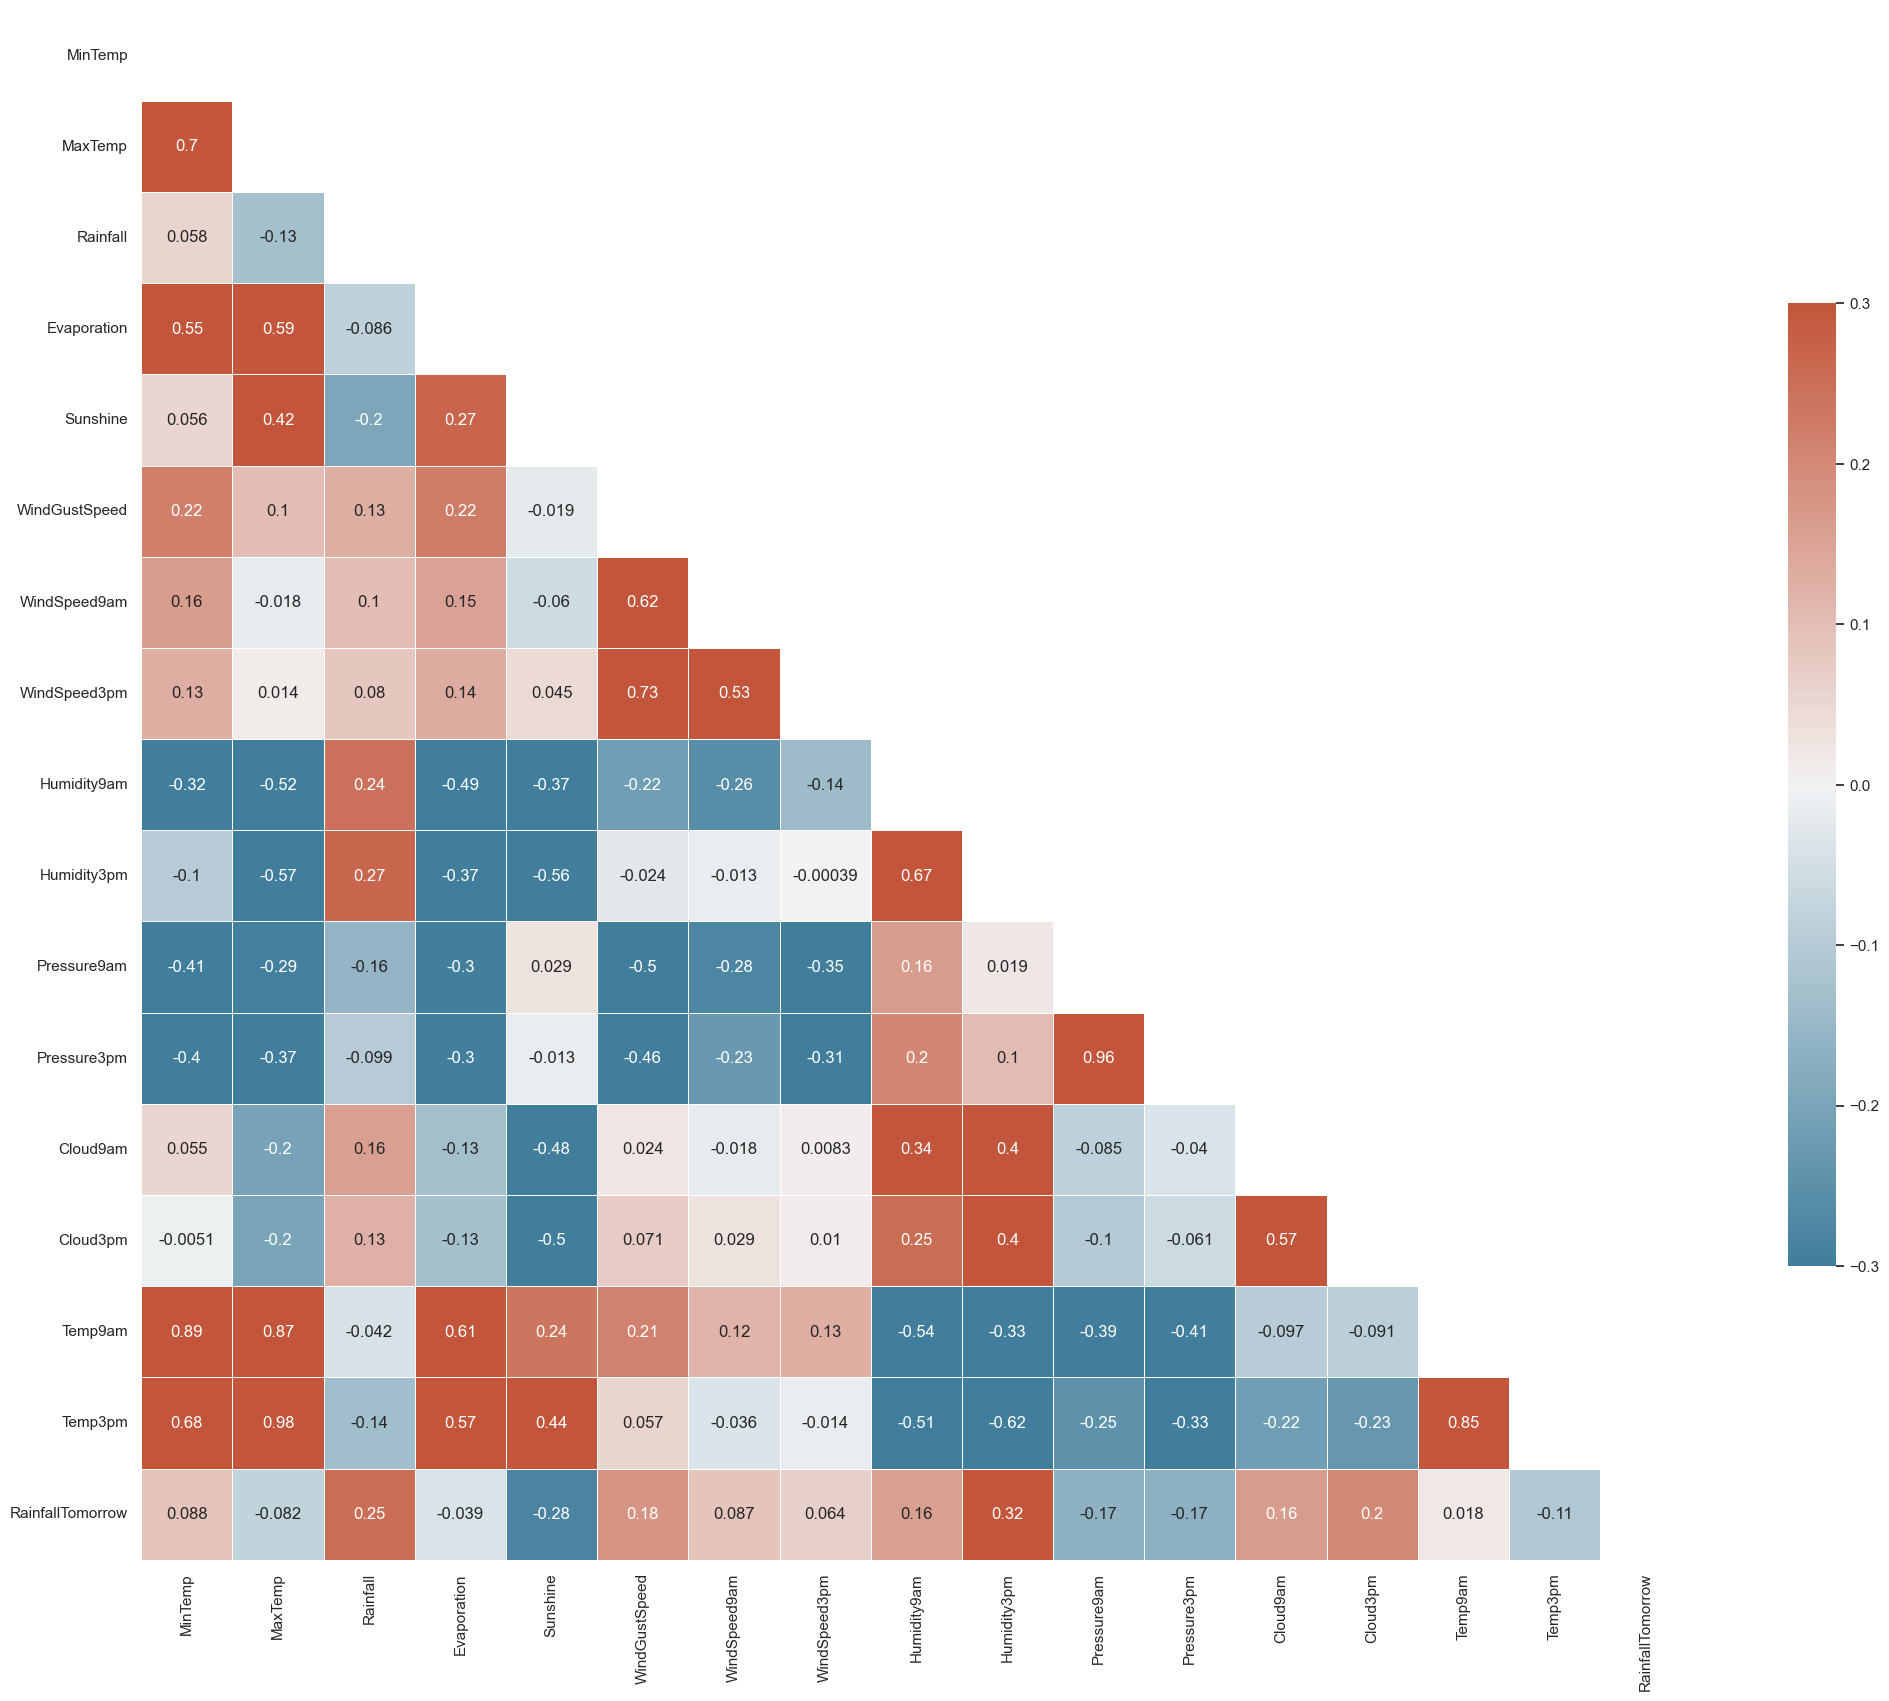

In [53]:
sns.set_theme(style="white")
# Compute the correlation matrix
corr = train_dummies[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainfallTomorrow']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True,annot=True ,linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

- *MaxTemp y MinTemp (0.7)*: Hay una correlación positiva fuerte entre la temperatura máxima y mínima del día. Esto significa que, generalmente, los días con altas temperaturas máximas también tienen altas temperaturas mínimas.

- *Evaporation y MaxTemp (0.59):* Existe una correlación positiva moderada entre la evaporación y la temperatura máxima. Días más calientes tienden a tener mayor evaporación.

- *Humidity3pm y Humidity9am (0.67):* Hay una correlación positiva fuerte entre la humedad a las 3pm y la humedad a las 9am, lo cual es esperable ya que la humedad a lo largo del día tiende a estar relacionada.

- *Pressure3pm y Pressure9am (0.96)*: Hay una correlación positiva muy fuerte entre la presión atmosférica a las 3pm y la presión a las 9am, indicando que los cambios de presión son generalmente consistentes a lo largo del día.

- *Temp3pm y Temp9am (0.85)*: La temperatura a las 3pm y a las 9am están fuertemente correlacionadas positivamente, lo cual es lógico ya que la temperatura de la mañana influye en la temperatura del resto del día.

- *RainTomorrow y Rainfall (0.25):* Hay una correlación positiva débil entre la cantidad de lluvia y si va a llover mañana. Aunque es débil, indica que hay cierta relación entre la cantidad de lluvia hoy y la probabilidad de lluvia mañana.

- *RainTomorrow y Humidity3pm (0.32):* Hay una correlación positiva moderada entre la humedad a las 3pm y la probabilidad de lluvia mañana. Esto sugiere que mayor humedad por la tarde puede estar asociada con mayor probabilidad de lluvia el día siguiente.


Las variables climáticas más relevantes que parecen influir en la probabilidad de lluvia mañana *(RainTomorrow)* son la humedad a las 3pm *(Humidity3pm), la cantidad de lluvia **(Rainfall)* y la presión atmosférica a las 3pm (Pressure3pm). Estas variables pueden ser útiles para construir un modelo predictivo.

## Matriz de correlación categórica

### Train

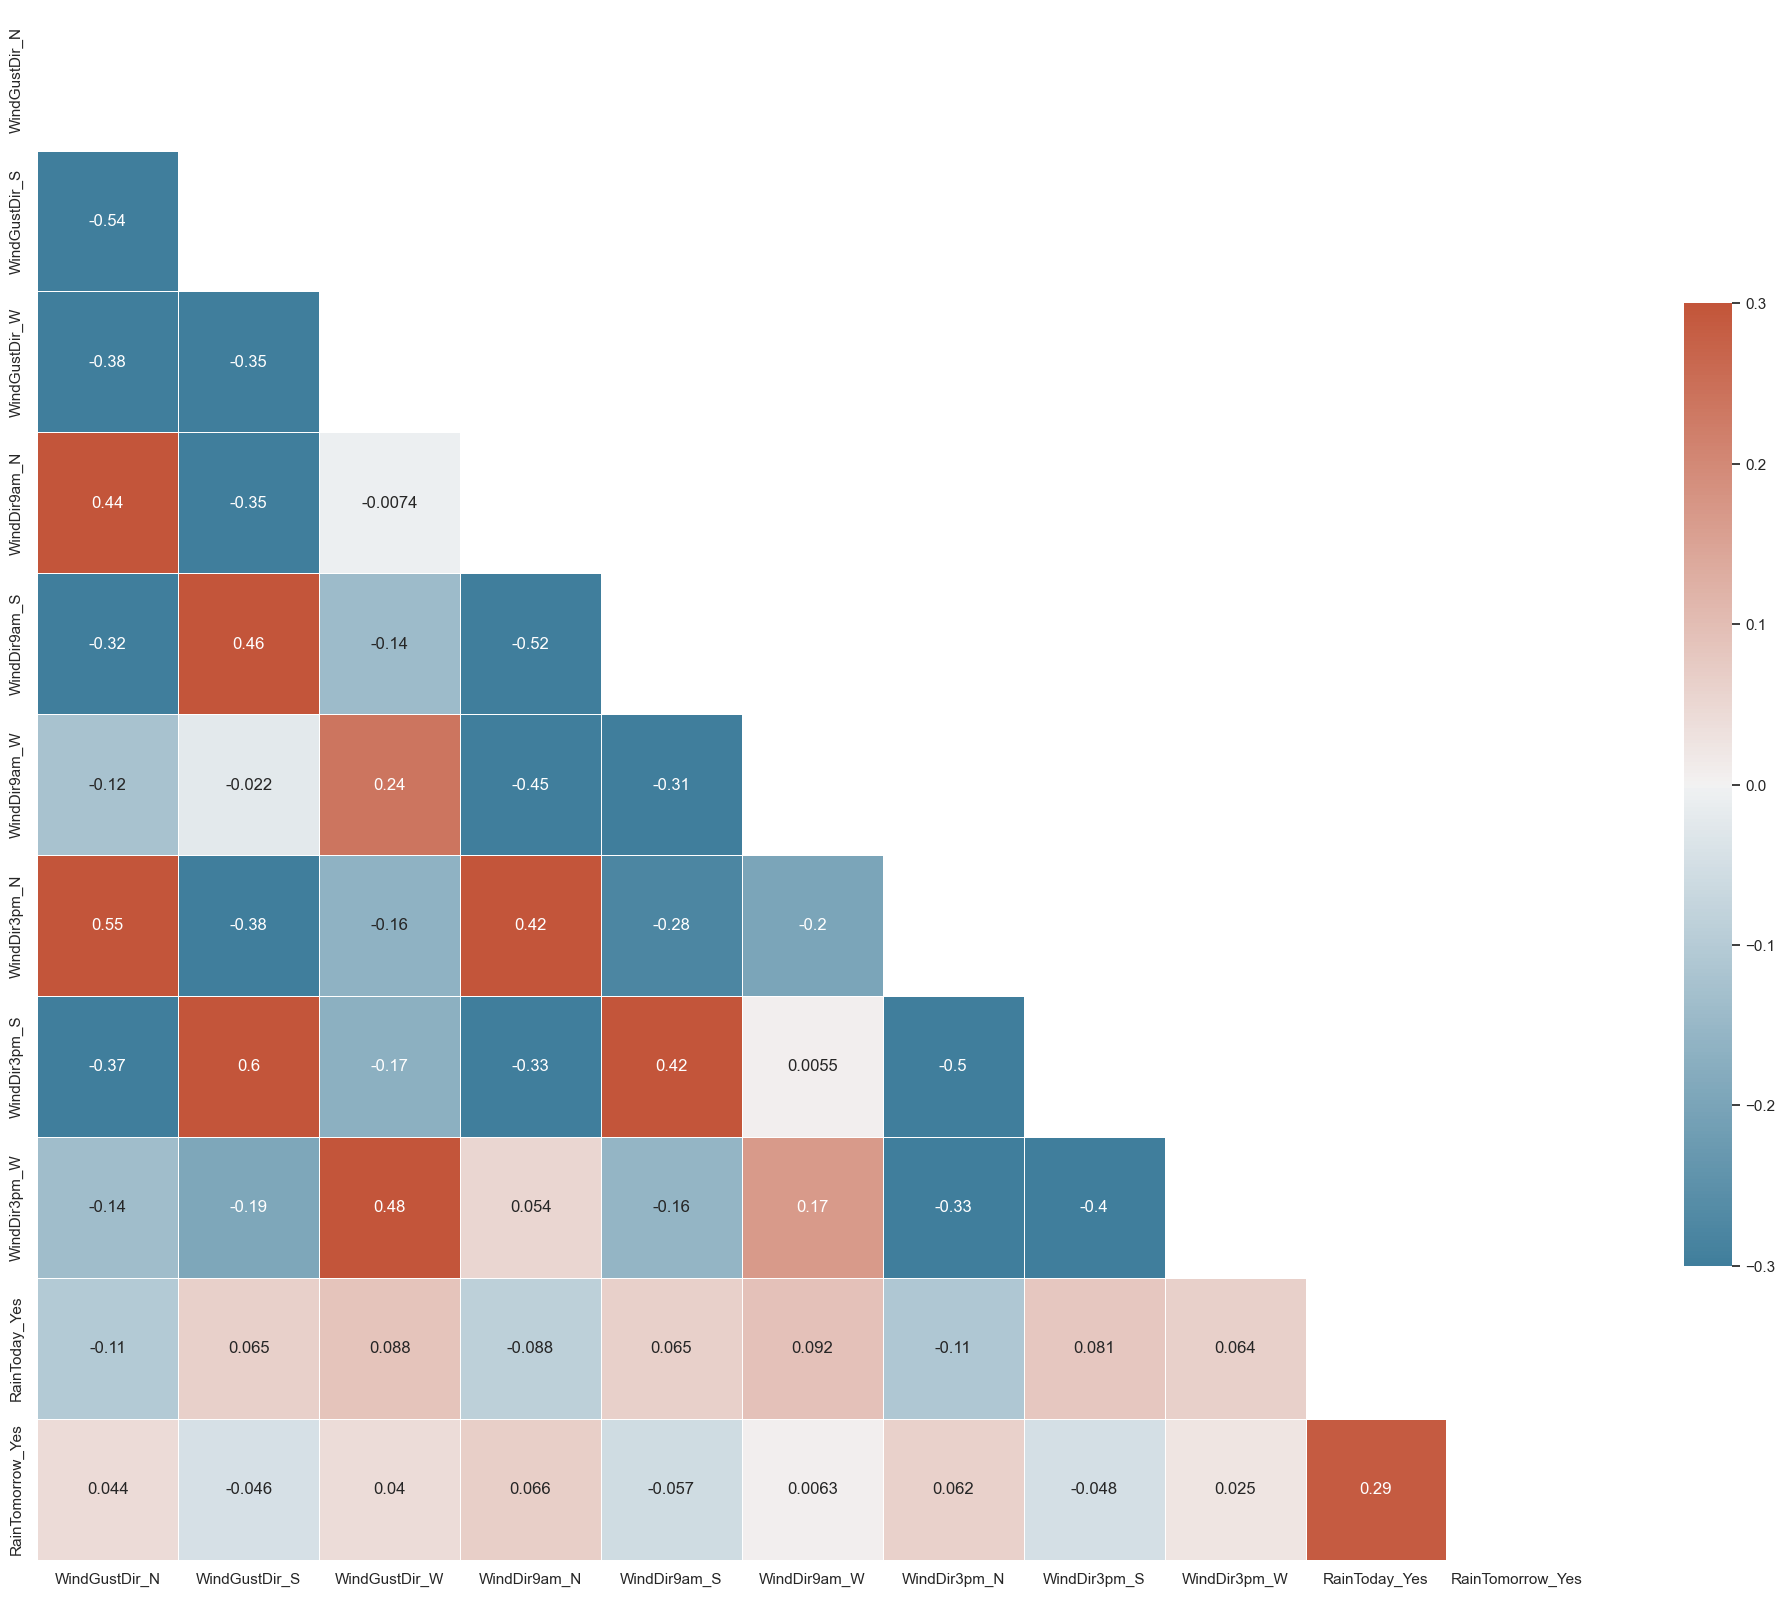

In [54]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = train_dummies[['WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainTomorrow_Yes']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True,annot=True ,linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Estas correlaciones entre diferentes variables meteorológicas proporcionan información útil sobre cómo ciertos aspectos del clima pueden estar relacionados entre sí en el contexto de Australia. Aquí hay algunas observaciones sobre las correlaciones que has proporcionado:

-  *WindGustDir_e y WindDir9am_e (0.34)*: Existe una correlación moderada positiva entre la dirección de la ráfaga de viento registrada por la estación meteorológica a las 9 a.m. y la dirección de la ráfaga de viento registrada por la estación meteorológica este. Esto sugiere que cuando la dirección del viento en la mañana es hacia el este, es más probable que se registren ráfagas de viento provenientes de esa misma dirección.

-  *WindGustDir_n y WindDir9am_n (0.44)*: Hay una correlación moderadamente positiva entre la dirección de la ráfaga de viento registrada por la estación meteorológica a las 9 a.m. y la dirección de la ráfaga de viento registrada por la estación meteorológica norte. Esto indica que las ráfagas de viento registradas en el norte a menudo están alineadas con la dirección del viento por la mañana.

-  *WindGustDir_s y WindDir9am_s (0.46)*: Similar al punto anterior, pero con una correlación ligeramente más fuerte, lo que sugiere una relación más estrecha entre la dirección del viento y las ráfagas de viento en el sur durante la mañana.

-  *WindGustDir_w y WindDir9am_w (0.24)*: Existe una correlación positiva más débil entre la dirección de la ráfaga de viento registrada por la estación meteorológica a las 9 a.m. y la dirección de la ráfaga de viento registrada por la estación meteorológica oeste.

-  *WindDir3pm_n y WindGustDir_n (0.55)*: Una correlación moderadamente positiva fuerte entre la dirección del viento a las 3 p.m. y la dirección de la ráfaga de viento en el norte. Esto sugiere que las ráfagas de viento en el norte están relacionadas con la dirección general del viento a las 3 p.m.

- *WindDir3pm_w y WindGustDir_w (0.48)*: Similar al punto anterior, pero con una dirección del viento en el oeste y ráfagas de viento relacionadas.

-  *WindDir3pm_n y WindDir9am_n (0.42)*: Correlación moderada positiva entre la dirección del viento a las 9 a.m. y a las 3 p.m. en el norte. Esto sugiere cierta consistencia en la dirección del viento durante el día en esa región.

- *WindDir9am_s y WindDir3pm_s (0.42)*: Correlación moderada positiva entre la dirección del viento a las 9 a.m. y a las 3 p.m. en el sur, lo que indica cierta consistencia en la dirección del viento durante el día en esa región.

Las variables climáticas más relevantes que parecen influir en la probabilidad de lluvia mañana (RainTomorrow) son las correlaciones entre la dirección del viento y la probabilidad de lluvia, además la dirección del viento en el norte a las 3 p.m. puede estar especialmente relacionada con ráfagas de viento en esa dirección, lo que podría estar asociado con sistemas climáticos que favorecen la lluvia y también  con la dirección del viento en el oeste y ráfagas de viento relacionadas .

# División del conjunto de datos de entrenamiento


## Regresión Lineal

**y_train & y_proces:**
- Elimina las características especificadas de train_processed para de esta forma solo quedarnos con nuestro variable target "RainfallTomorrow".

**x_train & x_proces:**
- Elimina "RainfallTomorrow" para de esta forma solo quedarnos con las características que serán utilizadas para predecir la variable “RainfallTomorrow”.

In [55]:
# Train
y_train_rl = train_dummies.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainTomorrow_Yes'], axis=1)
x_train_rl = train_dummies.drop(['RainfallTomorrow', 'RainTomorrow_Yes'], axis=1)

# Test
y_test_rl = test_dummies.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainTomorrow_Yes'], axis=1)
x_test_rl = test_dummies.drop(['RainfallTomorrow', 'RainTomorrow_Yes'], axis=1)

## Regresión Logística (Clasificación).

**y_train & y_proces:**
- Elimina las características especificadas de train_processed para de esta forma solo quedarnos con nuestro variable target "RainTomorrow".

**x_train & x_proces:**
- Elimina "RainfallTomorrow" para de esta forma solo quedarnos con las características que serán utilizadas para predecir la variable “RainTomorrow”.

In [56]:
# Train
y_train_rlog = train.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainfallTomorrow'], axis=1)
x_train_rlog = train_dummies.drop(['RainfallTomorrow', 'RainTomorrow_Yes'], axis=1)

# Test
y_test_rlog = test.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainfallTomorrow'], axis=1)
x_test_rlog = test_dummies.drop(['RainfallTomorrow', 'RainTomorrow_Yes'], axis=1)

balanceamos los datos

In [57]:
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split

# Asumiendo que 'train' y 'test' son tus DataFrames originales

# Aplicar SMOTETomek solo al conjunto de entrenamiento
smote_tomek = SMOTETomek(random_state=42)

# Asegúrate de que y_train_rlog sea una serie, no un DataFrame
if isinstance(y_train_rlog, pd.DataFrame):
    y_train_rlog = y_train_rlog.iloc[:, 0]

X_train_balanced_rlog, y_train_balanced_rlog = smote_tomek.fit_resample(x_train_rlog, y_train_rlog)

# El conjunto de prueba se mantiene sin cambios
X_test_balanced_rlog, y_test_balanced_rlog = x_test_rlog, y_test_rlog

c:\Users\src4\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\src4\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [58]:
print("Distribución original:")
print(y_train_rlog.value_counts(normalize=True))

print("\nDistribución después del balanceo:")
print(pd.Series(y_train_balanced_rlog).value_counts(normalize=True))

Distribución original:
RainTomorrow
No     0.770164
Yes    0.229836
Name: proportion, dtype: float64

Distribución después del balanceo:
RainTomorrow
No     0.5
Yes    0.5
Name: proportion, dtype: float64


In [59]:
# Codificar las etiquetas
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_balanced_rlog.values.flatten())
y_test_encoded = le.fit_transform(y_test_balanced_rlog.values.flatten())

In [60]:
y_train_encoded

array([0, 0, 0, ..., 1, 1, 1])

In [61]:
y_test_encoded

array([0, 0, 1, ..., 0, 1, 0])

# Regresión Lineal y Gradiente descendiente

## Regresión Lineal

In [62]:
# Crea una instancia del modelo de regresión lineal
model_rl = LinearRegression()
model_rl.fit(x_train_rl, y_train_rl)

LinearRegression()

In [63]:
y_train_pred = model_rl.predict(x_train_rl)
y_pred = model_rl.predict(x_test_rl)

#### Coeficiente e Intercepción

In [64]:
coefficients = model_rl.coef_
intercept = model_rl.intercept_
print("Coefficients:", coefficients)
print(f"\nIntercept:", intercept)

Coefficients: [[-0.0407449   0.07603522  0.14962785  0.01279303 -0.13009594  0.20800795
  -0.01604192 -0.08974218 -0.06016079  0.35349013  0.46445679 -0.53846508
  -0.02748936  0.0291743   0.01264246  0.01904106 -0.06952425 -0.06076414
  -0.07279977 -0.13607759 -0.06639044 -0.10705435 -0.01214293  0.02829295
   0.02130573  0.06009669]]

Intercept: [0.13281419]


**Coeficientes**

Tenemos un vector de coeficientes con valores que varían desde aproximadamente -2.81e+11 hasta 3.18e+12. Estos números son bastante grandes, lo que podría indicar que algunas de las variables pueden estar correlacionadas o que los datos podrían no estar normalizados.

Dado que los datos están normalizados, esto significa que los coeficientes representan el cambio esperado en la variable dependiente para un cambio de una desviación estándar en la variable independiente correspondiente.

Por lo tanto, podemos comparar directamente los coeficientes entre sí para determinar qué variables tienen un mayor impacto en la variable dependiente. Un coeficiente con un valor absoluto mayor indica que esa variable tiene un efecto más fuerte en la variable dependiente.

**Intercepción**

El término de intercepción es -2.93e+12, que es el valor esperado de Y cuando todas las variables independientes (X) son 0.

#### Métricas del set de entrenamiento

In [65]:
# MSE: Error Cuadratico Medio
mse_train = mean_squared_error(y_train_rl, y_train_pred)

# R^2
r2_train = r2_score(y_train_rl, y_train_pred)

# MAE: Error Absoluto Medio
mae_train = mean_absolute_error(y_train_rl, y_train_pred)

# RMSE: Raíz del Error Cuadrático Medio
rmse_train = np.sqrt(mean_squared_error(y_train_rl, y_train_pred))

print(f"\nR²: {r2_train}\n")
print(f"MSE(Error Cuadratico Medio): {mse_train}\n")
print(f"MAE(Error Absoluto Medio): {mae_train}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse_train}\n")


R²: 0.21662048257699917

MSE(Error Cuadratico Medio): 0.7833795174230008

MAE(Error Absoluto Medio): 0.41760788877604416

RMSE(Raíz del Error Cuadrático Medio): 0.8850872936739069



**R²**

El coeficiente de determinación (R²) es 0.2165. Este valor varía entre 0 y 1, y representa la proporción de la varianza total de la variable dependiente explicada por el modelo. Nuestro R² de 0.2165 significa que el modelo explica aproximadamente el 21.65% de la variabilidad en los datos, lo cual no es muy alto.

**MSE**

El Error Cuadrático Medio (MSE) es 0.7835. Esta métrica mide el promedio de los errores al cuadrado, es decir, la diferencia entre el valor estimado y el valor real. Cuanto más cerca de 0 esté este valor, mejor será el modelo. Nuestro MSE de 0.7835 significa que en el modelo hay mucha diferencia entre el calor estimado y el real.

**MAE**

El Error Absoluto Medio (MAE) es 0.4174. Esta métrica mide el promedio de los errores absolutos, es decir, la diferencia absoluta entre el valor estimado y el valor real. Al igual que con el MSE, cuanto más cerca de 0 esté este valor, mejor será el modelo. Al igual que en MSE significa que en el modelo hay diferencia entre el calor estimado y el real, pero es más chicha esta diferencia.

**RMSE**

La Raíz del Error Cuadrático Medio (RMSE) es 0.8851. Esta métrica es la raíz cuadrada del MSE y tiene la ventaja de estar en las mismas unidades que la variable dependiente. También penaliza más los errores grandes que el MAE.

#### Métricas del set de testeo

In [66]:
# MSE: Error Cuadratico Medio
mse = mean_squared_error(y_test_rl, y_pred)

# R^2
r2 = r2_score(y_test_rl, y_pred)

# MAE: Error Absoluto Medio
mae = mean_absolute_error(y_test_rl, y_pred)

# RMSE: Raíz del Error Cuadrático Medio
rmse = np.sqrt(mean_squared_error(y_test_rl, y_pred))

print(f"\nR²: {r2}\n")
print(f"MSE(Error Cuadratico Medio): {mse}\n")
print(f"MAE(Error Absoluto Medio): {mae}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse}\n")


R²: 0.250201390379328

MSE(Error Cuadratico Medio): 0.845071954465071

MAE(Error Absoluto Medio): 0.4283005439389782

RMSE(Raíz del Error Cuadrático Medio): 0.9192779527787398



**R²**

El coeficiente de determinación (R²) es 0.2544. Este valor varía entre 0 y 1, y representa la proporción de la varianza total de la variable dependiente explicada por el modelo. Nuestro R² de 0.2544 significa que el modelo explica aproximadamente el 25.44% de la variabilidad en los datos, lo cual no es muy alto.

**MSE**

El Error Cuadrático Medio (MSE) es 0.7455. Esta métrica mide el promedio de los errores al cuadrado, es decir, la diferencia entre el valor estimado y el valor real. Cuanto más cerca de 0 esté este valor, mejor será el modelo. Nuestro MSE de 0.7455 significa que en el modelo hay mucha diferencia entre el calor estimado y el real.

**MAE**

El Error Absoluto Medio (MAE) es 0.4177. Esta métrica mide el promedio de los errores absolutos, es decir, la diferencia absoluta entre el valor estimado y el valor real. Al igual que con el MSE, cuanto más cerca de 0 esté este valor, mejor será el modelo. Al igual que en MSE significa que en el modelo hay diferencia entre el calor estimado y el real, pero es más chicha esta diferencia.

**RMSE**

La Raíz del Error Cuadrático Medio (RMSE) es 0.8635. Esta métrica es la raíz cuadrada del MSE y tiene la ventaja de estar en las mismas unidades que la variable dependiente. También penaliza más los errores grandes que el MAE.

### Conlcusión

**Evaluación del rendimiento del modelo:** Las métricas del conjunto de entrenamiento nos dan una idea de cómo se está desempeñando el modelo en los datos que está utilizando para aprender. Por otro lado, las métricas del conjunto de prueba nos muestran cómo se desempeña el modelo en datos nuevos e invisibles, lo cual es un indicador más realista de cómo se comportará el modelo en el mundo real.

**Detección de sobreajuste y subajuste:** Si el error de entrenamiento es bajo pero el error de prueba es alto, esto puede indicar un sobreajuste, lo que significa que el modelo ha aprendido los datos de entrenamiento “demasiado bien” y no generaliza bien a nuevos datos. Por otro lado, si tanto el error de entrenamiento como el de prueba son altos, esto puede indicar un subajuste, lo que significa que el modelo no ha aprendido suficientemente bien los datos de entrenamiento.

**Selección y ajuste de modelos:** Al comparar las métricas de entrenamiento y prueba, podemos tomar decisiones informadas sobre la selección del modelo (por ejemplo, qué tipo de modelo usar) y el ajuste del modelo (por ejemplo, cómo ajustar los hiperparámetros del modelo).

En nuestro caso, las métricas del conjunto de entrenamiento y prueba son bastante similares, lo que es una buena señal de que el modelo no está sobreajustado. Sin embargo, el valor de R² es relativamente bajo tanto para el conjunto de entrenamiento como para el de prueba, lo que indica que el modelo podría no estar capturando toda la variabilidad en los datos. Podríamos considerar probar diferentes tipos de modelos o ajustar los hiperparámetros para tratar de mejorar estas métricas.

## Gradiente descendiente

In [67]:
# Regresión lineal utilizando SGDRegressor
model_sgd = SGDRegressor(max_iter=1000, tol=1e-3)
model_sgd.fit(x_train_rl, y_train_rl.values.ravel())

SGDRegressor()

In [68]:
y_pred_sgd = model_sgd.predict(x_test_rl)

In [69]:
y_train_pred_sgd = model_sgd.predict(x_train_rl)

#### Coeficiente e Intercepción

In [70]:
coefficients_sgd = model_sgd.coef_
intercept_sgd = model_sgd.intercept_
print("Coefficients (SGD):", coefficients_sgd)
print(f"\nIntercept (SGD):", intercept_sgd)

Coefficients (SGD): [-0.04142883  0.06182389  0.15652215  0.0272183  -0.13691547  0.19077562
 -0.0125825  -0.06917128 -0.07767177  0.35932358  0.44909085 -0.51249226
 -0.0393289   0.02128669  0.01045418  0.03211886 -0.07034201 -0.06248031
 -0.07315539 -0.14137756 -0.06458545 -0.10837004 -0.01987248  0.01589094
  0.00730873  0.05723862]

Intercept (SGD): [0.12466016]


#### Métricas del set de entrenamiento

In [71]:
# MSE: Error Cuadratico Medio
mse_train_sgd = mean_squared_error(y_train_rl, y_train_pred_sgd)

# R^2
r2_train_sgd = r2_score(y_train_rl, y_train_pred_sgd)

# MAE: Error Absoluto Medio
mae_train_sgd = mean_absolute_error(y_train_rl, y_train_pred_sgd)

# RMSE: Raíz del Error Cuadrático Medio
rmse_train_sgd = np.sqrt(mean_squared_error(y_train_rl, y_train_pred_sgd))

print(f"\nR²: {r2_train_sgd}\n")
print(f"MSE(Error Cuadratico Medio): {mse_train_sgd}\n")
print(f"MAE(Error Absoluto Medio): {mae_train_sgd}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse_train_sgd}\n")


R²: 0.21503603029163887

MSE(Error Cuadratico Medio): 0.7849639697083611

MAE(Error Absoluto Medio): 0.41055690894159114

RMSE(Raíz del Error Cuadrático Medio): 0.8859819240302599



#### Métricas del set de testeo

In [72]:
# MSE: Error Cuadrático Medio
mse_sgd = mean_squared_error(y_test_rl, y_pred_sgd)

# R^2
r2_sgd = r2_score(y_test_rl, y_pred_sgd)

# MAE: Error Absoluto Medio
mae_sgd = mean_absolute_error(y_test_rl, y_pred_sgd)

# RMSE: Raíz del Error Cuadrático Medio
rmse_sgd = np.sqrt(mse_sgd)

print(f"\nR² (SGD): {r2_sgd}\n")
print(f"MSE (SGD): {mse_sgd}\n")
print(f"MAE (SGD): {mae_sgd}\n")
print(f"RMSE (SGD): {rmse_sgd}\n")


R² (SGD): 0.24681269346747903

MSE (SGD): 0.8488912369839258

MAE (SGD): 0.4216594635831258

RMSE (SGD): 0.9213529383379236



## Comparación

In [73]:
# Crear un diccionario con los resultados
results = {
    'Model': ['Regresión Lineal', 'Regresión Lineal', 'Gradiente descendiente', 'Gradiente descendiente'],
    'Data': ['Train', 'Test', 'Train', 'Test'],
    'R²': [r2_train, r2, r2_train_sgd, r2_sgd],
    'MSE': [mse_train, mse, mse_train_sgd, mse_sgd],
    'MAE': [mae_train, mae, mae_train_sgd, mae_sgd],
    'RMSE': [rmse_train, rmse, rmse_train_sgd, rmse_sgd]
}

# Convertir el diccionario en un DataFrame
df_comparativo = pd.DataFrame(results)

df_comparativo

Model   Data        R²       MSE       MAE      RMSE
0        Regresión Lineal  Train  0.216620  0.783380  0.417608  0.885087
1        Regresión Lineal   Test  0.250201  0.845072  0.428301  0.919278
2  Gradiente descendiente  Train  0.215036  0.784964  0.410557  0.885982
3  Gradiente descendiente   Test  0.246813  0.848891  0.421659  0.921353

El cambio fue prácticamente nulo.

### Grafico

In [74]:
def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

In [75]:
y_train_gd = y_train_rl.values.reshape(-1, 1)
y_test_gd = y_test_rl.values.reshape(-1, 1)

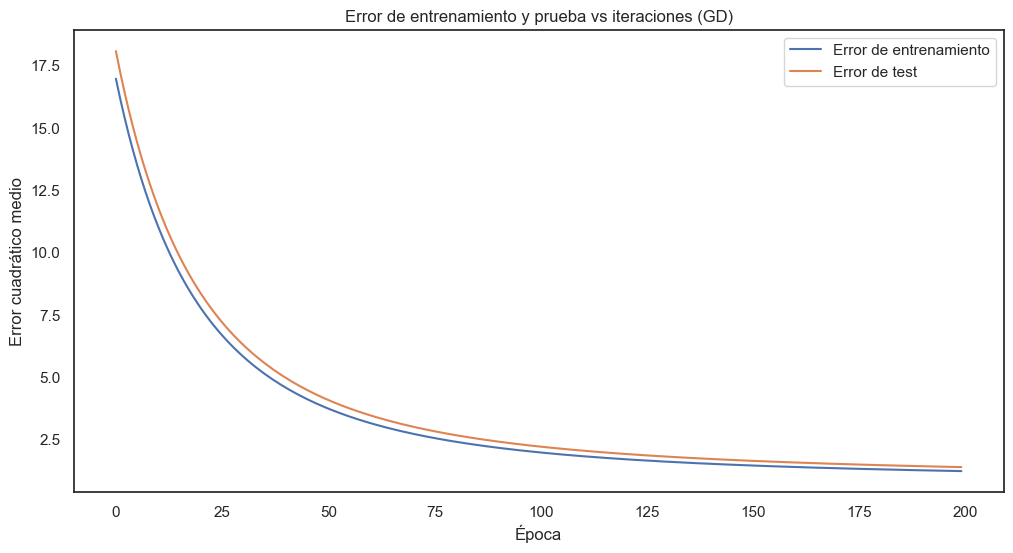

array([[ 0.19654877],
       [ 0.17115309],
       [ 0.57884192],
       [ 0.13748116],
       [-0.01262269],
       [-0.10789876],
       [-0.02147577],
       [ 0.24380924],
       [ 0.00138522],
       [-0.09925818],
       [ 0.45730236],
       [ 0.9139281 ],
       [-1.05366621],
       [ 0.20876365],
       [-0.09579676],
       [-0.61894524],
       [-0.03242317],
       [ 0.54329293],
       [ 0.8152476 ],
       [-0.35443712],
       [-1.2641959 ],
       [-1.20601412],
       [-0.42759552],
       [ 0.17488207],
       [ 0.34372454],
       [ 1.0041148 ],
       [-0.12444297]])

In [76]:
gradient_descent(x_train_rl, y_train_gd, x_test_rl, y_test_gd, lr=0.01, epochs=200)

**Disminución de los errores:** Ambos, el error de entrenamiento (azul) y el error de prueba (naranja), disminuyen a medida que aumenta el número de épocas. Esto indica que el modelo está aprendiendo de los datos de entrenamiento y mejorando su rendimiento a medida que se entrena.

**Convergencia de los errores:** Parece que después de cierto número de épocas, los errores de entrenamiento y prueba comienzan a converger, lo que sugiere que el modelo puede estar llegando a su mejor rendimiento.

**Posible sobreajuste:** Si el error de entrenamiento sigue disminuyendo significativamente mientras que el error de prueba deja de disminuir o incluso comienza a aumentar, esto podría ser un indicio de sobreajuste. Sin embargo, en este caso, ambos errores parecen disminuir a un ritmo similar, lo que es una buena señal.

**Elección del número de épocas:** Este gráfico puede ayudar a elegir el número óptimo de épocas para entrenar un modelo. Podría detener el entrenamiento cuando el error de prueba deje de disminuir para evitar el sobreajuste y ahorrar tiempo de computación.

In [77]:
# Guardar el scaler para usarlo en la predicción
import joblib
joblib.dump(model_sgd, 'ModelSGD.joblib')

['ModelSGD.joblib']

# Lasso, Ridge y Elastic Net

## Lasso

In [78]:
lasso = Lasso(alpha=0.1) # alpha controla la fuerza de la regularización L1 (Lasso)
lasso.fit(x_train_rl, y_train_rl)

Lasso(alpha=0.1)

In [79]:
print("Coeficientes del modelo Lasso:")
print(lasso.coef_)
print("\nCoeficientes del modelo Lasso de train:", lasso.score(x_train_rl, y_train_rl))
print("Coeficientes del modelo Lasso de test:", lasso.score(x_test_rl, y_test_rl))

Coeficientes del modelo Lasso:
[ 0.          0.          0.08278177  0.         -0.07165773  0.04170011
  0.          0.          0.          0.16918611 -0.         -0.05764961
  0.          0.          0.          0.          0.         -0.
 -0.          0.         -0.         -0.          0.         -0.
 -0.          0.        ]

Coeficientes del modelo Lasso de train: 0.15547992197797988
Coeficientes del modelo Lasso de test: 0.15830839162417


In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import numpy as np

# Primero, haz predicciones en los conjuntos de entrenamiento y prueba
y_pred_train_lasso = lasso.predict(x_train_rl)
y_pred_test_lasso = lasso.predict(x_test_rl)

# Error Cuadrático Medio (MSE)
mse_train_lasso = mean_squared_error(y_train_rl, y_pred_train_lasso)
mse_test_lasso = mean_squared_error(y_test_rl, y_pred_test_lasso)

# Raíz del Error Cuadrático Medio (RMSE)
rmse_train_lasso = sqrt(mse_train_lasso)
rmse_test_lasso = sqrt(mse_test_lasso)

# Error Absoluto Medio (MAE)
mae_train_lasso = mean_absolute_error(y_train_rl, y_pred_train_lasso)
mae_test_lasso = mean_absolute_error(y_test_rl, y_pred_test_lasso)

# Coeficiente de determinación (R²)
r2_train_lasso = r2_score(y_train_rl, y_pred_train_lasso)
r2_test_lasso = r2_score(y_test_rl, y_pred_test_lasso)

# Imprimir resultados
print("Métricas para el modelo Lasso:")
print("\nConjunto de entrenamiento:")
print(f"MSE: {mse_train_lasso:.4f}")
print(f"RMSE: {rmse_train_lasso:.4f}")
print(f"MAE: {mae_train_lasso:.4f}")
print(f"R²: {r2_train_lasso:.4f}")

print("\nConjunto de prueba:")
print(f"MSE: {mse_test_lasso:.4f}")
print(f"RMSE: {rmse_test_lasso:.4f}")
print(f"MAE: {mae_test_lasso:.4f}")
print(f"R²: {r2_test_lasso:.4f}")

# Coeficientes del modelo
print("\nCoeficientes del modelo Lasso:")
if lasso.coef_.ndim == 1:
    for feature, coef in zip(x_train_rl.columns, lasso.coef_):
        if abs(coef) > 1e-5:  # Mostrar solo coeficientes no nulos
            print(f"{feature}: {coef:.4f}")
else:
    for i, (feature, coef) in enumerate(zip(x_train_rl.columns, lasso.coef_[0])):
        if abs(coef) > 1e-5:  # Mostrar solo coeficientes no nulos
            print(f"{feature}: {coef:.4f}")

# Intercept (término independiente)
if np.isscalar(lasso.intercept_):
    print(f"\nIntercept: {lasso.intercept_:.4f}")
else:
    print(f"\nIntercept: {lasso.intercept_[0]:.4f}")

# Número de coeficientes no nulos
non_zero_coef = np.sum(np.abs(lasso.coef_) > 1e-5)
print(f"\nNúmero de características seleccionadas: {non_zero_coef}")

Métricas para el modelo Lasso:

Conjunto de entrenamiento:
MSE: 0.8445
RMSE: 0.9190
MAE: 0.3974
R²: 0.1555

Conjunto de prueba:
MSE: 0.9486
RMSE: 0.9740
MAE: 0.4183
R²: 0.1583

Coeficientes del modelo Lasso:
Rainfall: 0.0828
Sunshine: -0.0717
WindGustSpeed: 0.0417
Humidity3pm: 0.1692
Pressure3pm: -0.0576

Intercept: 0.0000

Número de características seleccionadas: 5


## Ridge

In [81]:
ridge = Ridge(alpha=0.1) # alpha controla la fuerza de la regularización L2 (Ridge)
ridge.fit(x_train_rl, y_train_rl)

Ridge(alpha=0.1)

In [82]:
print("Coeficientes del modelo Ridge:")
print(ridge.coef_)
print("\nCoeficientes del modelo Ridge de train:", ridge.score(x_train_rl, y_train_rl))
print("Coeficientes del modelo Ridge de test:", ridge.score(x_test_rl, y_test_rl))

Coeficientes del modelo Ridge:
[[-0.04074709  0.07602491  0.14962724  0.01279041 -0.13009776  0.20800436
  -0.01604377 -0.0897411  -0.06016017  0.35348596  0.46436374 -0.53837418
  -0.02748946  0.02917376  0.0126386   0.01906091 -0.06951272 -0.06075797
  -0.07279264 -0.13606374 -0.06637975 -0.10704395 -0.01214465  0.02827147
   0.02128445  0.06008676]]

Coeficientes del modelo Ridge de train: 0.21662048212645457
Coeficientes del modelo Ridge de test: 0.250199729795894


In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import numpy as np

# Primero, haz predicciones en los conjuntos de entrenamiento y prueba
y_pred_train_ridge = ridge.predict(x_train_rl)
y_pred_test_ridge = ridge.predict(x_test_rl)

# Error Cuadrático Medio (MSE)
mse_train_ridge = mean_squared_error(y_train_rl, y_pred_train_ridge)
mse_test_ridge = mean_squared_error(y_test_rl, y_pred_test_ridge)

# Raíz del Error Cuadrático Medio (RMSE)
rmse_train_ridge = sqrt(mse_train_ridge)
rmse_test_ridge = sqrt(mse_test_ridge)

# Error Absoluto Medio (MAE)
mae_train_ridge = mean_absolute_error(y_train_rl, y_pred_train_ridge)
mae_test_ridge = mean_absolute_error(y_test_rl, y_pred_test_ridge)

# Coeficiente de determinación (R²)
r2_train_ridge = r2_score(y_train_rl, y_pred_train_ridge)
r2_test_ridge = r2_score(y_test_rl, y_pred_test_ridge)

# Imprimir resultados
print("Métricas para el modelo Ridge:")
print("\nConjunto de entrenamiento:")
print(f"MSE: {mse_train_ridge:.4f}")
print(f"RMSE: {rmse_train_ridge:.4f}")
print(f"MAE: {mae_train_ridge:.4f}")
print(f"R²: {r2_train_ridge:.4f}")

print("\nConjunto de prueba:")
print(f"MSE: {mse_test_ridge:.4f}")
print(f"RMSE: {rmse_test_ridge:.4f}")
print(f"MAE: {mae_test_ridge:.4f}")
print(f"R²: {r2_test_ridge:.4f}")

# Coeficientes del modelo
print("\nCoeficientes del modelo Ridge:")
if ridge.coef_.ndim == 1:
    for feature, coef in zip(x_train_rl.columns, ridge.coef_):
        print(f"{feature}: {coef:.4f}")
else:
    for i, (feature, coef) in enumerate(zip(x_train_rl.columns, ridge.coef_[0])):
        print(f"{feature}: {coef:.4f}")

# Intercept (término independiente)
if np.isscalar(ridge.intercept_):
    print(f"\nIntercept: {ridge.intercept_:.4f}")
else:
    print(f"\nIntercept: {ridge.intercept_[0]:.4f}")

Métricas para el modelo Ridge:

Conjunto de entrenamiento:
MSE: 0.7834
RMSE: 0.8851
MAE: 0.4176
R²: 0.2166

Conjunto de prueba:
MSE: 0.8451
RMSE: 0.9193
MAE: 0.4283
R²: 0.2502

Coeficientes del modelo Ridge:
MinTemp: -0.0407
MaxTemp: 0.0760
Rainfall: 0.1496
Evaporation: 0.0128
Sunshine: -0.1301
WindGustSpeed: 0.2080
WindSpeed9am: -0.0160
WindSpeed3pm: -0.0897
Humidity9am: -0.0602
Humidity3pm: 0.3535
Pressure9am: 0.4644
Pressure3pm: -0.5384
Cloud9am: -0.0275
Cloud3pm: 0.0292
Temp9am: 0.0126
Temp3pm: 0.0191
WindGustDir_N: -0.0695
WindGustDir_S: -0.0608
WindGustDir_W: -0.0728
WindDir9am_N: -0.1361
WindDir9am_S: -0.0664
WindDir9am_W: -0.1070
WindDir3pm_N: -0.0121
WindDir3pm_S: 0.0283
WindDir3pm_W: 0.0213
RainToday_Yes: 0.0601

Intercept: 0.1328


## Elastic Net

In [84]:
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)
elasticnet.fit(x_train_rl, y_train_rl)

ElasticNet(alpha=0.1)

In [85]:
print("Coeficientes del modelo Ridge:")
print(ridge.coef_)
print("\nCoeficientes del modelo Ridge de train:", ridge.score(x_train_rl, y_train_rl))
print("Coeficientes del modelo Ridge de test:", ridge.score(x_test_rl, y_test_rl))

Coeficientes del modelo Ridge:
[[-0.04074709  0.07602491  0.14962724  0.01279041 -0.13009776  0.20800436
  -0.01604377 -0.0897411  -0.06016017  0.35348596  0.46436374 -0.53837418
  -0.02748946  0.02917376  0.0126386   0.01906091 -0.06951272 -0.06075797
  -0.07279264 -0.13606374 -0.06637975 -0.10704395 -0.01214465  0.02827147
   0.02128445  0.06008676]]

Coeficientes del modelo Ridge de train: 0.21662048212645457
Coeficientes del modelo Ridge de test: 0.250199729795894


In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Primero, haz predicciones en los conjuntos de entrenamiento y prueba
y_pred_train = elasticnet.predict(x_train_rl)
y_pred_test = elasticnet.predict(x_test_rl)

# Error Cuadrático Medio (MSE)
mse_train = mean_squared_error(y_train_rl, y_pred_train)
mse_test = mean_squared_error(y_test_rl, y_pred_test)

# Raíz del Error Cuadrático Medio (RMSE)
rmse_train = sqrt(mse_train)
rmse_test = sqrt(mse_test)

# Error Absoluto Medio (MAE)
mae_train = mean_absolute_error(y_train_rl, y_pred_train)
mae_test = mean_absolute_error(y_test_rl, y_pred_test)

# Coeficiente de determinación (R²)
r2_train = r2_score(y_train_rl, y_pred_train)
r2_test = r2_score(y_test_rl, y_pred_test)

# Imprimir resultados
print("Métricas para el modelo ElasticNet:")
print("\nConjunto de entrenamiento:")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE: {mae_train:.4f}")
print(f"R²: {r2_train:.4f}")

print("\nConjunto de prueba:")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"R²: {r2_test:.4f}")

# Coeficientes del modelo
print("\nCoeficientes del modelo ElasticNet:")
for feature, coef in zip(x_train_rl.columns, elasticnet.coef_):
    print(f"{feature}: {coef:.4f}")

Métricas para el modelo ElasticNet:

Conjunto de entrenamiento:
MSE: 0.8223
RMSE: 0.9068
MAE: 0.3980
R²: 0.1777

Conjunto de prueba:
MSE: 0.9174
RMSE: 0.9578
MAE: 0.4153
R²: 0.1860

Coeficientes del modelo ElasticNet:
MinTemp: 0.0000
MaxTemp: 0.0000
Rainfall: 0.1094
Evaporation: 0.0000
Sunshine: -0.0996
WindGustSpeed: 0.0693
WindSpeed9am: 0.0000
WindSpeed3pm: -0.0000
Humidity9am: 0.0000
Humidity3pm: 0.1930
Pressure9am: -0.0000
Pressure3pm: -0.0867
Cloud9am: 0.0000
Cloud3pm: 0.0011
Temp9am: 0.0094
Temp3pm: 0.0000
WindGustDir_N: 0.0000
WindGustDir_S: -0.0000
WindGustDir_W: -0.0000
WindDir9am_N: -0.0000
WindDir9am_S: -0.0000
WindDir9am_W: -0.0000
WindDir3pm_N: 0.0000
WindDir3pm_S: -0.0000
WindDir3pm_W: -0.0000
RainToday_Yes: 0.0000


## Gráfico comparativo

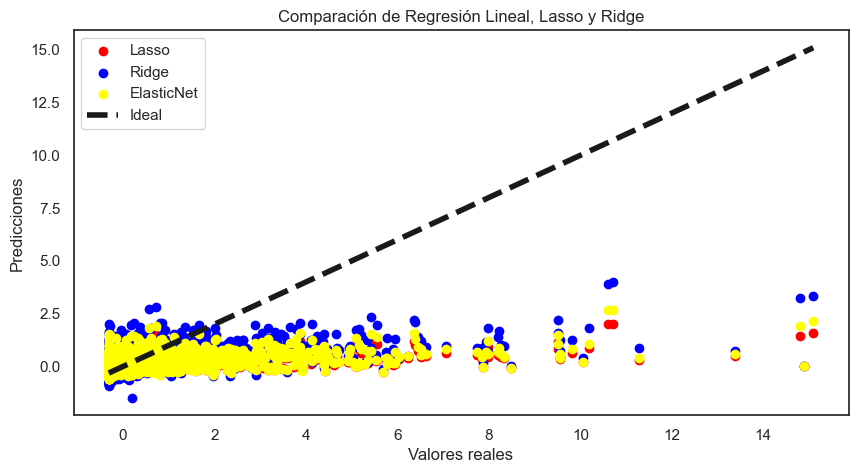

In [87]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test_rl, lasso.predict(x_test_rl), label='Lasso', color='red')
plt.scatter(y_test_rl, ridge.predict(x_test_rl), label='Ridge', color='blue')
plt.scatter(y_test_rl, elasticnet.predict(x_test_rl), label='ElasticNet', color='yellow')
plt.plot([y_test_rl.min(), y_test_rl.max()], [y_test_rl.min(), y_test_rl.max()], 'k--', lw=4, label='Ideal')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.legend()
plt.title('Comparación de Regresión Lineal, Lasso y Ridge')
plt.show()

# Regresión Logística (Clasificación).


In [88]:
# Inicializar y entrenar un modelo de regresión logística
model_c = LogisticRegression()
start = time.time()
model_c.fit(X_train_balanced_rlog, np.ravel(y_train_balanced_rlog))
end = time.time()

no_opt_time = end - start

# Realizar predicciones en el conjunto de prueba
y_pred_train = model_c.predict(X_train_balanced_rlog)
y_pred_test = model_c.predict(X_test_balanced_rlog)
model_c

LogisticRegression()

El siguiente codigo calcula la matriz de confucion y nos da el reporte de las metricas ademas nos genera una confiaza ya que podemos evaluar bien

In [89]:
# Calcular métricas
accuracy_logreg = accuracy_score(y_train_balanced_rlog, y_pred_train) # compara el valor real y el predicho

confusion_matrix_logreg = confusion_matrix(y_train_balanced_rlog, y_pred_train)

classification_report_logreg = classification_report(y_train_balanced_rlog, y_pred_train)

# Imprimir métricas
print("Métricas para logreg:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg:
Precisión: 0.7913005780346821
Matriz de confusión:
[[13833  3467]
 [ 3754 13546]]
Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.79      0.80      0.79     17300
         Yes       0.80      0.78      0.79     17300

    accuracy                           0.79     34600
   macro avg       0.79      0.79      0.79     34600
weighted avg       0.79      0.79      0.79     34600



In [90]:
# Calcular métricas
accuracy_logreg = accuracy_score(y_test_balanced_rlog, y_pred_test) 

confusion_matrix_logreg = confusion_matrix(y_test_balanced_rlog, y_pred_test)

classification_report_logreg = classification_report(y_test_balanced_rlog, y_pred_test)

# Imprimir métricas
print("Métricas para logreg:")
print(f'Precisión: {accuracy_logreg}')
print("Matriz de confusión:")
print(confusion_matrix_logreg)
print("Reporte de clasificación:")
print(classification_report_logreg)

Métricas para logreg:
Precisión: 0.8098192130450195
Matriz de confusión:
[[3633  730]
 [ 343  936]]
Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.91      0.83      0.87      4363
         Yes       0.56      0.73      0.64      1279

    accuracy                           0.81      5642
   macro avg       0.74      0.78      0.75      5642
weighted avg       0.83      0.81      0.82      5642



### Interpretación de Errores

#### Conjunto de Entrenamiento

- **Falsos Positivos**: 3,467 (predijo lluvia incorrectamente)
- **Falsos Negativos**: 3,754 (no predijo lluvia cuando sí llovió)

#### Conjunto de Prueba

- **Falsos Positivos**: 730 (predijo lluvia incorrectamente)
- **Falsos Negativos**: 343 (no predijo lluvia cuando sí llovió)

Nos enfocamos en el F1-score como nuestra métrica principal, especialmente para la clase positiva (lluvia), debido al desbalance en nuestros datos y a la importancia de predecir correctamente los días de lluvia.

1. **Clase positiva (lluvia)**:
   - F1-Score en entrenamiento: 0.79
   - F1-Score en prueba: 0.64

2. **Interpretación**:
   - El modelo muestra un rendimiento aceptable en el conjunto de entrenamiento para predecir días de lluvia (F1 = 0.79).
   - Sin embargo, hay una caída significativa en el rendimiento para la clase positiva en el conjunto de prueba (F1 = 0.64).
   - Esta disminución sugiere que el modelo podría estar sobreajustado a los datos de entrenamiento para la predicción de lluvia.

3. **Comparación con la clase negativa**:
   - Aunque no es nuestro enfoque principal, es notable que el modelo tiene un mejor rendimiento para predecir días sin lluvia (F1 = 0.87 en prueba) que días con lluvia aun despues del balanceo de datos.

En este caso nuestra clase positiva es que si llueva.

Para el conjunto de entrenamiento

Tenemos 4075 falsos positivos (o error del tipo 1) es decir, predije que llovía pero no llovió. Tenemos 1171 falsos negativos (o error de tipo 2) es decir, predije que no llovía y llovió

Para el conjunto de prueba

Tenemos 862 falsos positivos (o error del tipo 1) es decir, predije que llovía pero no llovió. Tenemos 265 falsos negativos (o error de tipo 2) es decir, predije que no llovía y llovió

En cuanto a las métricas vamos a utilizar el F1 score ya que como no somos agrónomas no podemos determinar cual de los dos errores tiene mayor importancia. Además nuestros datos están desbalanceados y esta métrica lo contempla.

F1 score para la clase positiva (en nuestro caso, si llueve) es de 0.58 lo que indicaría que el modelo no es muy bueno para clasificar correctamente esta clase.

En cambio, para la clase negativa (no llueve) el F1 score es de 0.81, lo que indica que si es bueno para predecir esta clase.

log_loss cuantifica qué tan bien el modelo está prediciendo la probabilidad de que una muestra pertenezca a la clase positiva o negativa. Un valor de pérdida logarítmica más bajo indica un mejor rendimiento del modelo.

C:\Users\src4\AppData\Local\Temp\ipykernel_18572\3567865038.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test_binary = y_test_balanced_rlog.replace({'No': 0, 'Yes': 1})
C:\Users\src4\AppData\Local\Temp\ipykernel_18572\3567865038.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train_binary = y_train_balanced_rlog.replace({'No': 0, 'Yes': 1})


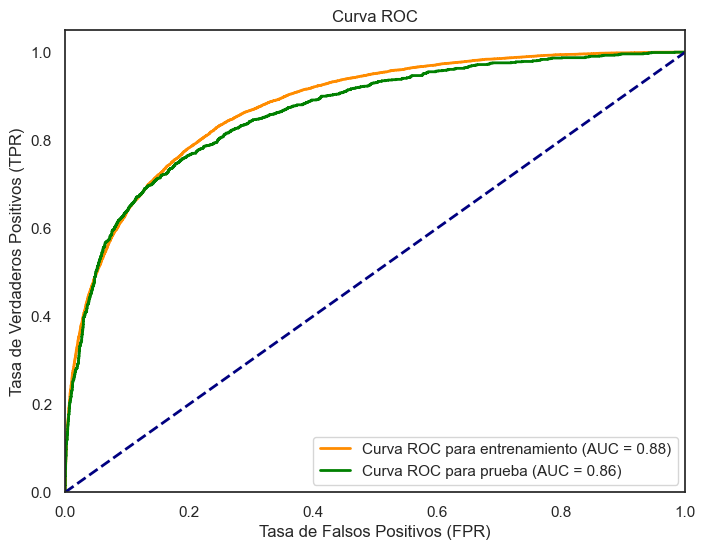

El área bajo la curva para entrenamiento es de: 0.8769667346052323
El área bajo la curva para prueba es de: 0.862735308659409


In [91]:
# Remplaza 'No' con 0 y 'Yes' con 1
y_test_binary = y_test_balanced_rlog.replace({'No': 0, 'Yes': 1})
y_train_binary = y_train_balanced_rlog.replace({'No': 0, 'Yes': 1})

# Obtengo las probabilidades de predicción del modelo para los datos de entrenamiento y prueba
y_probs_train = model_c.predict_proba(X_train_balanced_rlog)[:, 1]
y_probs_test = model_c.predict_proba(X_test_balanced_rlog)[:, 1]

# Calculo la ROC y el AUC para los datos de entrenamiento y prueba
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_probs_train, pos_label= 1)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test_binary, y_probs_test, pos_label= 1)
roc_auc_test = auc(fpr_test, tpr_test)

# Grafico la curva ROC para los datos de entrenamiento y prueba
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Curva ROC para entrenamiento (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='Curva ROC para prueba (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print(f"El área bajo la curva para entrenamiento es de: {roc_auc_train}")
print(f"El área bajo la curva para prueba es de: {roc_auc_test}")

### Rendimiento del Modelo

El Área Bajo la Curva (AUC) para nuestro modelo es:
- Entrenamiento: 0.88
- Prueba: 0.86

Estos valores indican un excelente rendimiento del modelo en términos de equilibrio entre sensibilidad y especificidad. Un AUC > 0.8 generalmente se considera muy bueno, y nuestro modelo supera este umbral tanto en entrenamiento como en prueba.

### Interpretación de la Curva ROC

- La línea naranja representa la Curva ROC para el conjunto de entrenamiento, mientras que la línea verde representa la Curva ROC para el conjunto de prueba.
- Ambas curvas están significativamente por encima de la línea diagonal (representada por la línea azul punteada), lo que indica un rendimiento mucho mejor que un clasificador aleatorio.
- La cercanía entre las curvas de entrenamiento y prueba sugiere que el modelo generaliza bien a datos no vistos.

### Comparación con Modelos Teóricos

- Un modelo perfecto tendría un AUC de 1, representado por una curva que pasa por el punto (0,1) del gráfico.
- La línea diagonal azul punteada representa un modelo aleatorio con un AUC de 0.5.
- Nuestro modelo se sitúa considerablemente por encima de esta línea, confirmando su utilidad predictiva.

In [92]:
# Calcula la distancia euclidiana entre cada punto de la curva ROC y (0,1) para los datos de entrenamiento
distances_train = np.sqrt((1 - tpr_train)**2 + fpr_train**2)

# Encuentra el índice del punto que minimiza la distancia para los datos de entrenamiento
min_index_train = np.argmin(distances_train)

# Obtiene el umbral óptimo para los datos de entrenamiento
optimal_threshold_train = thresholds_train[min_index_train]

# Calcula la distancia euclidiana entre cada punto de la curva ROC y (0,1) para los datos de prueba
distances_test = np.sqrt((1 - tpr_test)**2 + fpr_test**2)

# Encuentra el índice del punto que minimiza la distancia para los datos de prueba
min_index_test = np.argmin(distances_test)

# Obtiene el umbral óptimo para los datos de prueba
optimal_threshold_test = thresholds_test[min_index_test]

print("Umbral óptimo para entrenamiento:", optimal_threshold_train)
print("Umbral óptimo para prueba:", optimal_threshold_test)

Umbral óptimo para entrenamiento: 0.48910183117128725
Umbral óptimo para prueba: 0.4551637393392152


## Umbral Óptimo

Hemos calculado los umbrales óptimos:
- Para entrenamiento: 0.4891
- Para prueba: 0.4552

Estos umbrales están cercanos al 0.5 estándar, pero ligeramente por debajo. Esto sugiere que:

1. El modelo está bien calibrado, ya que los umbrales óptimos no se alejan significativamente del punto medio.
2. Un umbral ligeramente inferior a 0.5 puede favorecer la sensibilidad sobre la especificidad, lo cual podría ser beneficioso para detectar más casos de lluvia.

In [1]:
# Guardar el scaler para usarlo en la predicción
import joblib
joblib.dump(model_c, 'ModelRL.joblib')

NameError: name 'model_c' is not defined

# Modelos bases.

## Regresión Lineal

In [94]:
# Dejamos unicamente como valores los de Rainfall

# Train
y_train_rl_base = train_dummies.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',  'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes'], axis=1)
x_train_rl_base = train_dummies.drop(['MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',  'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainfallTomorrow'], axis=1)

# Test
y_test_rl_base = test_dummies.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',  'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes'], axis=1)
x_test_rl_base = test_dummies.drop(['MinTemp', 'MaxTemp', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',  'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainfallTomorrow'], axis=1)

In [95]:
# Crea una instancia del modelo de regresión lineal
model_rl_base = LinearRegression()
model_rl_base.fit(x_train_rl_base, y_train_rl_base)

LinearRegression()

In [96]:
# Make predictions using the imputed data
y_pred_base = model_rl_base.predict(x_test_rl_base)

coefficients = model_rl_base.coef_
intercept = model_rl_base.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)

# MSE: Error Cuadratico Medio
mse_base = mean_squared_error(y_test_rl_base, y_pred_base)

# R^2
r2_base = r2_score(y_test_rl_base, y_pred_base)

# MAE: Error Absoluto Medio
mae_base = mean_absolute_error(y_test_rl_base, y_pred_base)

# RMSE: Raíz del Error Cuadrático Medio
rmse_base = np.sqrt(mean_squared_error(y_test_rl_base, y_pred_base))

print(f"\nR²: {r2_base}\n")
print(f"MSE(Error Cuadratico Medio): {mse_base}\n")
print(f"MAE(Error Absoluto Medio): {mae_base}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse_base}\n")

Coefficients: [[ 1.27292757e-01  1.24156596e+00]
 [-4.36159934e-15  1.00000000e+00]]
Intercept: [-2.85356814e-01 -1.11299858e-14]

R²: 0.6689038885694849

MSE(Error Cuadratico Medio): 0.37316692030667137

MAE(Error Absoluto Medio): 0.14299526548201266

RMSE(Raíz del Error Cuadrático Medio): 0.6108738988585708



## Clasificación

In [97]:
# Dejamos unicamente como valores los de RainToday_Yes

# Train
y_train_rlog_base  = train.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainfallTomorrow'], axis=1)
X_train_balanced_rlog_base  = train_dummies.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainfallTomorrow', 'RainTomorrow_Yes'], axis=1)

# Test
y_test_rlog_base  = test.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainfallTomorrow'], axis=1)
X_test_balanced_rlog_base  = test_dummies.drop(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainfallTomorrow', 'RainTomorrow_Yes'], axis=1)


In [98]:
# Asegurarse de que y_train_rlog_base sea un array 1D
y_train_rlog_base = column_or_1d(y_train_rlog_base)

# Inicializar y entrenar un modelo de regresión logística
model_base = LogisticRegression()
model_base.fit(X_train_balanced_rlog_base, y_train_rlog_base)

# Verificar los nombres de las características para el conjunto de prueba
missing_features = set(model_base.feature_names_in_) - set(X_test_balanced_rlog_base.columns)
new_features = set(X_test_balanced_rlog_base.columns) - set(model_base.feature_names_in_)

if missing_features:
    print(f"Faltan características en el conjunto de prueba: {missing_features}")
    for feature in missing_features:
        X_test_balanced_rlog_base[feature] = 0  # O el valor que sea apropiado

if new_features:
    print(f"Existen nuevas características en el conjunto de prueba: {new_features}")
    X_test_balanced_rlog_base = X_test_balanced_rlog_base.drop(columns=new_features)

# Realizar predicciones en el conjunto de prueba
y_pred_base = model_base.predict(X_test_balanced_rlog_base)


In [99]:
# Calcular métricas
accuracy_logreg_base = accuracy_score(y_test_rlog_base, y_pred_base) # compara el valor real y el predicho

confusion_matrix_logreg_base = confusion_matrix(y_test_rlog_base, y_pred_base)

classification_report_logreg_base = classification_report(y_test_rlog_base, y_pred_base, zero_division=1)

# Imprimir métricas
print("Métricas para logreg:")
print(f'Precisión: {accuracy_logreg_base}')
print("Matriz de confusión:")
print(confusion_matrix_logreg_base)
print("Reporte de clasificación:")
print(classification_report_logreg_base)


Métricas para logreg:
Precisión: 0.7733073378234668
Matriz de confusión:
[[4363    0]
 [1279    0]]
Reporte de clasificación:
              precision    recall  f1-score   support

          No       0.77      1.00      0.87      4363
         Yes       1.00      0.00      0.00      1279

    accuracy                           0.77      5642
   macro avg       0.89      0.50      0.44      5642
weighted avg       0.82      0.77      0.67      5642



# Optimización de la selección de hiperparámetros.

## KFold y StratifiedKFold

Evitamos usar Leave-One-Out ya que nuestro conjuntos de datos es grandes y sabemos que Leave-One-Out puede ser muy costoso en términos de tiempo para conjuntos de datos grandes.

In [100]:
X = X_train_balanced_rlog.values
y = y_train_rlog['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0).values

clf = RandomForestClassifier(n_estimators=50)

In [101]:
### n_splits es la cantidad de folds
cv_strategies = [
    ("KFold", KFold(n_splits=5, shuffle=True)),
    ("StratifiedKFold", StratifiedKFold(n_splits=5, shuffle=True)),
]

results = {}
for name, cv in cv_strategies:
    scores = cross_val_score(clf, X, y, cv=cv)
    results[name] = scores

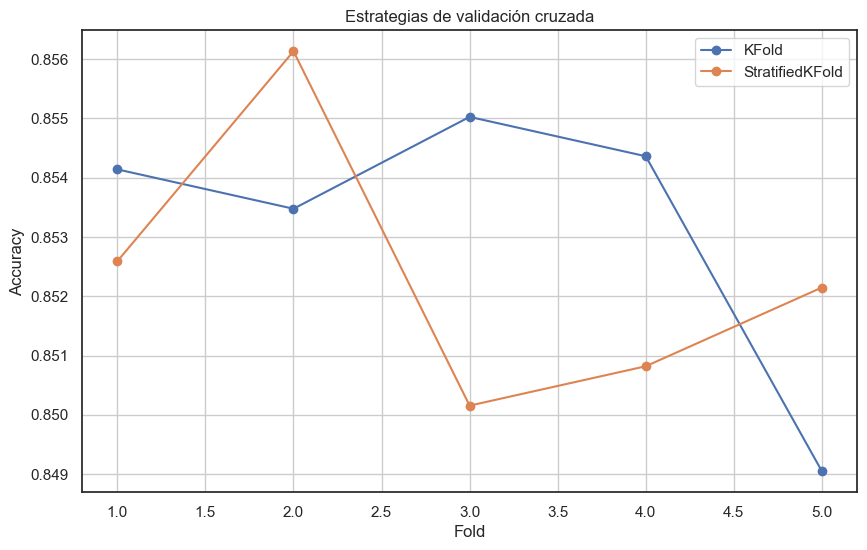

In [102]:
plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Estrategias de validación cruzada")
plt.legend()
plt.grid(True)
plt.show()

In [103]:
results['KFold']

array([0.854139  , 0.85347499, 0.85502435, 0.85436034, 0.84904825])

In [104]:
for strategy in cv_strategies:
  print('Media para la estrategia', strategy[0],':',results['KFold'].mean())
  print('Desvío estándar para la estrategia', strategy[0],':',results['KFold'].std())

Media para la estrategia KFold : 0.8532093846834883
Desvío estándar para la estrategia KFold : 0.0021386228117186595
Media para la estrategia StratifiedKFold : 0.8532093846834883
Desvío estándar para la estrategia StratifiedKFold : 0.0021386228117186595


Comparando los modelos: en el gráfico podemos observar que K-Folds tiene mayor varianza que StratifiedKFold, eso se debe a que K-Folds separa sus folds aleatoriamente, en cambio StratifiedKFold trata de balancearlos.

Como sabemos que nuestro dataset está desbalanceado, tenderíamos a quedarnos con StratifiedKFold.

## Grid Search

In [105]:
# Definimos los parámetros para Grid Search
param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

# Realizamos la búsqueda de hiperparámetros con Grid Search
grid_search = GridSearchCV(estimator=model_c, param_grid=param_grid, cv=5, n_jobs=-1)
start = time.time()
grid_search.fit(X_train_balanced_rlog, np.ravel(y_train_rlog))
end = time.time()
grid_search_time = end - start
y_pred_grid_search = grid_search.predict(X_test_balanced_rlog)

# Métricas para el modelo con Grid Search
grid_search_accuracy = accuracy_score(y_test_rlog, y_pred_grid_search)
grid_search_precision = precision_score(y_test_rlog, y_pred_grid_search, average='weighted')
grid_search_recall = recall_score(y_test_rlog, y_pred_grid_search, average='weighted')
grid_search_f1_score = f1_score(y_test_rlog, y_pred_grid_search, average='weighted')

print('Accuracy:', grid_search_accuracy)
print('Precision:', grid_search_precision)
print('Recall:', grid_search_recall)
print('F1 Score:', grid_search_f1_score)

Accuracy: 0.8433179723502304
Precision: 0.8339578130766855
Recall: 0.8433179723502304
F1 Score: 0.8288430989129331


In [106]:
# Guardar el scaler para usarlo en la predicción
import joblib
joblib.dump(grid_search, 'ModelGS.joblib')

['ModelGS.joblib']

## Random Search

In [107]:
# Definimos los parámetros para Random Search
random_param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': np.logspace(-4, 4, 20)},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': np.logspace(-4, 4, 20)}
]

# Realizamos la búsqueda de hiperparámetros con Random Search
random_search = RandomizedSearchCV(estimator=model_c, param_distributions=random_param_grid, n_iter=10, cv=5, n_jobs=-1)
start = time.time()
random_search.fit(X_train_balanced_rlog, np.ravel(y_train_rlog))
end = time.time()
random_search_time = end - start
y_pred_random_search = random_search.predict(X_test_balanced_rlog)

# Métricas para el modelo con Random Search
random_search_accuracy = accuracy_score(y_test_rlog, y_pred_random_search)
random_search_precision = precision_score(y_test_rlog, y_pred_random_search, average='weighted')
random_search_recall = recall_score(y_test_rlog, y_pred_random_search, average='weighted')
random_search_f1_score = f1_score(y_test_rlog, y_pred_random_search, average='weighted')

print('Accuracy:', random_search_accuracy)
print('Precision:', random_search_precision)
print('Recall:', random_search_recall)
print('F1 Score:', random_search_f1_score)

Accuracy: 0.8459766040411202
Precision: 0.8367982023589431
Recall: 0.8459766040411202
F1 Score: 0.8331311519460195


In [108]:
# Guardar el scaler para usarlo en la predicción
import joblib
joblib.dump(random_search, 'ModelRS.joblib')

['ModelRS.joblib']

## Tabla comparativa Grid Search & Random Search

In [109]:
# Creamos una tabla comparativa
results = pd.DataFrame({
    'Modelo': ['Sin Optimización', 'Grid Search', 'Random Search'],
    'Tiempo de Entrenamiento (s)': [no_opt_time, grid_search_time, random_search_time]
})

# Aplicar formato a la tabla
styled_results = results.style.format({
    'Accuracy': "{:.2%}",
    'Precision': "{:.2%}",
    'Recall': "{:.2%}",
    'F1 Score': "{:.2%}",
    'Tiempo de Entrenamiento (s)': "{:.2f}"
})

# Imprimir la tabla
styled_results.set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center')]
}])


## Optuna

In [110]:
# función para entrenar y evaluar un modelo con hiperparámetros dados
def train_evaluate_model(params, X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [111]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    params = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
    }

    mse = train_evaluate_model(params, X_train_balanced_rlog, y_train_encoded, X_test_balanced_rlog, y_test_encoded)
    return mse

In [112]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
best_optuna_params = study.best_params
best_optuna_model = RandomForestRegressor(**best_optuna_params)
best_optuna_model.fit(X_train_balanced_rlog, y_train_encoded)
optuna_mse = mean_squared_error(y_test_encoded, best_optuna_model.predict(X_test_balanced_rlog))

[I 2024-06-28 10:22:20,787] A new study created in memory with name: no-name-d223d44f-9248-4601-9649-cf68d2d597a7
[I 2024-06-28 10:22:36,117] Trial 0 finished with value: 0.10992198771597901 and parameters: {'n_estimators': 184, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.10992198771597901.
[I 2024-06-28 10:23:00,621] Trial 1 finished with value: 0.10937785271874698 and parameters: {'n_estimators': 184, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.10937785271874698.
[I 2024-06-28 10:23:18,618] Trial 2 finished with value: 0.10925857189599751 and parameters: {'n_estimators': 181, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.10925857189599751.
[I 2024-06-28 10:23:30,701] Trial 3 finished with value: 0.10943047295790857 and parameters: {'n_estimators': 134, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 2 with

In [113]:
best_optuna_params

{'n_estimators': 176,
 'max_depth': 17,
 'min_samples_split': 3,
 'min_samples_leaf': 4}

In [114]:
optuna_mse

0.10870028112942721

# SHAP

In [115]:
# Asegúrate de tener definidos los nombres de las características como una lista
feature_names = X_test_balanced_rlog.columns.tolist()
feature_names

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'WindGustDir_N',
 'WindGustDir_S',
 'WindGustDir_W',
 'WindDir9am_N',
 'WindDir9am_S',
 'WindDir9am_W',
 'WindDir3pm_N',
 'WindDir3pm_S',
 'WindDir3pm_W',
 'RainToday_Yes']

In [116]:
# Crear un objeto explainer SHAP para el modelo de regresión logística
explainer = shap.LinearExplainer(model_c, X_train_balanced_rlog)
shap_values = explainer.shap_values(X_test_balanced_rlog)

In [117]:
shap_values.shape

(5642, 26)

In [118]:
explainer.expected_value

-1.7166814856133952

El valor esperado que SHAP proporciona es la media de las predicciones en términos de log-odds. Si la probabilidad de la clase positiva es baja en promedio, los log-odds serán negativos.

In [119]:
# Convertir log-odds a probabilidad
expected_probability = 1 / (1 + np.exp(-explainer.expected_value))
print("Probabilidad esperada:", expected_probability)

Probabilidad esperada: 0.152299103253741


## Interpretabilidad local

In [120]:
shap_values[0]

array([-0.07105119, -0.45168193, -0.0311492 ,  0.00760465, -0.10100251,
       -0.26910168, -0.00479057,  0.09000483,  0.01136381, -1.91837072,
        0.80463853, -1.24228051,  0.10070296, -0.24243464,  0.12726725,
        0.44192339,  0.01906764, -0.0486224 , -0.0048761 ,  0.05761881,
       -0.17164978,  0.01554123, -0.07290642,  0.09087186, -0.04472794,
       -0.14169244])

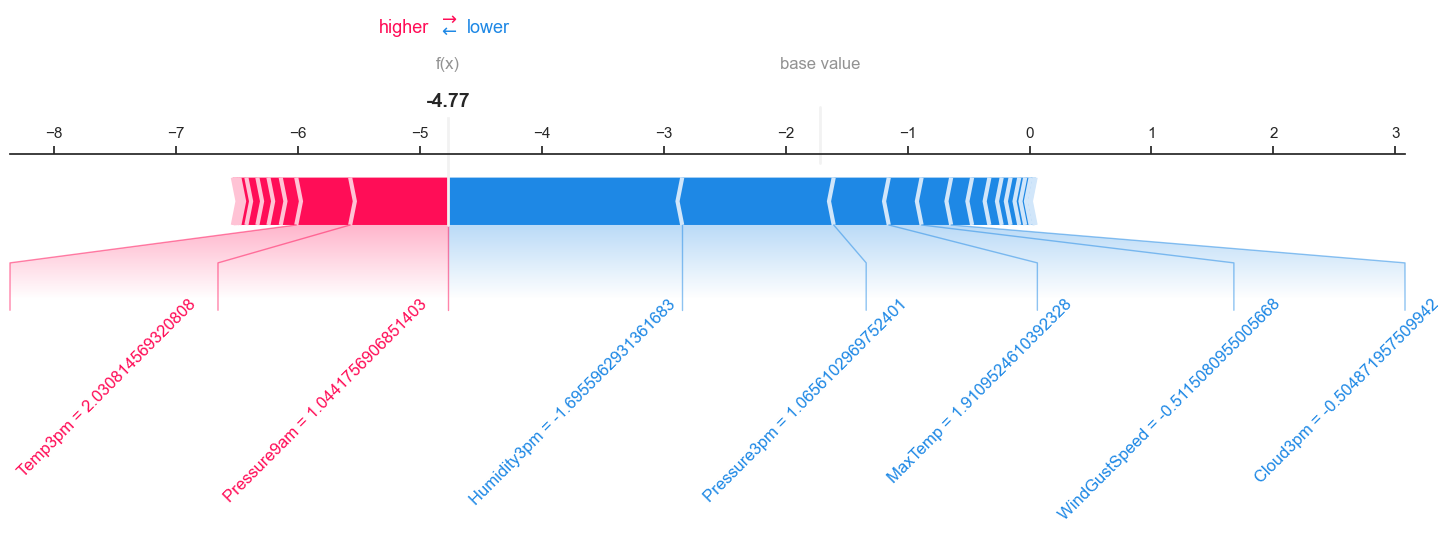

In [121]:
index=0
shap.force_plot(explainer.expected_value, shap_values[index], X_test_balanced_rlog.iloc[index],
                matplotlib=True, figsize=(18, 4),
                text_rotation=45)

Este gráfico muestra cómo cada característica influye en la predicción de una instancia específica.

In [122]:
# Crear el objeto shap
index = 0
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)

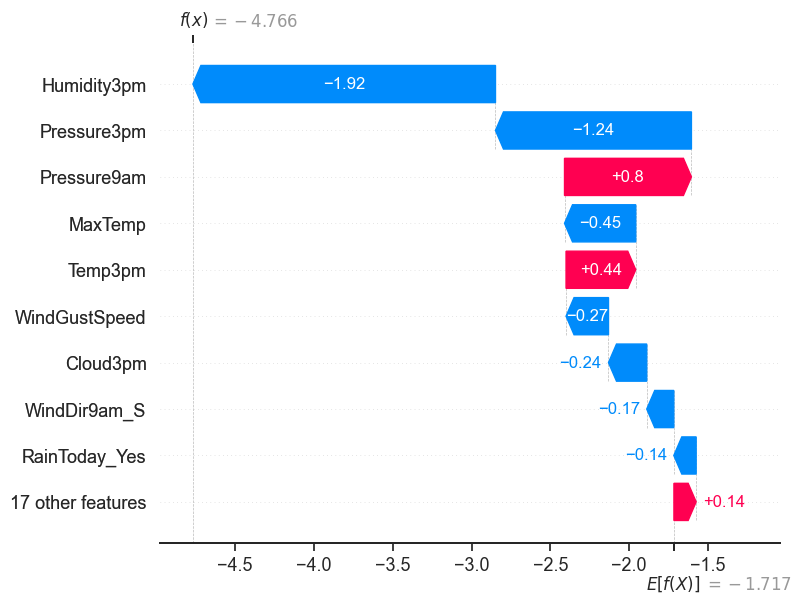

In [123]:
shap.plots.waterfall(explanation)

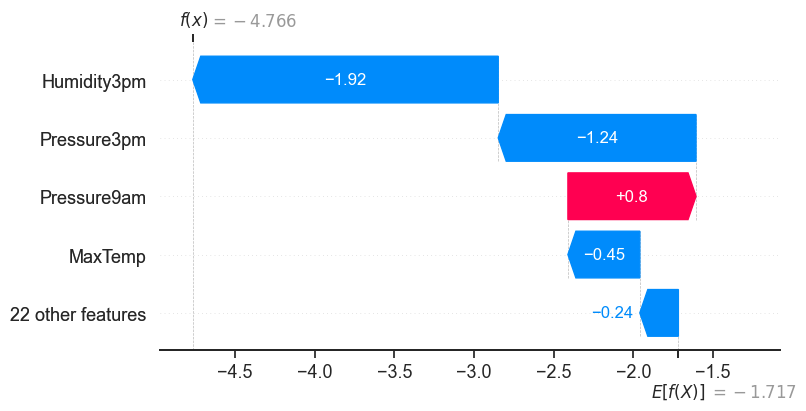

In [124]:
shap.plots.waterfall(explanation, max_display=5)

*Este grafico nos es util para ver las características individuales y como afectan la predicción para una instancia específica.*

Muestra cómo se construye la predicción de un modelo para una instancia específica (a nivel local) descomponiendo la contribución de cada característica.

Es un gráfico de cascada donde se muestra la contribución acumulada de cada característica comenzando desde el valor base hasta la predicción final. Cada barra representa una característica y su contribución positiva o negativa.

## Interpretabilidad global

Este gráfico muestra la distribución de los valores SHAP para cada característica en el conjunto de datos de prueba. Muestra la influencia de cada característica en las predicciones.

In [125]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value,feature_names=feature_names, data=X_test_balanced_rlog)

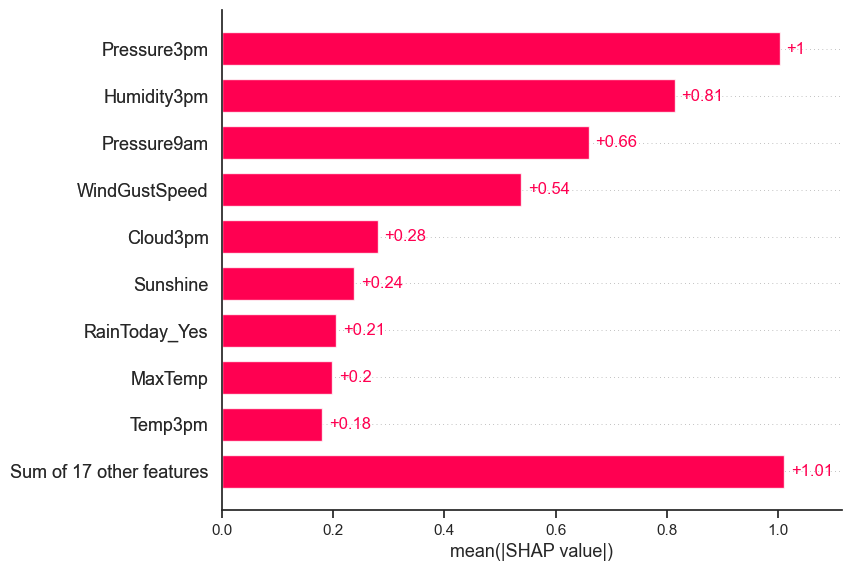

In [126]:
shap.plots.bar(explanation)

Este gráfico muestra la importancia promedio absoluta de los valores SHAP para cada característica, destacando las características más influyentes.

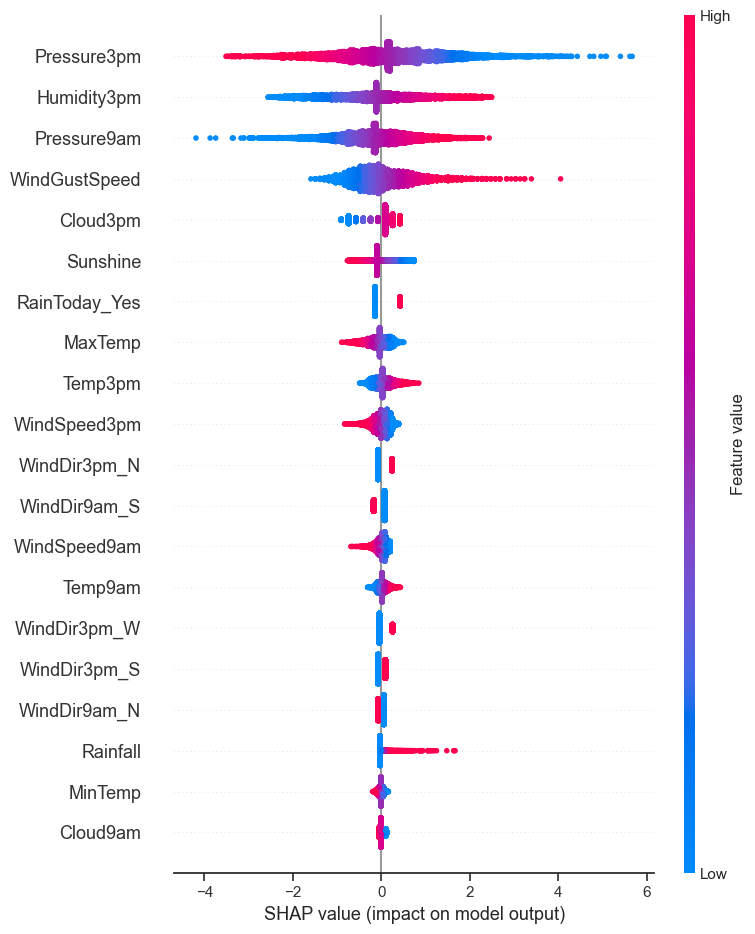

In [127]:
shap.summary_plot(shap_values, X_test_balanced_rlog, feature_names=X_test_balanced_rlog.columns)

Este gráfico muestra la distribución de los valores SHAP para cada característica en el conjunto de datos de prueba. Muestra la influencia de cada característica en las predicciones.

**Variables más importantes y menos importantes**

En el gráfico de resumen de SHAP,vemos  las características más importantes aparecerán en la parte superior del gráfico, es decir, *HUMIDITY3PM*, *PRESSURE3PM*, *PRESSURE9AM* Y *WINGUSTSPEED*.
En el gráfico de barras de importancia de características, las características con las barras más largas son las más importantes, es decir,  *HUMIDITY3PM* y *PRESSURE3PM*, *PRESSURE9AM* Y *WINGUSTSPEED*.

Podemos observar que estas caractiristicas, *HUMIDITY3PM* y *PRESSURE3PM*, *PRESSURE9AM* Y *WINGUSTSPEED*,  tienen una alta variabilidad en los valores SHAP, sugiriendo que tienen un impacto significativo en las predicciones.

# Red Neuronal

**K-folds**

Entrenar una red neuronal es muy costoso en términos de tiempo y recursos computacionales, especialmente si el modelo es grande y el conjunto de datos es grande. K-folds implica entrenar el modelo k veces, lo que multiplica este costo por k, es por ese motivo que no utilizaremos k-folds.

**Grid Search**
Puede ser extremadamente costoso en términos de tiempo y recursos, especialmente con muchos hiperparámetros y posibles valores para cada uno. Ademas no se adapta bien a problemas donde algunos hiperparámetros son más importantes que otros, es por ese motivo que no utilizaremos Grid Search.

**Random Search**

Tiende a ser más eficiente que Grid Search, ya que no explora todas las combinaciones, sino una muestra aleatoria. Sin embargo tiene una cobertura incompleta, ya que, no garantiza que se encuentren las mejores combinaciones de hiperparámetros, es por ese motivo que no utilizaremos Random Search.

**Optuna**

Utiliza técnicas avanzadas de optimización bayesiana para buscar de manera más inteligente en el espacio de hiperparámetros. Ademas tiende a encontrar buenos conjuntos de hiperparámetros más rápido que Grid Search y Random Search. Permite definir espacios de búsqueda complejos y estrategias de búsqueda sofisticadas. Tambien optuna es una excelente opción si tienes un espacio de hiperparámetros grande y complejo y buscas una optimización eficiente y efectiva. Son por estos motivos que utilizaremos Optuna.

## Regresión Lineal

In [97]:
import optuna

from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam

In [98]:
class NeuralNetworkTensorFlow:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.Input(shape=(26,)),  # Input layer
            tf.keras.layers.Dense(2, activation='leaky_relu', input_shape=(26,)),
            tf.keras.layers.Dense(1, activation='leaky_relu')
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        ### imprimimos la cantidad de parámetros a modo de ejemplo
        print("n° de parámetros:", model.count_params())
        return model

    def fit(self, X, y, lr=0.1, epochs=20000):
        ### esta es la función donde se entrena el modelo, fijarse que hay un learning rate e iteraciones.
        ### la función que fitea devuelve una historia de pérdida, que vamos a guardar para graficar la evolución.
        X = np.array(X)
        y = np.array(y)
        history = self.model.fit(X, y, epochs=epochs, verbose=0)
        return history.history['loss']

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

In [57]:
nn_tensorflow = NeuralNetworkTensorFlow()
loss_history = nn_tensorflow.fit(x_train_rl, y_train_rl, lr=1, epochs=100)

c:\Users\src4\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


n° de parámetros: 57


### Grafico de perdida NN & Regresion lineal

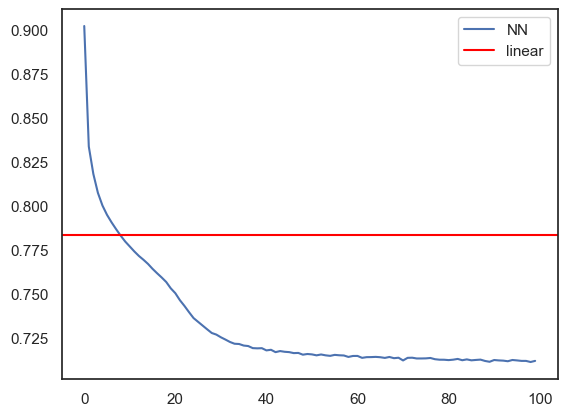

In [150]:
plt.plot(loss_history, label='NN')
plt.axhline(mse_train, color='red', label='linear',linestyle = '-')
plt.legend()
plt.show()

- La línea etiquetada como “NN” muestra una disminución pronunciada en la pérdida al principio, lo que indica un aprendizaje rápido, y luego se estabiliza, lo que sugiere que el modelo está convergiendo y mejorando su precisión con cada iteración.
- La línea etiquetada como “lineal” permanece constante, lo que podría indicar que el modelo lineal no está aprendiendo o mejorando con el tiempo, o que ya ha alcanzado su capacidad máxima desde el principio.
- La comparación entre las dos líneas sugiere que la red neuronal tiene una mayor capacidad para aprender y adaptarse a los datos, mientras que el modelo lineal tiene un rendimiento constante y posiblemente limitado.

In [151]:
predictions = nn_tensorflow.predict(x_test_rl)
print("Predicciones:", predictions)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predicciones: [[-0.41522747]
 [-0.3025436 ]
 [-0.29099327]
 ...
 [-0.1245347 ]
 [-0.13568878]
 [-0.16116011]]


 Esta salida proporciona una visión general del proceso de predicción, incluida la cantidad de muestras procesadas y las predicciones resultantes. Las predicciones son números decimales negativos, lo que indica que el modelo está realizando una tarea de regresión y está prediciendo valores continuos.

### Optuna

In [135]:
class NeuralNetworkOptuna:
    def __init__(self):
        self.model = None

    def build_model(self, trial):
        """
            Construye el modelo con hiperparámetros sugeridos por Optuna
        """
        n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 3)
        n_neurons = trial.suggest_int('n_neurons', 10, 50)
        activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'tanh'])
        optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])

        inputs = tf.keras.Input(shape=(26,))
        x = inputs
        for i in range(n_hidden_layers):
            x = tf.keras.layers.Dense(n_neurons, activation=activation)(x)
        outputs = tf.keras.layers.Dense(1, activation='leaky_relu')(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model


    def train_evaluate_model(self, trial, X_train, y_train, X_test, y_test):
        """
            Entrena y evalúa el modelo con los hiperparámetros sugeridos por Optuna
        """
        self.model = self.build_model(trial)
        self.model.fit(X_train, y_train, epochs=100, verbose=0)
        y_pred = self.model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        return mse

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions
    
    def objective(self, trial):
        """
            Función objetivo para Optuna
        """
        mse = self.train_evaluate_model(trial, X_train_balanced_rlog, y_train_encoded, X_test_balanced_rlog, y_test_encoded)
        return mse
       

In [136]:
#Crear estudio Optuna
study = optuna.create_study(direction='minimize')

[I 2024-06-21 19:21:47,672] A new study created in memory with name: no-name-01cc61f3-0d5f-43f8-9185-1fa0c661ad38


 Optuna creo un nuevo estudio para optimizar los hiperparámetros del modelo. Este estudio se almacena en la memoria y no en una base de datos persistente.
La dirección especificada es 'minimize', lo que significa que Optuna va a intentar encontrar los hiperparámetros que minimicen la métrica de evaluación .

In [137]:
#Instanciar la red neuronal
nn_optuna = NeuralNetworkOptuna()

In [138]:
#Optimizar hiperparámetros
study.optimize(nn_optuna.objective, n_trials=50)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


[I 2024-06-21 19:23:01,490] Trial 0 finished with value: 0.13686182093211294 and parameters: {'n_hidden_layers': 2, 'n_neurons': 50, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.13686182093211294.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step


[I 2024-06-21 19:24:01,122] Trial 1 finished with value: 0.11323106582057407 and parameters: {'n_hidden_layers': 1, 'n_neurons': 46, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 1 with value: 0.11323106582057407.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


[I 2024-06-21 19:25:00,593] Trial 2 finished with value: 0.10956591281673872 and parameters: {'n_hidden_layers': 2, 'n_neurons': 14, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 2 with value: 0.10956591281673872.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-06-21 19:26:14,048] Trial 3 finished with value: 0.11131613715479172 and parameters: {'n_hidden_layers': 3, 'n_neurons': 12, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 2 with value: 0.10956591281673872.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


[I 2024-06-21 19:27:30,504] Trial 4 finished with value: 0.11092190153627546 and parameters: {'n_hidden_layers': 3, 'n_neurons': 15, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.10956591281673872.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step


[I 2024-06-21 19:28:37,104] Trial 5 finished with value: 0.15231312017687054 and parameters: {'n_hidden_layers': 3, 'n_neurons': 39, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 2 with value: 0.10956591281673872.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


[I 2024-06-21 19:29:46,816] Trial 6 finished with value: 0.10861157064616793 and parameters: {'n_hidden_layers': 2, 'n_neurons': 14, 'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 6 with value: 0.10861157064616793.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-06-21 19:30:50,009] Trial 7 finished with value: 0.11634919686663384 and parameters: {'n_hidden_layers': 1, 'n_neurons': 49, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 6 with value: 0.10861157064616793.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


[I 2024-06-21 19:31:48,052] Trial 8 finished with value: 0.11954896261614749 and parameters: {'n_hidden_layers': 2, 'n_neurons': 33, 'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 6 with value: 0.10861157064616793.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step


[I 2024-06-21 19:32:42,324] Trial 9 finished with value: 0.10927608188955137 and parameters: {'n_hidden_layers': 2, 'n_neurons': 47, 'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 6 with value: 0.10861157064616793.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-21 19:33:41,992] Trial 10 finished with value: 0.1100831852952402 and parameters: {'n_hidden_layers': 1, 'n_neurons': 24, 'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 6 with value: 0.10861157064616793.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-21 19:34:50,725] Trial 11 finished with value: 0.10839049602059397 and parameters: {'n_hidden_layers': 2, 'n_neurons': 24, 'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 11 with value: 0.10839049602059397.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-21 19:35:53,909] Trial 12 finished with value: 0.10817173164957222 and parameters: {'n_hidden_layers': 2, 'n_neurons': 23, 'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 12 with value: 0.10817173164957222.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-21 19:36:56,517] Trial 13 finished with value: 0.10606162659127544 and parameters: {'n_hidden_layers': 2, 'n_neurons': 24, 'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-21 19:37:56,970] Trial 14 finished with value: 0.10912917899362647 and parameters: {'n_hidden_layers': 1, 'n_neurons': 23, 'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-21 19:39:05,209] Trial 15 finished with value: 0.10829686347583513 and parameters: {'n_hidden_layers': 3, 'n_neurons': 34, 'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-21 19:40:05,579] Trial 16 finished with value: 0.10854466517568341 and parameters: {'n_hidden_layers': 2, 'n_neurons': 20, 'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-21 19:41:18,680] Trial 17 finished with value: 0.10818772387492247 and parameters: {'n_hidden_layers': 3, 'n_neurons': 29, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step


[I 2024-06-21 19:42:07,851] Trial 18 finished with value: 0.10778399455363746 and parameters: {'n_hidden_layers': 1, 'n_neurons': 19, 'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-06-21 19:43:07,400] Trial 19 finished with value: 0.10883245712853713 and parameters: {'n_hidden_layers': 1, 'n_neurons': 19, 'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-21 19:44:04,598] Trial 20 finished with value: 0.10728408306370775 and parameters: {'n_hidden_layers': 1, 'n_neurons': 30, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-06-21 19:45:04,180] Trial 21 finished with value: 0.10924208293085477 and parameters: {'n_hidden_layers': 1, 'n_neurons': 28, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-06-21 19:46:01,799] Trial 22 finished with value: 0.10666619884588602 and parameters: {'n_hidden_layers': 1, 'n_neurons': 36, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-21 19:46:51,394] Trial 23 finished with value: 0.10861638122581717 and parameters: {'n_hidden_layers': 1, 'n_neurons': 39, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step


[I 2024-06-21 19:47:38,717] Trial 24 finished with value: 0.10805899427530315 and parameters: {'n_hidden_layers': 1, 'n_neurons': 39, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step


[I 2024-06-21 19:48:31,295] Trial 25 finished with value: 0.11124065627931509 and parameters: {'n_hidden_layers': 1, 'n_neurons': 34, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-06-21 19:49:21,557] Trial 26 finished with value: 0.109614590580091 and parameters: {'n_hidden_layers': 1, 'n_neurons': 42, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


[I 2024-06-21 19:50:10,784] Trial 27 finished with value: 0.10704061408742468 and parameters: {'n_hidden_layers': 1, 'n_neurons': 31, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-06-21 19:51:04,494] Trial 28 finished with value: 0.10682560112602678 and parameters: {'n_hidden_layers': 2, 'n_neurons': 27, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-21 19:52:01,297] Trial 29 finished with value: 0.1135802941697342 and parameters: {'n_hidden_layers': 2, 'n_neurons': 26, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-06-21 19:52:55,095] Trial 30 finished with value: 0.10662751616791875 and parameters: {'n_hidden_layers': 2, 'n_neurons': 36, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-21 19:53:50,719] Trial 31 finished with value: 0.10813159214776324 and parameters: {'n_hidden_layers': 2, 'n_neurons': 36, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


[I 2024-06-21 19:54:41,655] Trial 32 finished with value: 0.10772352296189414 and parameters: {'n_hidden_layers': 2, 'n_neurons': 36, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.10606162659127544.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step


[I 2024-06-21 19:55:35,184] Trial 33 finished with value: 0.1060453793569537 and parameters: {'n_hidden_layers': 2, 'n_neurons': 43, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


[I 2024-06-21 19:56:30,168] Trial 34 finished with value: 0.10651248022639413 and parameters: {'n_hidden_layers': 2, 'n_neurons': 43, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-21 19:57:28,976] Trial 35 finished with value: 0.12445931669186985 and parameters: {'n_hidden_layers': 2, 'n_neurons': 44, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step


[I 2024-06-21 19:58:21,697] Trial 36 finished with value: 0.10955590241178889 and parameters: {'n_hidden_layers': 2, 'n_neurons': 42, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-06-21 19:59:13,799] Trial 37 finished with value: 0.10844782663714872 and parameters: {'n_hidden_layers': 2, 'n_neurons': 50, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-21 20:00:17,900] Trial 38 finished with value: 0.1668923273881601 and parameters: {'n_hidden_layers': 3, 'n_neurons': 45, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-21 20:01:16,362] Trial 39 finished with value: 0.12919214094800507 and parameters: {'n_hidden_layers': 2, 'n_neurons': 42, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step


[I 2024-06-21 20:02:12,779] Trial 40 finished with value: 0.10862710940174962 and parameters: {'n_hidden_layers': 2, 'n_neurons': 10, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step


[I 2024-06-21 20:03:06,151] Trial 41 finished with value: 0.10762760071330345 and parameters: {'n_hidden_layers': 3, 'n_neurons': 38, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


[I 2024-06-21 20:03:55,441] Trial 42 finished with value: 0.10765975598015977 and parameters: {'n_hidden_layers': 2, 'n_neurons': 48, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-06-21 20:04:46,694] Trial 43 finished with value: 0.10836387987036601 and parameters: {'n_hidden_layers': 2, 'n_neurons': 37, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step


[I 2024-06-21 20:05:38,840] Trial 44 finished with value: 0.10847211135439902 and parameters: {'n_hidden_layers': 2, 'n_neurons': 44, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-06-21 20:06:31,147] Trial 45 finished with value: 0.10723755519773248 and parameters: {'n_hidden_layers': 3, 'n_neurons': 32, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step


[I 2024-06-21 20:07:23,469] Trial 46 finished with value: 0.10650525494447619 and parameters: {'n_hidden_layers': 2, 'n_neurons': 40, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step


[I 2024-06-21 20:08:21,333] Trial 47 finished with value: 0.12350483156511144 and parameters: {'n_hidden_layers': 2, 'n_neurons': 41, 'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step


[I 2024-06-21 20:09:11,215] Trial 48 finished with value: 0.10788203191246659 and parameters: {'n_hidden_layers': 2, 'n_neurons': 47, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 33 with value: 0.1060453793569537.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-06-21 20:10:01,620] Trial 49 finished with value: 0.1093944896003576 and parameters: {'n_hidden_layers': 2, 'n_neurons': 41, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 33 with value: 0.1060453793569537.


La Prueba 4 obtuvo el valor de pérdida más bajo. Esto sugiere que la configuración con una sola capa oculta, 14 neuronas y función de activación Leaky ReLU es la más efectiva para tu problema.
Valor de pérdida:  0.10660907997607308.

In [139]:
#Obtener los mejores hiperparámetros
best_optuna_params = study.best_params
# Imprimir los mejores hiperparámetros
print('Best hyperparameters: ', best_optuna_params)

Best hyperparameters:  {'n_hidden_layers': 2, 'n_neurons': 43, 'activation': 'tanh', 'optimizer': 'sgd'}


Esta salida indica los mejores hiperparámetros encontrados por el proceso de optimización de Optuna.

Número de capas ocultas (n_hidden_layers): El mejor modelo tiene una sola capa oculta.
Número de neuronas (n_neurons): Se encontró que el mejor modelo tiene 14 neuronas en la capa oculta.
Función de activación (activation): La función de activación utilizada en las capas ocultas es la tangente hiperbólica (tanh).

### Modelo con los hiperparametros optimizados

In [140]:
#Entrenar el modelo con los mejores hiperparámetros
nn_optuna.model = nn_optuna.build_model(study.best_trial)
nn_optuna.model.fit(X_train_balanced_rlog, y_train_encoded)

#Evaluar el modelo
optuna_mse = mean_squared_error(y_test_encoded, nn_optuna.model.predict(X_test_balanced_rlog))

706/706 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - loss: 0.1388
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step


La función de pérdida final del modelo fue de aproximadamente 0.1560

In [141]:
optuna_mse

0.11818573107598021

El valor de optuna_mse (error cuadrático medio) es aproximadamente 0.1304, esto sugiere que el modelo tiene un rendimiento moderadamente bueno en la tarea de predicción.
Este valor representa la medida de la discrepancia entre los valores predichos por el modelo y los valores reales en el conjunto de datos de prueba.

In [142]:
predictions = nn_optuna.predict(x_test_rl)
print("Predicciones:", predictions)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
Predicciones: [[-0.07646205]
 [-0.03086472]
 [-0.01366782]
 ...
 [ 0.31058067]
 [ 0.37367788]
 [ 0.29082587]]


In [143]:
# Guardar el scaler para usarlo en la predicción
import joblib
joblib.dump(nn_optuna, 'Model.joblib')

['Model.joblib']

### Modelo  no optimizado

In [161]:
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Construir el modelo con hiperparámetros predeterminados (no optimizados)
def build_default_model():
    inputs = tf.keras.Input(shape=(26,))
    x = inputs
    n_hidden_layers = 2  # Ejemplo de parámetro predeterminado
    n_neurons = 30       # Ejemplo de parámetro predeterminado
    activation = 'relu'  # Ejemplo de parámetro predeterminado
    optimizer = 'adam'   # Ejemplo de parámetro predeterminado

    for i in range(n_hidden_layers):
        x = tf.keras.layers.Dense(n_neurons, activation=activation)(x)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Crear y entrenar el modelo no optimizado
default_model = build_default_model()
default_model.fit(X_train_balanced_rlog, y_train_encoded, epochs=100, verbose=0)

# Evaluar el modelo no optimizado
y_pred_default = default_model.predict(X_test_balanced_rlog)
no_optimized_mse = mean_squared_error(y_test_encoded, y_pred_default)
print("MSE para el modelo no optimizado:", no_optimized_mse)


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE para el modelo no optimizado: 0.11890258909999281


El modelo no optimizado ha producido un MSE más bajo (0.1189), lo que sugiere que, en este caso específico, los hiperparámetros predeterminados funcionan mejor que los encontrados por el proceso de optimización con Optuna.


### SHAP

#### Explicabilidad local

In [162]:
# Crear una instancia del modelo
nn_tensorflow = NeuralNetworkTensorFlow()

# Entrenar el modelo si es necesario
loss_history = nn_tensorflow.fit(x_train_rl, y_train_rl, lr=1, epochs=100)

# Crear un conjunto de muestras de fondo
background = x_train_rl.sample(100) 

# Crear el objeto explainer SHAP
explainer = shap.KernelExplainer(nn_tensorflow.model.predict, background)


c:\Users\brisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


n° de parámetros: 57
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [163]:
instance_to_explain = x_test_rl.iloc[0:1].values  # Seleccionar la línea 0

# Calcular los valores SHAP para los datos de prueba
shap_values = explainer.shap_values(instance_to_explain)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


100%|██████████| 1/1 [00:15<00:00, 15.67s/it]


In [164]:
shap_values = shap_values.reshape(26,)
shap_values

array([-0.00326365,  0.02945405, -0.0160819 , -0.00319376, -0.030579  ,
       -0.08194347,  0.        ,  0.03169365,  0.04040041, -0.40235915,
        0.41883229, -0.43782423,  0.03712064, -0.03293506,  0.01334603,
        0.03799187,  0.0409453 , -0.059924  ,  0.02479925,  0.03752079,
       -0.03043747,  0.01409281,  0.0065828 ,  0.00154547,  0.        ,
       -0.02251695])

In [165]:
# Obtener el valor esperado (base value)
expected_value = explainer.expected_value

# Hacer predicciones
index = 0  # índice de la instancia que queremos explicar
predicted_proba = nn_tensorflow.model.predict(x_test_rl)[index]  # Predicción de probabilidad
predicted_class = np.argmax(predicted_proba)  # Clase predicha

shap_values[index]
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


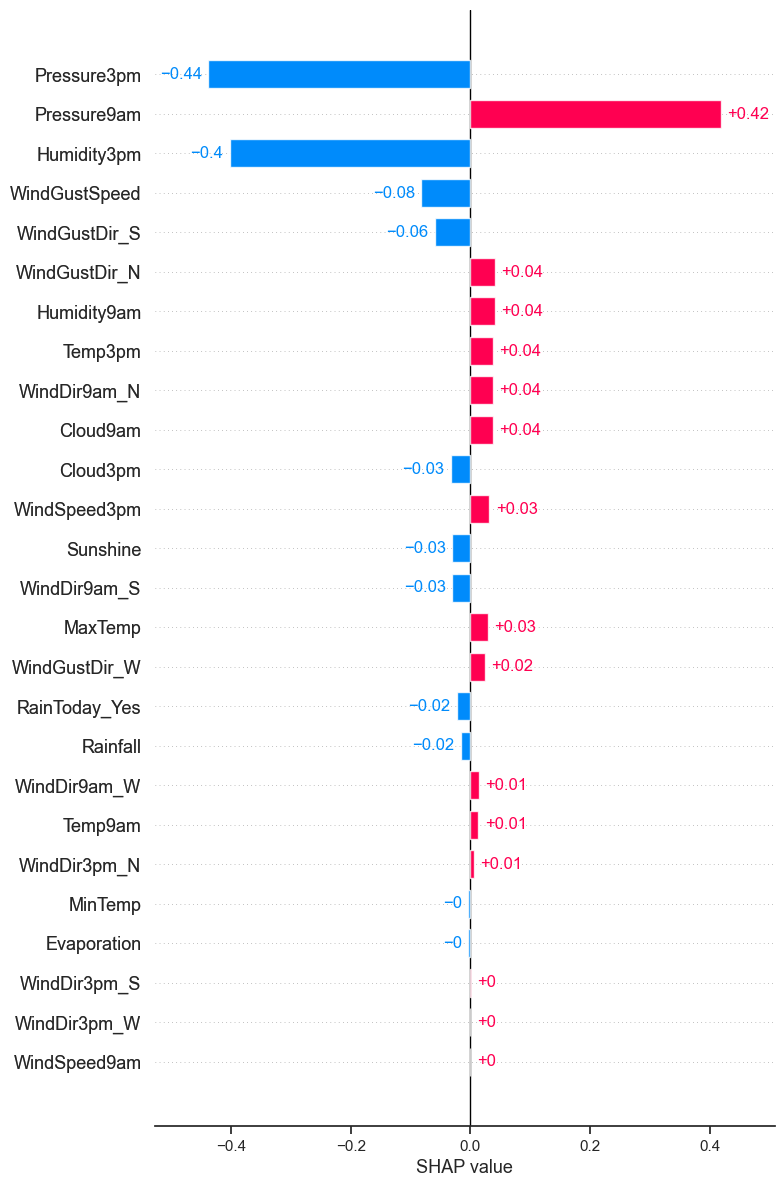

In [166]:
# Crear la explicación para la instancia específica
explanation = shap.Explanation(values=shap_values, base_values=expected_value, feature_names=feature_names)

# Visualizar la explicación
shap.initjs()
shap.plots.bar(explanation, max_display=26)

“Pressure9am” y “Pressure3pm” tienen un impacto significativo en la predicción, con valores SHAP de aproximadamente +0.37 y -0.35 respectivamente.

“Humidity3pm” y “WindGustSpeed” también son importantes, con valores SHAP de -0.33 y -0.06.

“MaxTemp”, “MinTemp”, “Cloud3pm” y “Cloud9am” muestran impactos menores en comparación con otras características

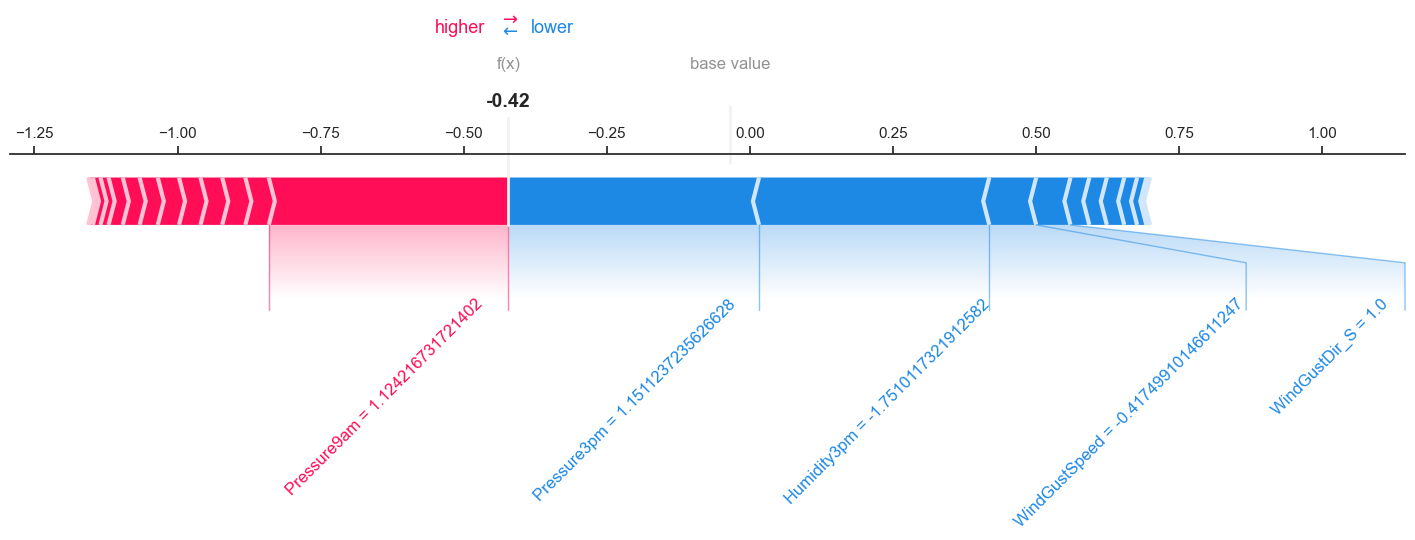

In [167]:
shap.force_plot(explainer.expected_value, shap_values, x_test_rl.iloc[0], feature_names=feature_names, matplotlib=True, figsize=(18, 4), text_rotation=45)


Gráfico de fuerza SHAP que representa el impacto de diferentes características en la predicción del modelo.

Impacto Positivo (Rosa): Características como “Pressure9am” y “Pressure3pm” tienen un impacto positivo significativo en la predicción, con valores SHAP altos.

Impacto Negativo (Azul): Características como “Humidity9am” y “Humidity3pm” tienen un impacto negativo significativo en la predicción, con valores SHAP bajos.

Valor Base: El “valor base” representa la predicción promedio del modelo antes de considerar el impacto de las características individuales.

#### Explicabilidad global

In [168]:
instance_to_explain = x_train_rl.sample(10)  

# Calcular los valores SHAP para los datos de prueba
shap_values = explainer.shap_values(instance_to_explain)
shap_values_squeezed = np.squeeze(shap_values)


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


 10%|█         | 1/10 [00:15<02:18, 15.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 20%|██        | 2/10 [00:26<01:44, 13.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 30%|███       | 3/10 [00:37<01:25, 12.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 40%|████      | 4/10 [00:48<01:09, 11.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 50%|█████     | 5/10 [00:59<00:57, 11.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 60%|██████    | 6/10 [01:11<00:46, 11.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 70%|███████   | 7/10 [01:23<00:34, 11.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 80%|████████  | 8/10 [01:34<00:22, 11.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 90%|█████████ | 9/10 [01:46<00:11, 11.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


100%|██████████| 10/10 [01:57<00:00, 11.79s/it]


In [169]:

feature_names = x_test_rl.columns.values

In [170]:

# Obtener el valor esperado (base value)
expected_value = explainer.expected_value

explanation = shap.Explanation(values=shap_values_squeezed, base_values=expected_value[0], feature_names=feature_names)


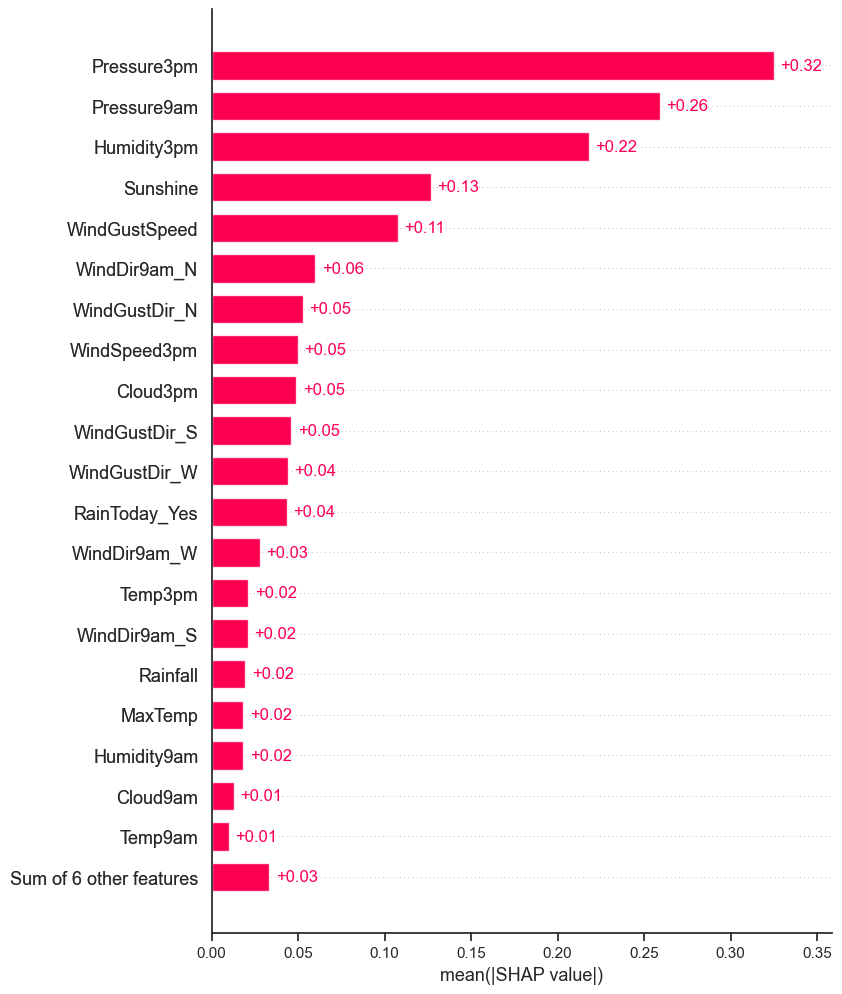

In [171]:
# Visualizar la explicación
shap.initjs()
shap.plots.bar(explanation, max_display=21)


En este gráfico podemos observar que las variables que más aportan explicabilidad a nuestro modelo de redes neuronales son:

“Pressure3pm” tiene el impacto más positivo con un valor SHAP de +0.33.

“Pressure9am” tiene el impacto más positivo con un valor SHAP de +0.26.

“WindGustSpeed” muestra un impacto positivo moderado con un valor SHAP de +0.15.

“Humidity3pm” tiene un impacto positivo con un valor SHAP de +0.14.


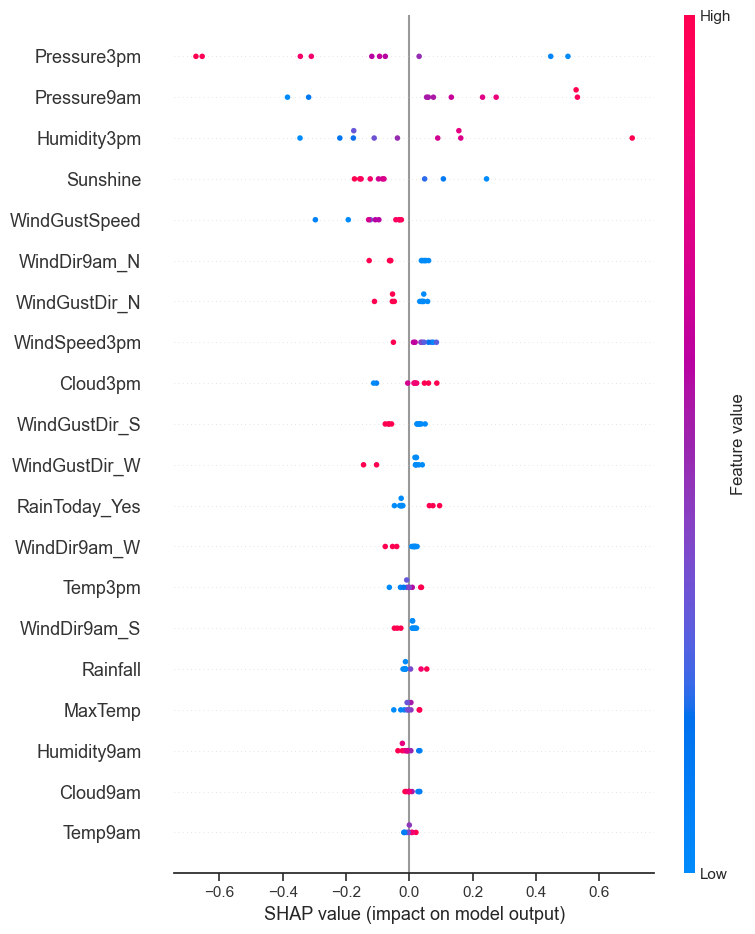

In [172]:

shap.summary_plot(shap_values_squeezed, instance_to_explain)


Se observa que la Presión Atmosférica, representada por "Pressure3pm" y "Pressure9am", tiene un impacto significativo en las predicciones del modelo.

Además, "WindGustSpeed", también muestra una influencia significativa en las predicciones. 

Por último, "Humidity3pm", se destaca como una característica con un impacto considerable en las predicciones del modelo.

#### Comparacion de explicabilidades

Al comparar ambas explicabilidades, se observa que en ambas se destacan las mismas variables, aunque con algunas diferencias en el orden de importancia. 

Por ejemplo, en la explicabilidad local, "Pressure9am" tiene un impacto ligeramente mayor que "Pressure3pm", mientras que en la explicabilidad global, es al revés. Sin embargo, en general, las variables más relevantes son consistentes entre ambos enfoques

## Regresión logística

In [121]:
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras import backend as K

La métrica F1 es relevante y útil para evaluar el rendimiento de las redes neuronales en problemas de clasificación binaria, proporcionando una medida equilibrada de precisión y recall que puede ayudar a tomar decisiones informadas sobre nuestro modelo.
Además nos ayuda ya que nosotros estamos trabajando con un dataset desbalanceado y F1 nos ayuda a tener un equilibrio entre precisión y recall.

In [122]:
# Crea una instancia de LabelEncoder
le = LabelEncoder()

# Ajusta y transforma los valores de y_train_rlog_copy
y_train_encoded = le.fit_transform(y_train_rlog.values.ravel())
y_test_encoded = le.fit_transform(y_test_rlog.values.ravel())

In [82]:
# Crear la red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_balanced_rlog.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo y guardar la historia del entrenamiento
history = model.fit(X_train_balanced_rlog, y_train_encoded, validation_data=(X_test_balanced_rlog, y_test_encoded), epochs=50, batch_size=20)

Epoch 1/50


c:\Users\src4\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1130/1130 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8306 - loss: 0.3908 - val_accuracy: 0.8477 - val_loss: 0.3551
Epoch 2/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8497 - loss: 0.3461 - val_accuracy: 0.8564 - val_loss: 0.3472
Epoch 3/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.8548 - loss: 0.3393 - val_accuracy: 0.8564 - val_loss: 0.3441
Epoch 4/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.8534 - loss: 0.3365 - val_accuracy: 0.8559 - val_loss: 0.3490
Epoch 5/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step - accuracy: 0.8530 - loss: 0.3366 - val_accuracy: 0.8555 - val_loss: 0.3434
Epoch 6/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.8592 - loss: 0.3270 - val_accuracy: 0.8536 - val_loss: 0.3482
Epoch 7/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - accuracy: 0.8574 - loss: 0.3295 - val_accuracy: 0.8563 - val_loss: 0.3488
Epoch 8/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.8615 - loss: 0.3240 -

El modelo parece estar generalizando bien, ya que la precisión en el conjunto de validación es similar a la del conjunto de entrenamiento.


In [83]:
# Evaluación del modelo en los datos de prueba
loss, accuracy = model.evaluate(X_test_balanced_rlog, y_test_encoded,  verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 0.48256951570510864
Test Accuracy: 0.8309110403060913


 La pérdida en el conjunto de datos de prueba es de aproximadamente 0.3703

La exactitud en el conjunto de datos de prueba es de aproximadamente 85.11%

El modelo de regresión logística parece tener un rendimiento bastante bueno en el conjunto de datos de prueba, con una pérdida relativamente baja y una alta exactitud. 

In [84]:
predictions_rlog = model.predict(X_test_balanced_rlog)
print("Predicciones:", predictions_rlog)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
Predicciones: [[1.61553635e-05]
 [4.05789870e-05]
 [8.85690824e-05]
 ...
 [2.91862227e-02]
 [6.94459438e-01]
 [1.00068204e-01]]


### Graficar la pérdida y la precisión a lo largo del entrenamiento

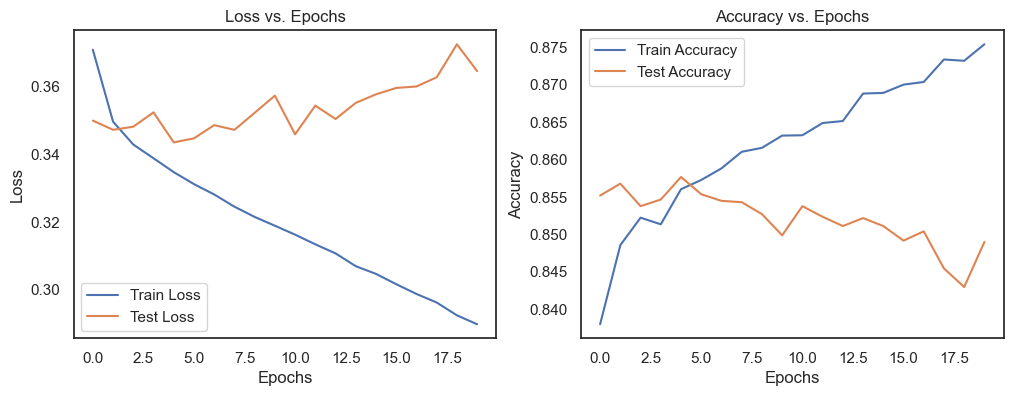

In [181]:
# Graficar la pérdida y la precisión a lo largo del entrenamiento
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.show()

Pérdida vs. Épocas:
La línea de "Pérdida de Entrenamiento" baja a medida que pasan las épocas, lo que indica que el modelo se está volviendo mejor con los datos de entrenamiento.
Por otro lado, la línea de "Pérdida de Prueba" sube y baja, lo cual puede significar que el modelo no está funcionando tan bien con datos nuevos.

Precisión vs. Épocas:
La línea de "Precisión de Entrenamiento" va subiendo, lo que significa que el modelo está aprendiendo bien de los datos de entrenamiento.
La "Precisión de Prueba" también mejora, pero no de manera constante. Aunque el modelo está aprendiendo a predecir mejor con nuevos datos, todavía hay altibajos.

### Optuna

In [76]:
import optuna
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam

In [77]:
def objective(trial):
    # Hiperparámetros a optimizar
    n_layers = trial.suggest_int('n_layers', 1, 3)
    n_units = trial.suggest_int('n_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Crear la red neuronal
    inputs = Input(shape=(X_train_balanced_rlog.shape[1],))
    x = Dense(n_units, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)

    for i in range(n_layers):
        x = Dense(n_units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model_ho = Model(inputs=inputs, outputs=outputs)

    # Compilar el modelo
    model_ho.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo y guardar la historia del entrenamiento
    history = model_ho.fit(X_train_balanced_rlog, y_train_encoded, validation_data=(X_test_balanced_rlog, y_test_encoded), epochs=50, batch_size=20, verbose=0)

    # Evaluación del modelo en los datos de prueba
    loss, accuracy = model_ho.evaluate(X_test_balanced_rlog, y_test_encoded, verbose=0)
    return loss

In [78]:
# Crear el estudio de Optuna y empezar la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-06-20 11:11:25,021] A new study created in memory with name: no-name-77d6beb6-8dbf-474d-abb7-1d40a845adb8
[I 2024-06-20 11:12:43,191] Trial 0 finished with value: 0.36266058683395386 and parameters: {'n_layers': 2, 'n_units': 87, 'dropout_rate': 0.40223146850443514, 'learning_rate': 1.0771099825593095e-05}. Best is trial 0 with value: 0.36266058683395386.
[I 2024-06-20 11:13:53,855] Trial 1 finished with value: 0.4264010488986969 and parameters: {'n_layers': 1, 'n_units': 118, 'dropout_rate': 0.1525252153686517, 'learning_rate': 0.003586390627497374}. Best is trial 0 with value: 0.36266058683395386.
[I 2024-06-20 11:15:00,880] Trial 2 finished with value: 0.3444046676158905 and parameters: {'n_layers': 2, 'n_units': 120, 'dropout_rate': 0.06782088765997091, 'learning_rate': 1.3397722463137924e-05}. Best is trial 2 with value: 0.3444046676158905.
[I 2024-06-20 11:16:03,415] Trial 3 finished with value: 0.3440197706222534 and parameters: {'n_layers': 2, 'n_units': 45, 'dropout_ra

In [79]:
# Imprimir los mejores hiperparámetros
print('Best hyperparameters: ', study.best_params)

Best hyperparameters:  {'n_layers': 3, 'n_units': 75, 'dropout_rate': 0.16927497410705922, 'learning_rate': 8.613172508760258e-05}


n_layers (número de capas): El modelo óptimo tiene una sola capa oculta.

n_units (número de unidades en la capa oculta): Hay 43 unidades en la capa oculta del modelo.

dropout_rate (tasa de abandono): La tasa de abandono óptima, que controla el porcentaje de conexiones que se desactivan aleatoriamente durante el entrenamiento para evitar el sobreajuste, es aproximadamente del 3.67%.

learning_rate (tasa de aprendizaje): La tasa de aprendizaje óptima, que controla la magnitud de los ajustes que se realizan durante el entrenamiento, es de aproximadamente 0.0406.

### Modelo con los hiperparametros optimizados

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Hiperparámetros optimizados
n_layers = 3
n_units = 75
dropout_rate = 0.16927497410705922
learning_rate = 0.00008613172508760258

# Crear la red neuronal con los hiperparámetros optimizados
model_ho = Sequential()
model_ho.add(Dense(n_units, activation='relu', input_shape=(X_train_balanced_rlog.shape[1],)))
model_ho.add(Dropout(dropout_rate))

for _ in range(n_layers - 1):
    model_ho.add(Dense(n_units, activation='relu'))
    model_ho.add(Dropout(dropout_rate))

model_ho.add(Dense(1, activation='sigmoid'))

# Compilar el modelo con la tasa de aprendizaje optimizada
optimizer = Adam(learning_rate=learning_rate)
model_ho.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo y guardar la historia del entrenamiento
history = model_ho.fit(X_train_balanced_rlog, y_train_encoded, validation_data=(X_test_balanced_rlog, y_test_encoded), epochs=50, batch_size=20)


c:\Users\src4\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7798 - loss: 0.4942 - val_accuracy: 0.8384 - val_loss: 0.3850
Epoch 2/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8274 - loss: 0.3896 - val_accuracy: 0.8460 - val_loss: 0.3666
Epoch 3/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8359 - loss: 0.3806 - val_accuracy: 0.8474 - val_loss: 0.3595
Epoch 4/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8307 - loss: 0.3828 - val_accuracy: 0.8506 - val_loss: 0.3547
Epoch 5/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8390 - loss: 0.3749 - val_accuracy: 0.8529 - val_loss: 0.3525
Epoch 6/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8388 - loss: 0.3748 - val_accuracy: 0.8540 - val_loss: 0.3513
Epoch 7/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8423 - loss: 0.3656 - val_accuracy: 0.8559 - val_loss: 0.3503
Epoch 8/50
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8416 - loss: 0.3625 - 

In [103]:
from sklearn.metrics import f1_score

# Make predictions for the unoptimized model
predict = model.predict(X_test_balanced_rlog)
pred = (predict > 0.5).astype(int)  # Binary classification

# Calculate F1 score for the unoptimized model
f1_score_unoptimized = f1_score(y_test_encoded, pred)

print(f"F1 Score for the unoptimized model:")
print(f"                                                        - {f1_score_unoptimized:.2f}%")
print(f"                                                        - {f1_score_unoptimized:.10f}")

# Make predictions for the optimized model
predict_ho = model_ho.predict(X_test_balanced_rlog)
pred_ho = (predict_ho > 0.5).astype(int)  # Binary classification

# Calculate F1 score for the optimized model
f1_score_optimized = f1_score(y_test_encoded, pred_ho)

print(f"F1 Score for the optimized model:")
print(f"                                                        - {f1_score_optimized:.2f}%")
print(f"                                                        - {f1_score_optimized:.10f}")


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
F1 Score for the unoptimized model:
                                                        - 0.59%
                                                        - 0.5919589393
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
F1 Score for the optimized model:
                                                        - 0.62%
                                                        - 0.6176744186


El modelo sin optimización tiene un rendimiento moderado en la tarea de clasificación, con un F1 score de aproximadamente 0.60.

Esto sugiere que el modelo logra un equilibrio entre la precisión y la exhaustividad, es decir, el modelo tiene una capacidad razonable para predecir ambas clases, pero aún existen errores en las predicciones.

In [125]:
# Guardar el scaler para usarlo en la predicción
import joblib
joblib.dump(model_ho, 'ModelNN.joblib')

['ModelNN.joblib']

### SHAP

#### Explicabilidad local

In [203]:
y_train_rlog.replace({'Yes': 1, 'No': 0}, inplace=True)
y_test_rlog.replace({'Yes': 1, 'No': 0}, inplace=True)
y_test_rlog

RainTomorrow
8428               0
8429               0
8430               1
8431               1
8432               1
...              ...
102515             1
102516             0
102517             0
102518             1
102519             0

[5642 rows x 1 columns]

In [204]:

# Crear un conjunto de muestras de fondo
background = X_train_balanced_rlog.sample(100)  

# Crear el objeto explainer SHAP utilizando KernelExplainer
explainer = shap.KernelExplainer(model, background)

In [205]:


instance_to_explain = X_test_balanced_rlog.iloc[0:1].values  # Seleccionar la línea 0

# Calcular los valores SHAP para los datos de prueba
shap_values = explainer.shap_values(instance_to_explain)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


In [206]:

# Obtener el valor esperado (base value)
expected_value = explainer.expected_value

# Hacer predicciones
index = 0  # índice de la instancia que queremos explicar
predicted_proba = model.predict(X_test_balanced_rlog)[index]  # Predicción de probabilidad
predicted_class = np.argmax(predicted_proba)  # Clase predicha

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [207]:
feature_names

array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'WindGustDir_N', 'WindGustDir_S',
       'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W',
       'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes'],
      dtype=object)

In [208]:
shap_values

array([[[ 0.00813723],
        [-0.07184235],
        [-0.00474037],
        [-0.00364454],
        [-0.0066729 ],
        [-0.01953407],
        [-0.00601894],
        [ 0.00325245],
        [-0.01215674],
        [-0.14186319],
        [ 0.08771121],
        [-0.10234814],
        [ 0.02426824],
        [-0.01378198],
        [ 0.01683636],
        [ 0.0267423 ],
        [-0.00408153],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-0.02055299],
        [ 0.        ],
        [-0.00825437],
        [ 0.00499535],
        [ 0.        ],
        [-0.00214675]]])

In [210]:
import shap
import numpy as np

# Asegúrate de utilizar el método adecuado para generar shap_values
explainer = shap.Explainer(model, X_train_balanced_rlog)  

# Generar shap_values correctamente
shap_values = explainer.shap_values(X_test_balanced_rlog)  

# Verificar el tipo de datos de shap_values
print("Type of shap_values:", type(shap_values))

# Verificar la forma de shap_values para asegurarte de que sea correcta
if isinstance(shap_values, np.ndarray):
    print("Shape of shap_values:", shap_values.shape)
else:
    print("Error: shap_values no es un arreglo NumPy válido.")




PermutationExplainer explainer: 5643it [04:52, 18.89it/s]                          


Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (5642, 26)


Shape of shap_values: (5642, 26)
Shape of shap_values_single: (26,)


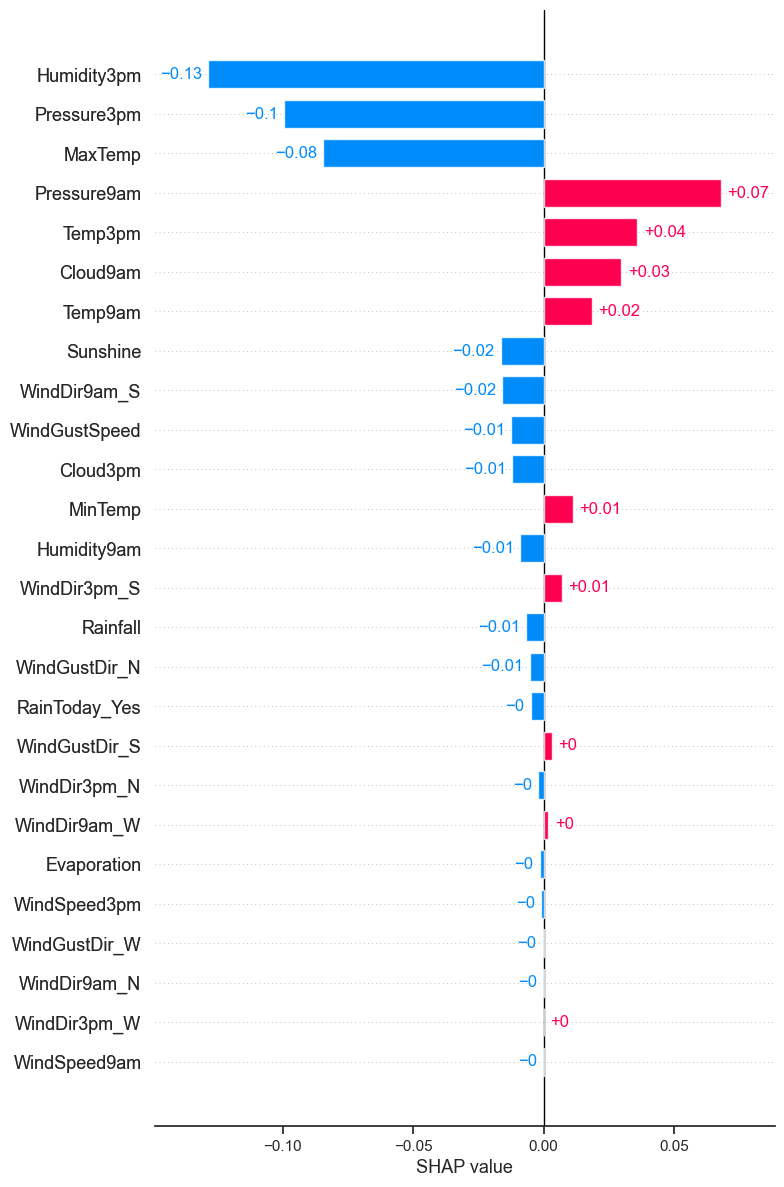

In [211]:
# Verificar la forma de shap_values
print("Shape of shap_values:", shap_values.shape)  # Salida: (1, 26, 1)

# Asegurarse de acceder correctamente a la primera instancia de explicación
shap_values_single = shap_values[0]

# Verificar la forma de shap_values_single para confirmar que ahora es (26, 1)
print("Shape of shap_values_single:", shap_values_single.shape)  # Salida: (26, 1)

# Crear la explicación para la instancia específica
explanation = shap.Explanation(values=shap_values_single, base_values=expected_value, feature_names=feature_names)

# Visualizar la explicación de las importancias de las características usando shap.plots.bar
shap.initjs()
shap.plots.bar(explanation, max_display=len(feature_names))

#### Explicabilidad global


In [226]:
import shap

# Seleccionar una única instancia para explicar
instance_to_explain = X_test_balanced_rlog.sample(n=1).values



In [228]:
shap_values = explainer.shap_values(instance_to_explain, nsamples=100)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
70594/70594 ━━━━━━━━━━━━━━━━━━━━ 104s 1ms/step


100%|██████████| 1/1 [03:03<00:00, 183.86s/it]


In [229]:
# Asegurarse de pasar una explicación unidimensional
explanation = shap.Explanation(values=shap_values[0][0], base_values=expected_value[0], feature_names=feature_names)


Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values_single: (26, 1)


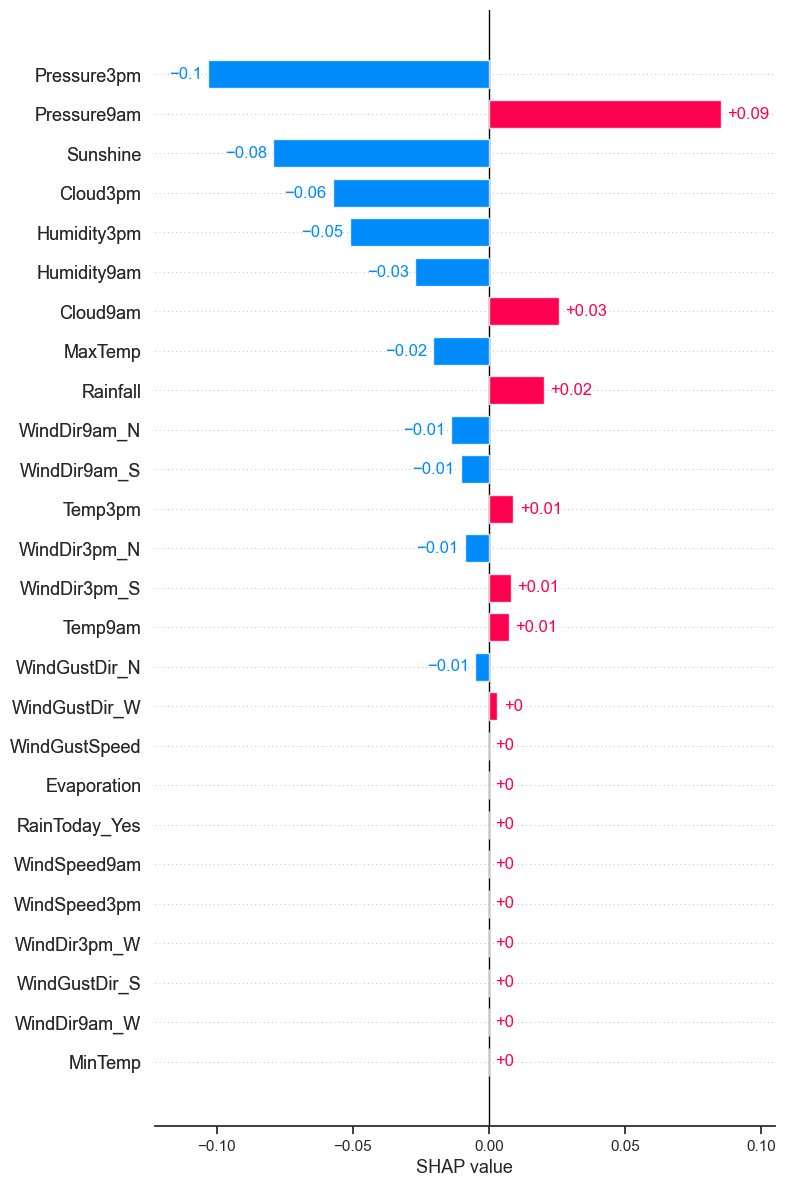

In [246]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Asumiendo que tienes un modelo (por ejemplo, modelo de clasificación) y los datos de entrenamiento X_train_balanced_rlog
# Asegúrate de utilizar el método adecuado para generar shap_values
explainer = shap.Explainer(model, X_train_balanced_rlog)


# Verificar el tipo de datos de shap_values
print("Type of shap_values:", type(shap_values))

# Asegurarse de acceder correctamente a la primera instancia de explicación
shap_values_single = shap_values[0]

# Verificar la forma de shap_values_single
print("Shape of shap_values_single:", shap_values_single.shape)

# Asegurarse de que shap_values_single tenga la forma correcta (26,)
if shap_values_single.ndim == 2:
    shap_values_single = shap_values_single[:, 0]

# Crear la explicación para las importancias de las características globales
feature_names = X_test_balanced_rlog.columns  # Ajusta según sea necesario
explanation = shap.Explanation(values=shap_values_single, feature_names=feature_names)

# Inicializar JS para gráficos interactivos si estás en Jupyter Notebook
shap.initjs()

# Visualizar la explicación de las importancias de las características usando shap.plots.bar
plt.figure(figsize=(12, 6))  # Ajusta el tamaño de la figura según sea necesario
shap.plots.bar(explanation, max_display=len(feature_names))

# Mostrar el gráfico
plt.show()



In [505]:
instance_to_explain = X_test_balanced_rlog.values 


In [506]:
# Obtener el valor esperado (base value)
expected_value = explainer.expected_value

# Hacer predicciones
predicted_proba = model.predict(X_test_balanced_rlog)  # Predicción de probabilidad
predicted_class = np.argmax(predicted_proba)  # Clase predicha

AttributeError: 'PermutationExplainer' object has no attribute 'expected_value'

In [503]:
# Crear la explicación para la instancia específica
explanation = shap.Explanation(values=shap_values, base_values=expected_value, feature_names=feature_names)

# Visualizar la explicación
shap.initjs()
shap.plots.bar(explanation, max_display=len(feature_names)) 


AttributeError: 'float' object has no attribute 'shape'

### Metricas


In [104]:
# Obtener las predicciones del modelo
y_pred = model.predict(X_test_balanced_rlog)

# Convertir las probabilidades a etiquetas binarias (0 o 1
y_pred_binary = (y_pred > 0.5).astype(int)

# Importar métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calcular métricas
accuracy = accuracy_score(y_test_encoded, y_pred_binary)
precision = precision_score(y_test_encoded, y_pred_binary)
recall = recall_score(y_test_encoded, y_pred_binary)
f1 = f1_score(y_test_encoded, y_pred_binary)
conf_matrix = confusion_matrix(y_test_encoded, y_pred_binary)

# Mostrar las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
Accuracy: 0.8309110244594116
Precision: 0.6534466477809254
Recall: 0.5410476935105551
F1 Score: 0.5919589392643285
Confusion Matrix:
[[3996  367]
 [ 587  692]]


Comparando la métrica con los modelos anteriores, podemos ver que nos da mejor la f1 score



### matriz de confusion

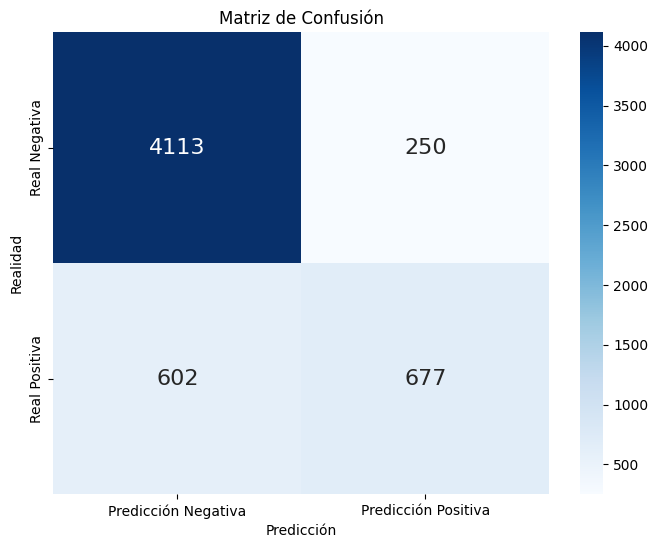

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Definir los valores de la matriz de confusión
tn, fp, fn, tp = 4113, 250, 602, 677

# Construir la matriz de confusión
conf_matrix = np.array([[tn, fp], [fn, tp]])

# Mostrar la matriz de confusión utilizando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16}, 
            xticklabels=['Predicción Negativa', 'Predicción Positiva'], 
            yticklabels=['Real Negativa', 'Real Positiva'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()



# Comparaciones

- En los modelos de clasificación, la regresión logística muestra un rendimiento consistentemente superior al de la red neuronal en términos de F1-score.
- En los modelos de regresión, la red neuronal supera significativamente a todos los demás modelos en términos de MSE.

## Comparación de Modelos de Regresión usando MSE

| Modelo/Técnica | MSE |
|----------------|-----|
| Regresión Lineal Inicial | 0.7457 |
| Gradiente Descendiente | 0.7846 |
| Lasso | 0.8445 |
| Ridge | 0.7834 |
| ElasticNet | 0.8223 |
| Red Neuronal | 0.1258 |

### Interpretación de Mis Resultados

- La red neuronal tiene el mejor rendimiento con un MSE de 0.1258, significativamente menor que el resto de los modelos.
- Entre los modelos lineales, la regresión lineal inicial tiene el mejor MSE (0.7457), seguida de cerca por Ridge (0.7834).
- Lasso muestra el rendimiento más bajo con un MSE de 0.8445.

## Comparación de Modelos de Clasificación usando F1-score

| Modelo/Técnica | F1-score |
|----------------|----------|
| Regresión Logística Inicial | 0.75 |
| Red Neuronal | 0.5920 |
| Regresión Logística (Grid Search) | 0.8325 |
| Regresión Logística (Random Search) | 0.8367 |

### Interpretación de Mis Resultados

- La regresión logística optimizada mediante Random Search muestra el mejor rendimiento, con un F1-score de 0.8367.
- La red neuronal, con un F1-score de 0.5920, tiene el rendimiento más bajo entre todos los modelos de clasificación probados.